# Bacterial Genome-Wide Association Study (GWAS) using kmers

### Aims

* Perform tests of association to identify genes or genetic variants associated with resistance to an unspecified antimicrobial

* Interpret the signals using Manhattan plots

* BLAST significant unmapped kmers to NCBI

* ***Identify the mystery phenotype using databases of known resistance mechanisms***

### Overview

Done for you:
* Step 1. Tabulate the kmers in every genome
* Step 2. Collate a complete list of unique kmers
* Step 3. Define presence/absence of all unique kmers across all genomes; compute kinship matrix
* Step 5B. Map kmers to reference genome with Bowtie

Today’s practical:
* Log in to JupyterHub
* Step 4. Run GEMMA (linear mixed model) on kmers
* Step 6B. Plot Figures via Bowtie Mapping Positions

## 1. Preliminaries

Run the initialization script. Note the [\*] on the left means the script is running. When finished, the \* will be replaced with a number. Wait until it is finished. The script will also say when it is done.

If there is an error, remove the # from the third line and try again.

In [1]:
%%bash
# Bash code
#chmod -R 755 ~/Wednesday/ && rm -rf ~/Wednesday
bash ~/init.sh


Entrez Direct has been successfully downloaded and installed.


To activate EDirect for this terminal session, please execute the following:

export PATH=${PATH}:${HOME}/edirect

Done !


Set your workshop identifier.

In [2]:
if 'PHENO' in globals():
    print('Your participant id is already: ' + PHENO)
else:
    import random
    PHENO = 'workshop' + str(random.randint(1, 35)).zfill(2)
    print('Your participant id is: ' + PHENO)

Your participant id is: workshop35


***To override your participant id and run the example, remove the # from the following code block and execute it.***

In [3]:
#PHENO='phe8'

Define the location of input and output files as python variables.

In [4]:
# Location of the kmer_pipeline scripts
SCRIPTS='/home/jovyan/Wednesday/amr/scripts'
# Location of the S. aureus reference genomes
REFDIR='/home/jovyan/Wednesday/amr'
# File containing locations of software apps
#APPS='/usr/share/kmer_pipeline/example/pipeline_software_location.txt'
APPS='/home/jovyan/Wednesday/amr/pipeline_software_location.txt'
# Parent folder for the amr input/output data
AMRDIR='/home/jovyan/Wednesday/amr'
# Folder (& prefix) containing pre-computed genome data
INDIR=AMRDIR+'/take1/take1_cip_nucleotide31'
# Folder containing downloaded phenotypes
PHENO_DIR=AMRDIR+'/phenotypes'
# Folder for output of data analysis
OUTDIR=AMRDIR+'/out'
# Folder for storing error logs
LOGDIR=OUTDIR+'/log'
# Prefix for output files
OUTPUT_PREFIX='amr'
# Location (& prefix) of figures
FIGDIR=OUTDIR+'/nucleotidekmer31_bowtie2mapping_figures/'+OUTPUT_PREFIX+'.'+PHENO+'_nucleotide31_R00000022_'
# Number of cores available per user
NCORES='2'

## 2. Run Genome-wide Efficient Mixed Model Associations (GEMMA)

Xiang Zhou and Matthew Stephens (2012). Genome-wide efficient mixed-model analysis for association studies. *Nature Genetics* 44, 821–824.

The following executes a bash script that runs GEMMA in parallel. It takes about 15 minutes to complete on two cores.

In [5]:
%%script env SCRIPTS="$SCRIPTS" REFDIR="$REFDIR" APPS="$APPS" AMRDIR="$AMRDIR" INDIR="$INDIR" PHENO_DIR="$PHENO_DIR" OUTDIR="$OUTDIR" LOGDIR="$LOGDIR" OUTPUT_PREFIX="$OUTPUT_PREFIX" NCORES="$NCORES" PHENO="$PHENO" bash
# Bash script
#!/usr/bin/env bash
# Create the output directories
mkdir -p $OUTDIR
mkdir -p $LOGDIR
cd $OUTDIR
# Parallelize over multiple cores
for SGE_TASK_ID in $(seq 1 $NCORES); do
    # Remove previous log files
    rm -f $LOGDIR/rungemma.$SGE_TASK_ID.log
    # Execute the Rscript wrapper for GEMMA
    $SCRIPTS/rungemma.Rscript $SGE_TASK_ID $NCORES $INDIR \
        $PHENO_DIR/$PHENO.txt $OUTPUT_PREFIX.$PHENO \
        $OUTDIR nucleotide 31 $APPS &> \
        $LOGDIR/rungemma.$SGE_TASK_ID.log &
    # Record process ID
    PIDS[${SGE_TASK_ID}]=$!
done
echo 'GEMMA scripts launched ...'

GEMMA scripts launched ...


In [6]:
%%script env LOGDIR="$LOGDIR" bash
echo ' '
echo '1a. Open a new Terminal tab (select from the menu File->New Terminal)'
echo '1b. Copy and paste the following line to track the progress of the first job:'
echo ' '
echo '        tail --follow -n +1 '$LOGDIR'/rungemma.1.log'
echo ' '
echo ' '
echo '2a. Open a second Terminal tab in the same way'
echo '2b. Copy and paste the following code to track the progress of the second job:'
echo ' '
echo '        tail --follow -n +1 '$LOGDIR'/rungemma.2.log'
echo ' '
echo ' '

 
1a. Open a new Terminal tab (select from the menu File->New Terminal)
1b. Copy and paste the following line to track the progress of the first job:
 
        tail --follow -n +1 /home/jovyan/Wednesday/amr/out/log/rungemma.1.log
 
 
2a. Open a second Terminal tab in the same way
2b. Copy and paste the following code to track the progress of the second job:
 
        tail --follow -n +1 /home/jovyan/Wednesday/amr/out/log/rungemma.2.log
 
 


Monitor the Terminal sessions to see when the processes have both finished.

Wait until the log files both state `Finished in ... minutes`

When **both jobs have finished**, move on to the next section.
This takes about 15 minutes.

## 3. Create Figures and Tables

**Warning**: executing the code below prematurely will terminate Step 2, requiring it to be re-run. If this happens, you should see 'No such file or directory' errors in the Step 2 log files.

In [7]:
%%script env SCRIPTS="$SCRIPTS" REFDIR="$REFDIR" APPS="$APPS" AMRDIR="$AMRDIR" INDIR="$INDIR" PHENO_DIR="$PHENO_DIR" OUTDIR="$OUTDIR" LOGDIR="$LOGDIR" OUTPUT_PREFIX="$OUTPUT_PREFIX" NCORES="$NCORES" PHENO="$PHENO" bash
# Bash script: press Shift+Enter
#!/usr/bin/env
# Execute the Rscript that produces the figures
cd $OUTDIR
$SCRIPTS/plotManhattanbowtie.Rscript \
    $OUTPUT_PREFIX.$PHENO $OUTDIR $INDIR \
    $REFDIR/R00000022.gbk $REFDIR/R00000022.fa \
    $PHENO_DIR/$PHENO.txt nucleotide 31 0.01 10 $APPS \
    70 20 &> $LOGDIR/plotManhattanbowtie.1.log &

In [8]:
%%script env LOGDIR="$LOGDIR" bash
echo ''
echo '3a. Open a new Terminal tab (select from the menu File->New Terminal)'
echo '3b. Copy and paste the following line to track the progress of the first job:'
echo ' '
echo '        tail --follow -n +1 '$LOGDIR'/plotManhattanbowtie.1.log'
echo ' '
echo ' '


3a. Open a new Terminal tab (select from the menu File->New Terminal)
3b. Copy and paste the following line to track the progress of the first job:
 
        tail --follow -n +1 /home/jovyan/Wednesday/amr/out/log/plotManhattanbowtie.1.log
 
 


Monitor the Terminal session to see when the process has finished. This file will output the most significant genes and intergenic regions.

Wait until the log file states `Finished in ... minutes`

This takes about 15 minutes.

## 4. Interpret the Results

### Genome-wide Manhattan plots

The following code opens the file ending `LMM_bowtie2mapping_Manhattan_betaCOL_maf0.01.png`


/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_LMM_bowtie2mapping_Manhattan_betaCOL_maf0.01.png



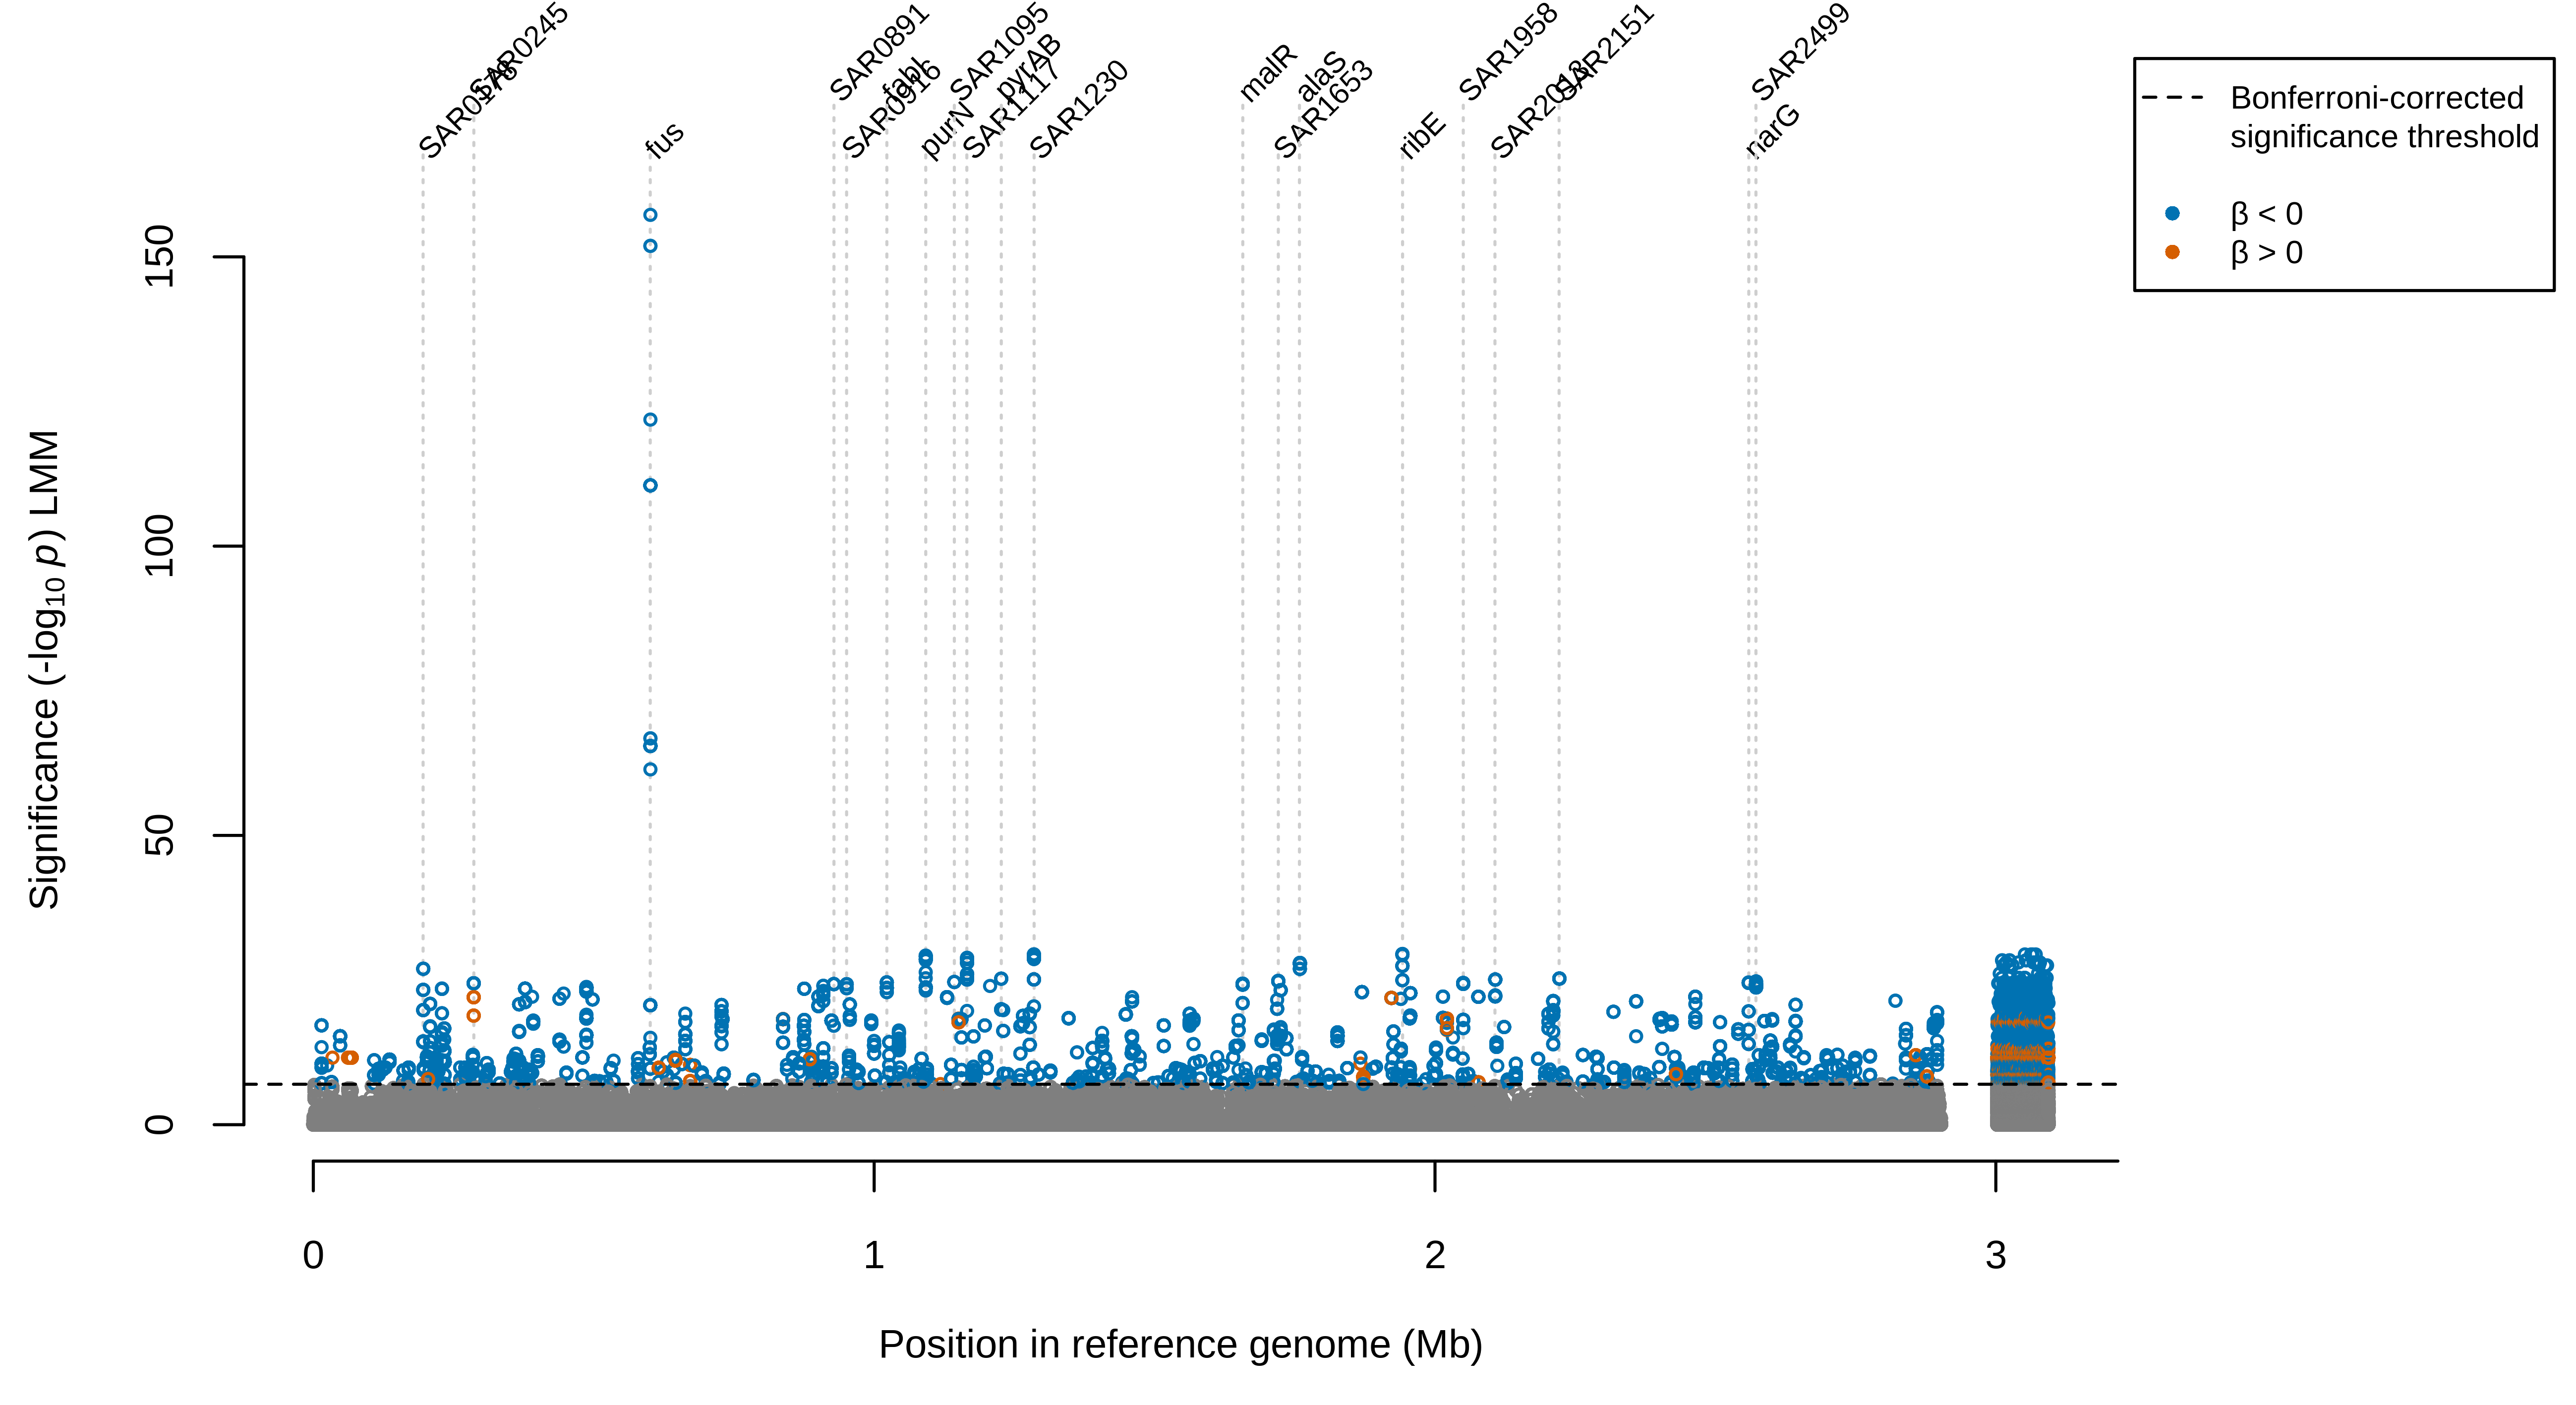

In [9]:
from IPython.display import Image, display
FIGLAB='LMM_bowtie2mapping_Manhattan_betaCOL_maf0.01.png'
print('\n'+FIGDIR+FIGLAB+'\n')
Image(filename=FIGDIR+FIGLAB,alt=FIGLAB)

Genes with significant kmers are highlighted; colour shows whether kmer presence has an increasing or decreasing effect on the phenotype (resistance).

### Gene-specific Manhattan plots

To investigate gene with name *WXYZ*, we open the file ending *WXYZ*_Manhattan_maf0.01.png

For example the top hit, *fus*.

***Replace `GENE='fus'` below with a significant gene name in your Manhattan plot.***

Tip: if you cannot read the gene name, consult the log file which printed out the top significant genes.


/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_fus_Manhattan_maf0.01.png



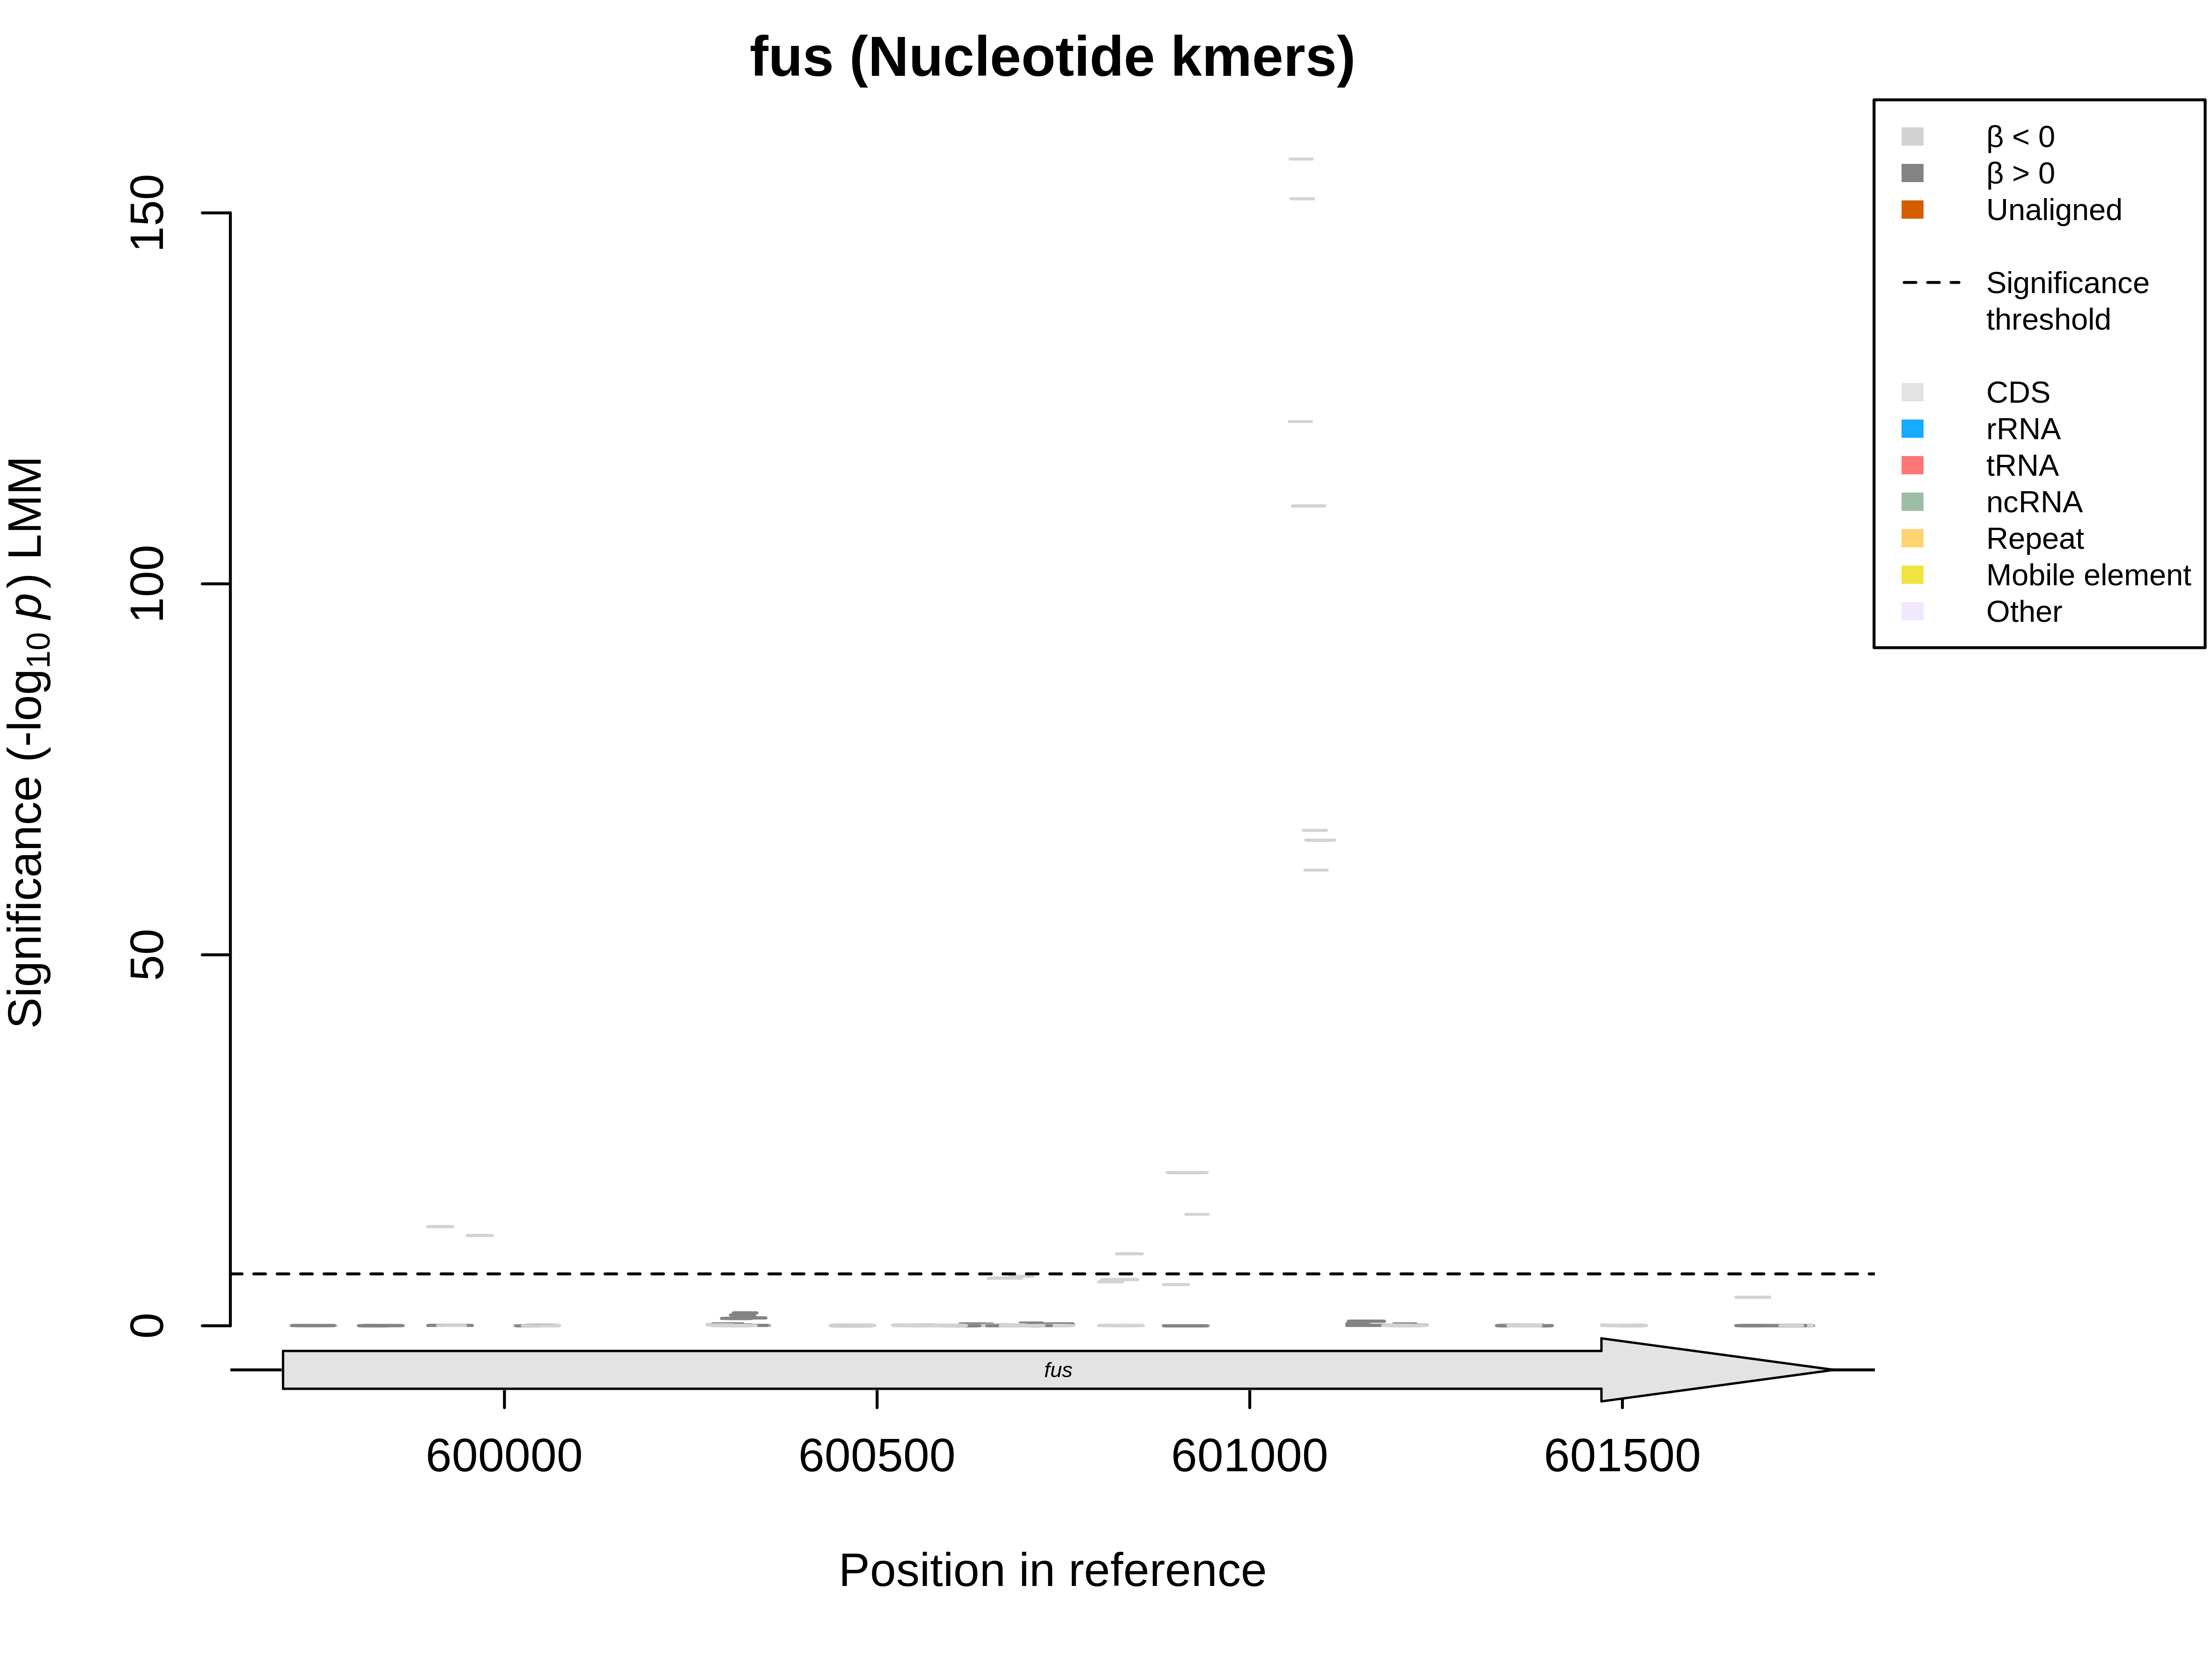

In [10]:
GENE='fus'
FIGLAB=GENE+'_Manhattan_maf0.01.png'
print('\n'+FIGDIR+FIGLAB+'\n')
Image(filename=FIGDIR+FIGLAB,alt=FIGLAB)

This time shading indicates whether kmer presence increases or decreases the phenotype, and colour indicates function (when available in the genbank annotation file).

### Kmer-specific Manhattan plots

To investigate individual kmers in gene *WXYZ*, open the files named \*\_*WXYZ*\_plot\_\*\_maf0.01_alignment.png where is \* a wildcard.

For example, the top hit *fus*.

***Replace `GENE='fus'` below with a significant gene name in your Manhattan plot.***


/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_*fus_*maf0.01_alignment.png

/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_fus_plot_29_pos_599824_to_599923_maf0.01_alignment.png


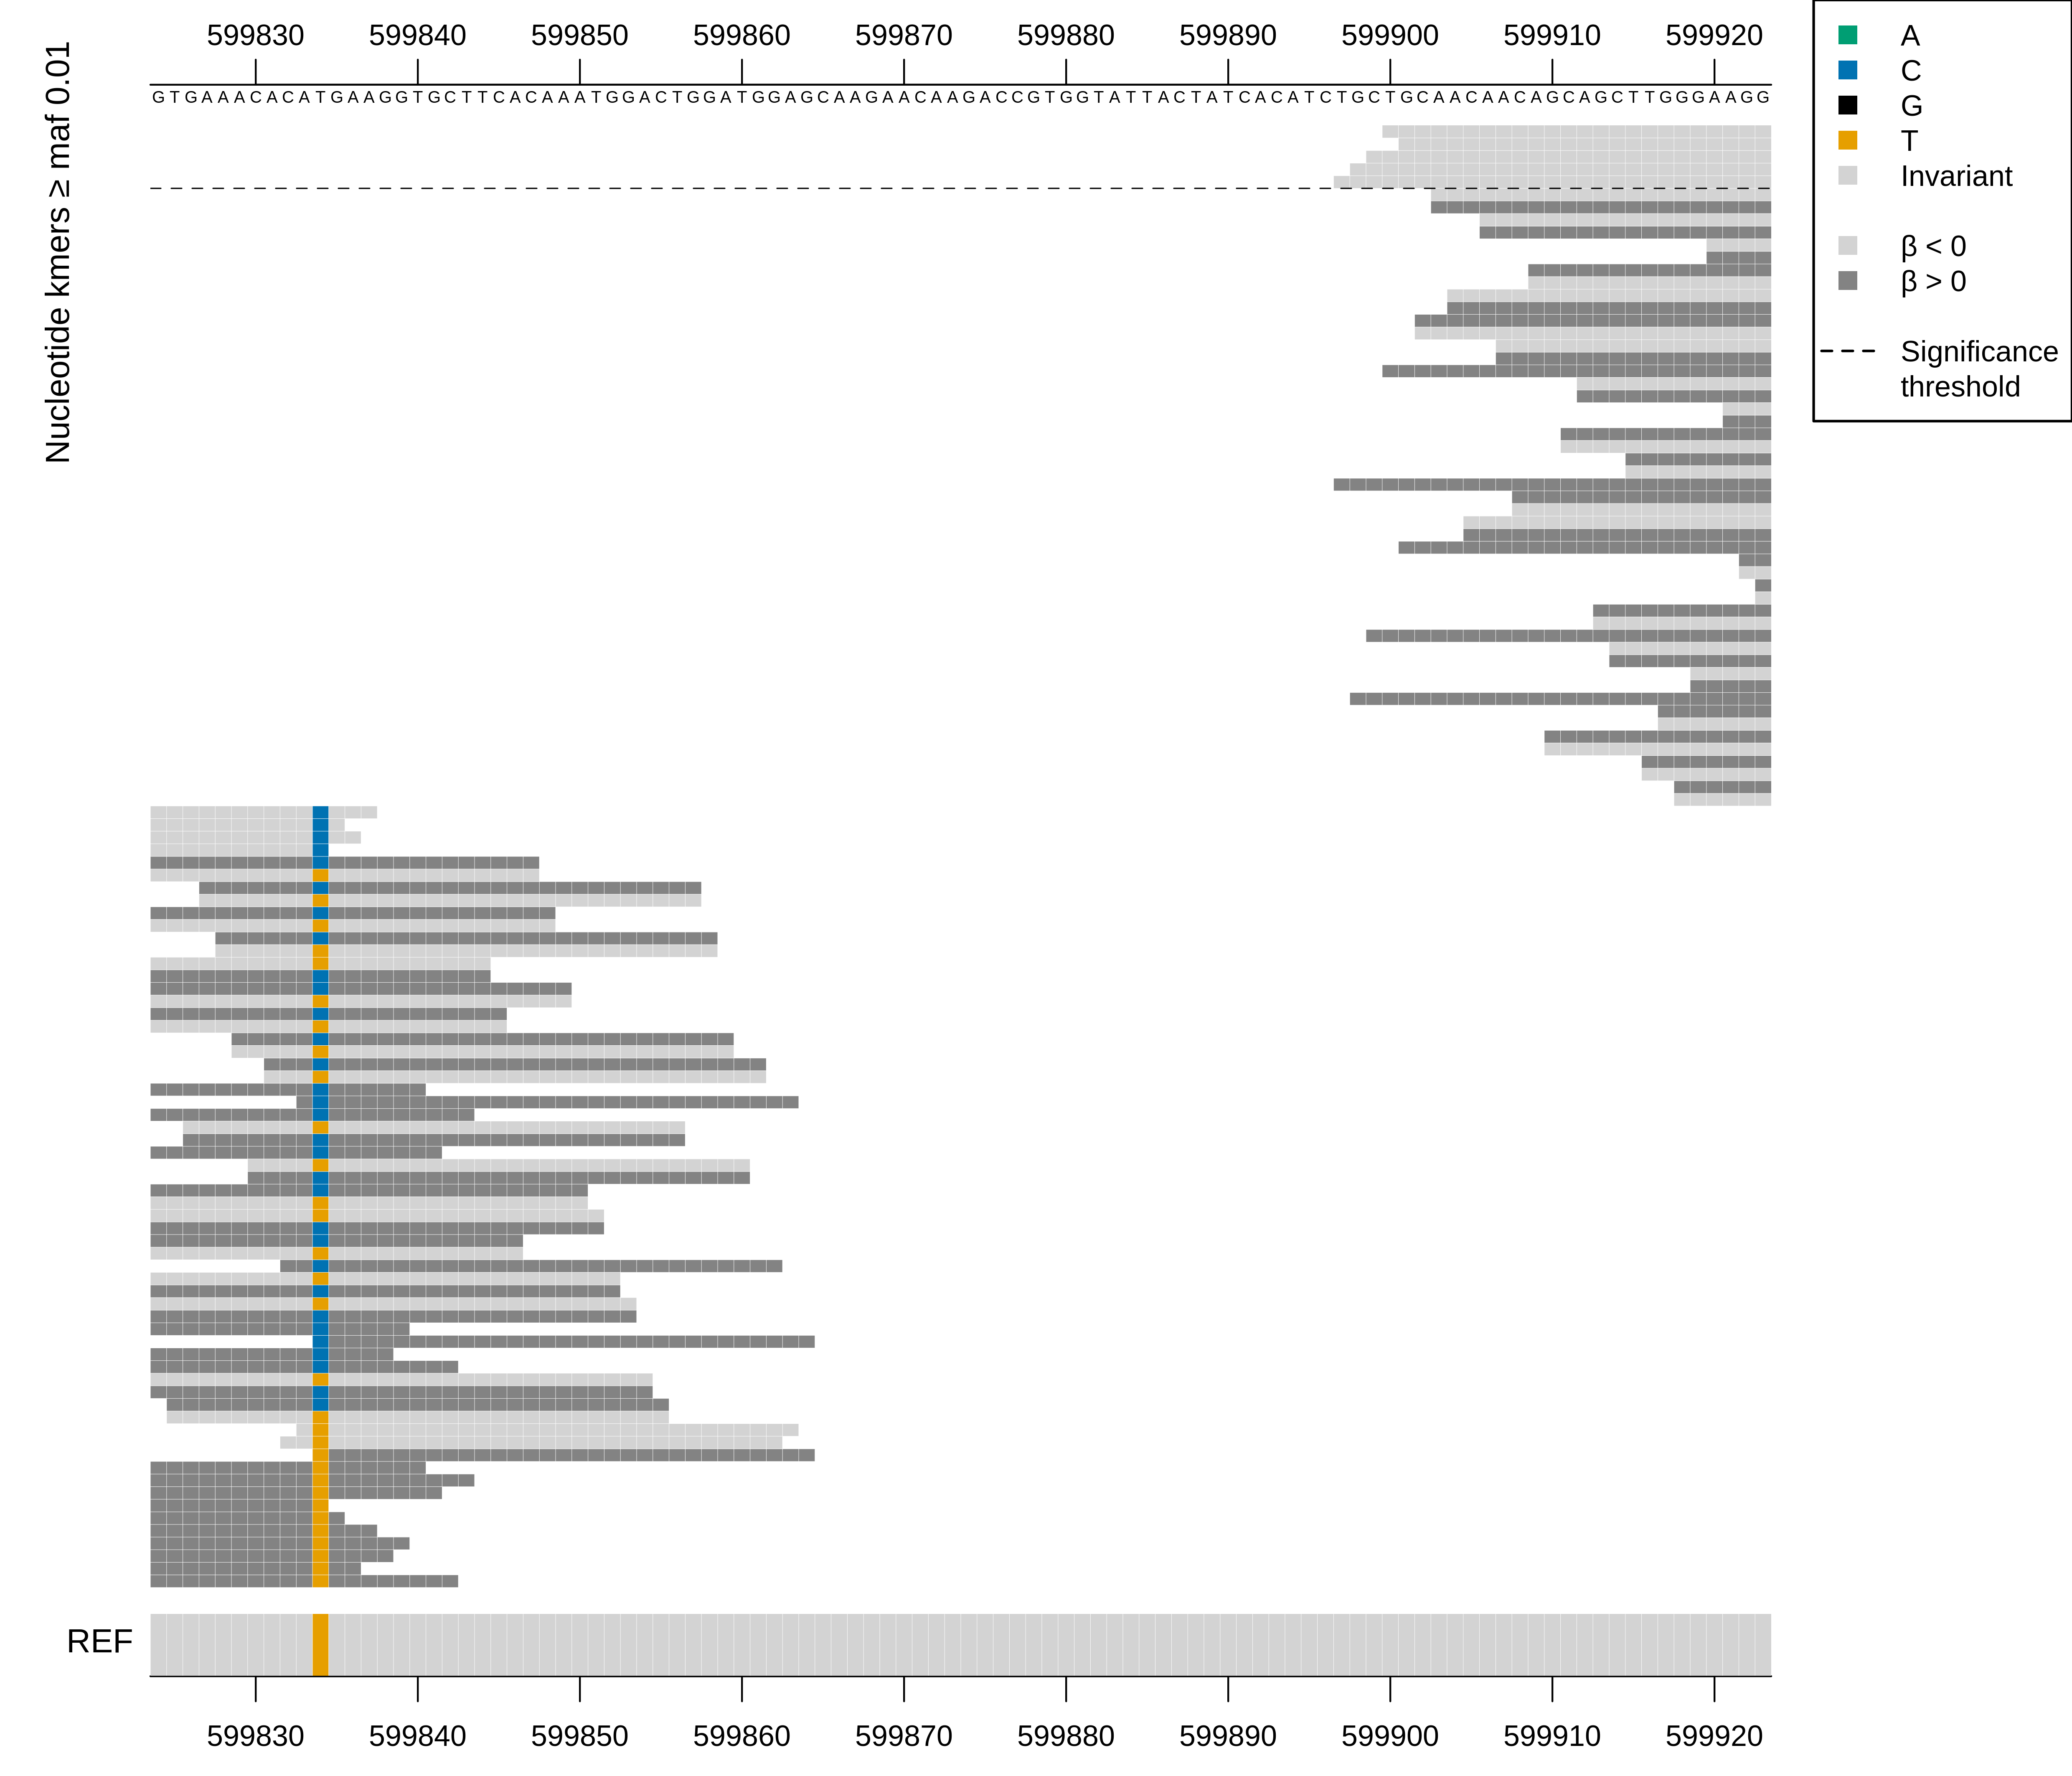

/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_fus_plot_30_pos_599864_to_599963_maf0.01_alignment.png


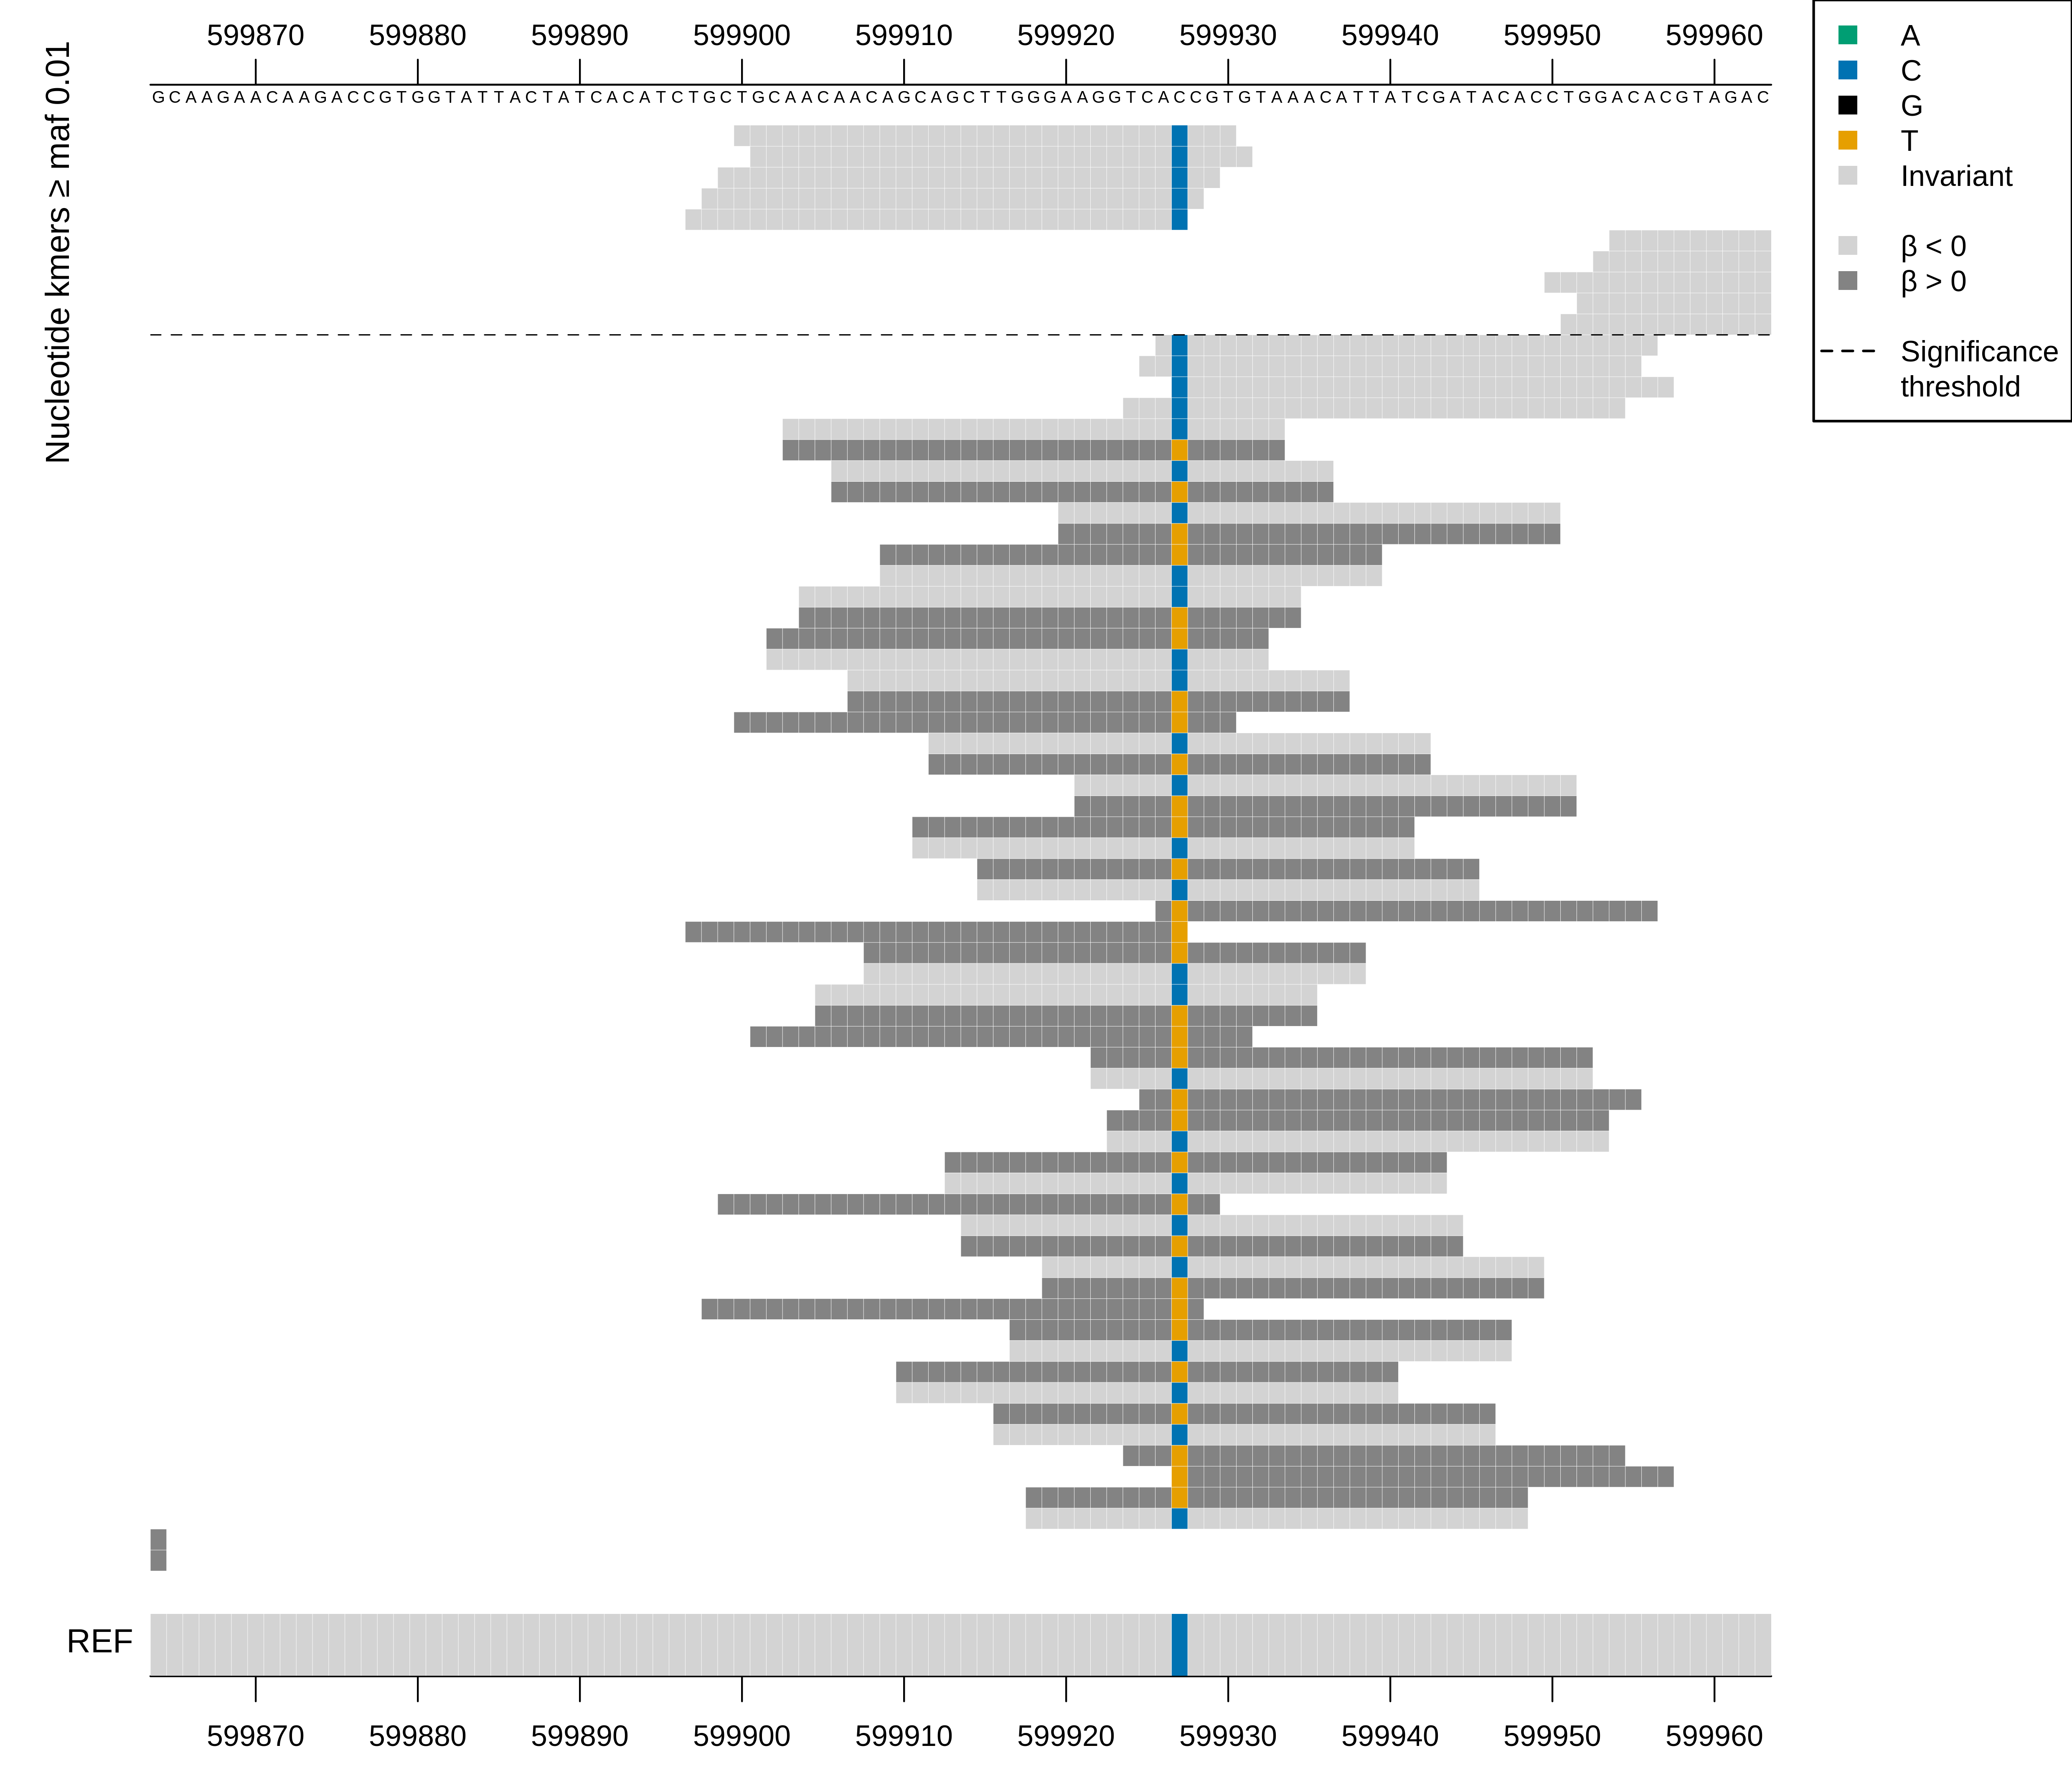

/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_fus_plot_31_pos_599904_to_600003_maf0.01_alignment.png


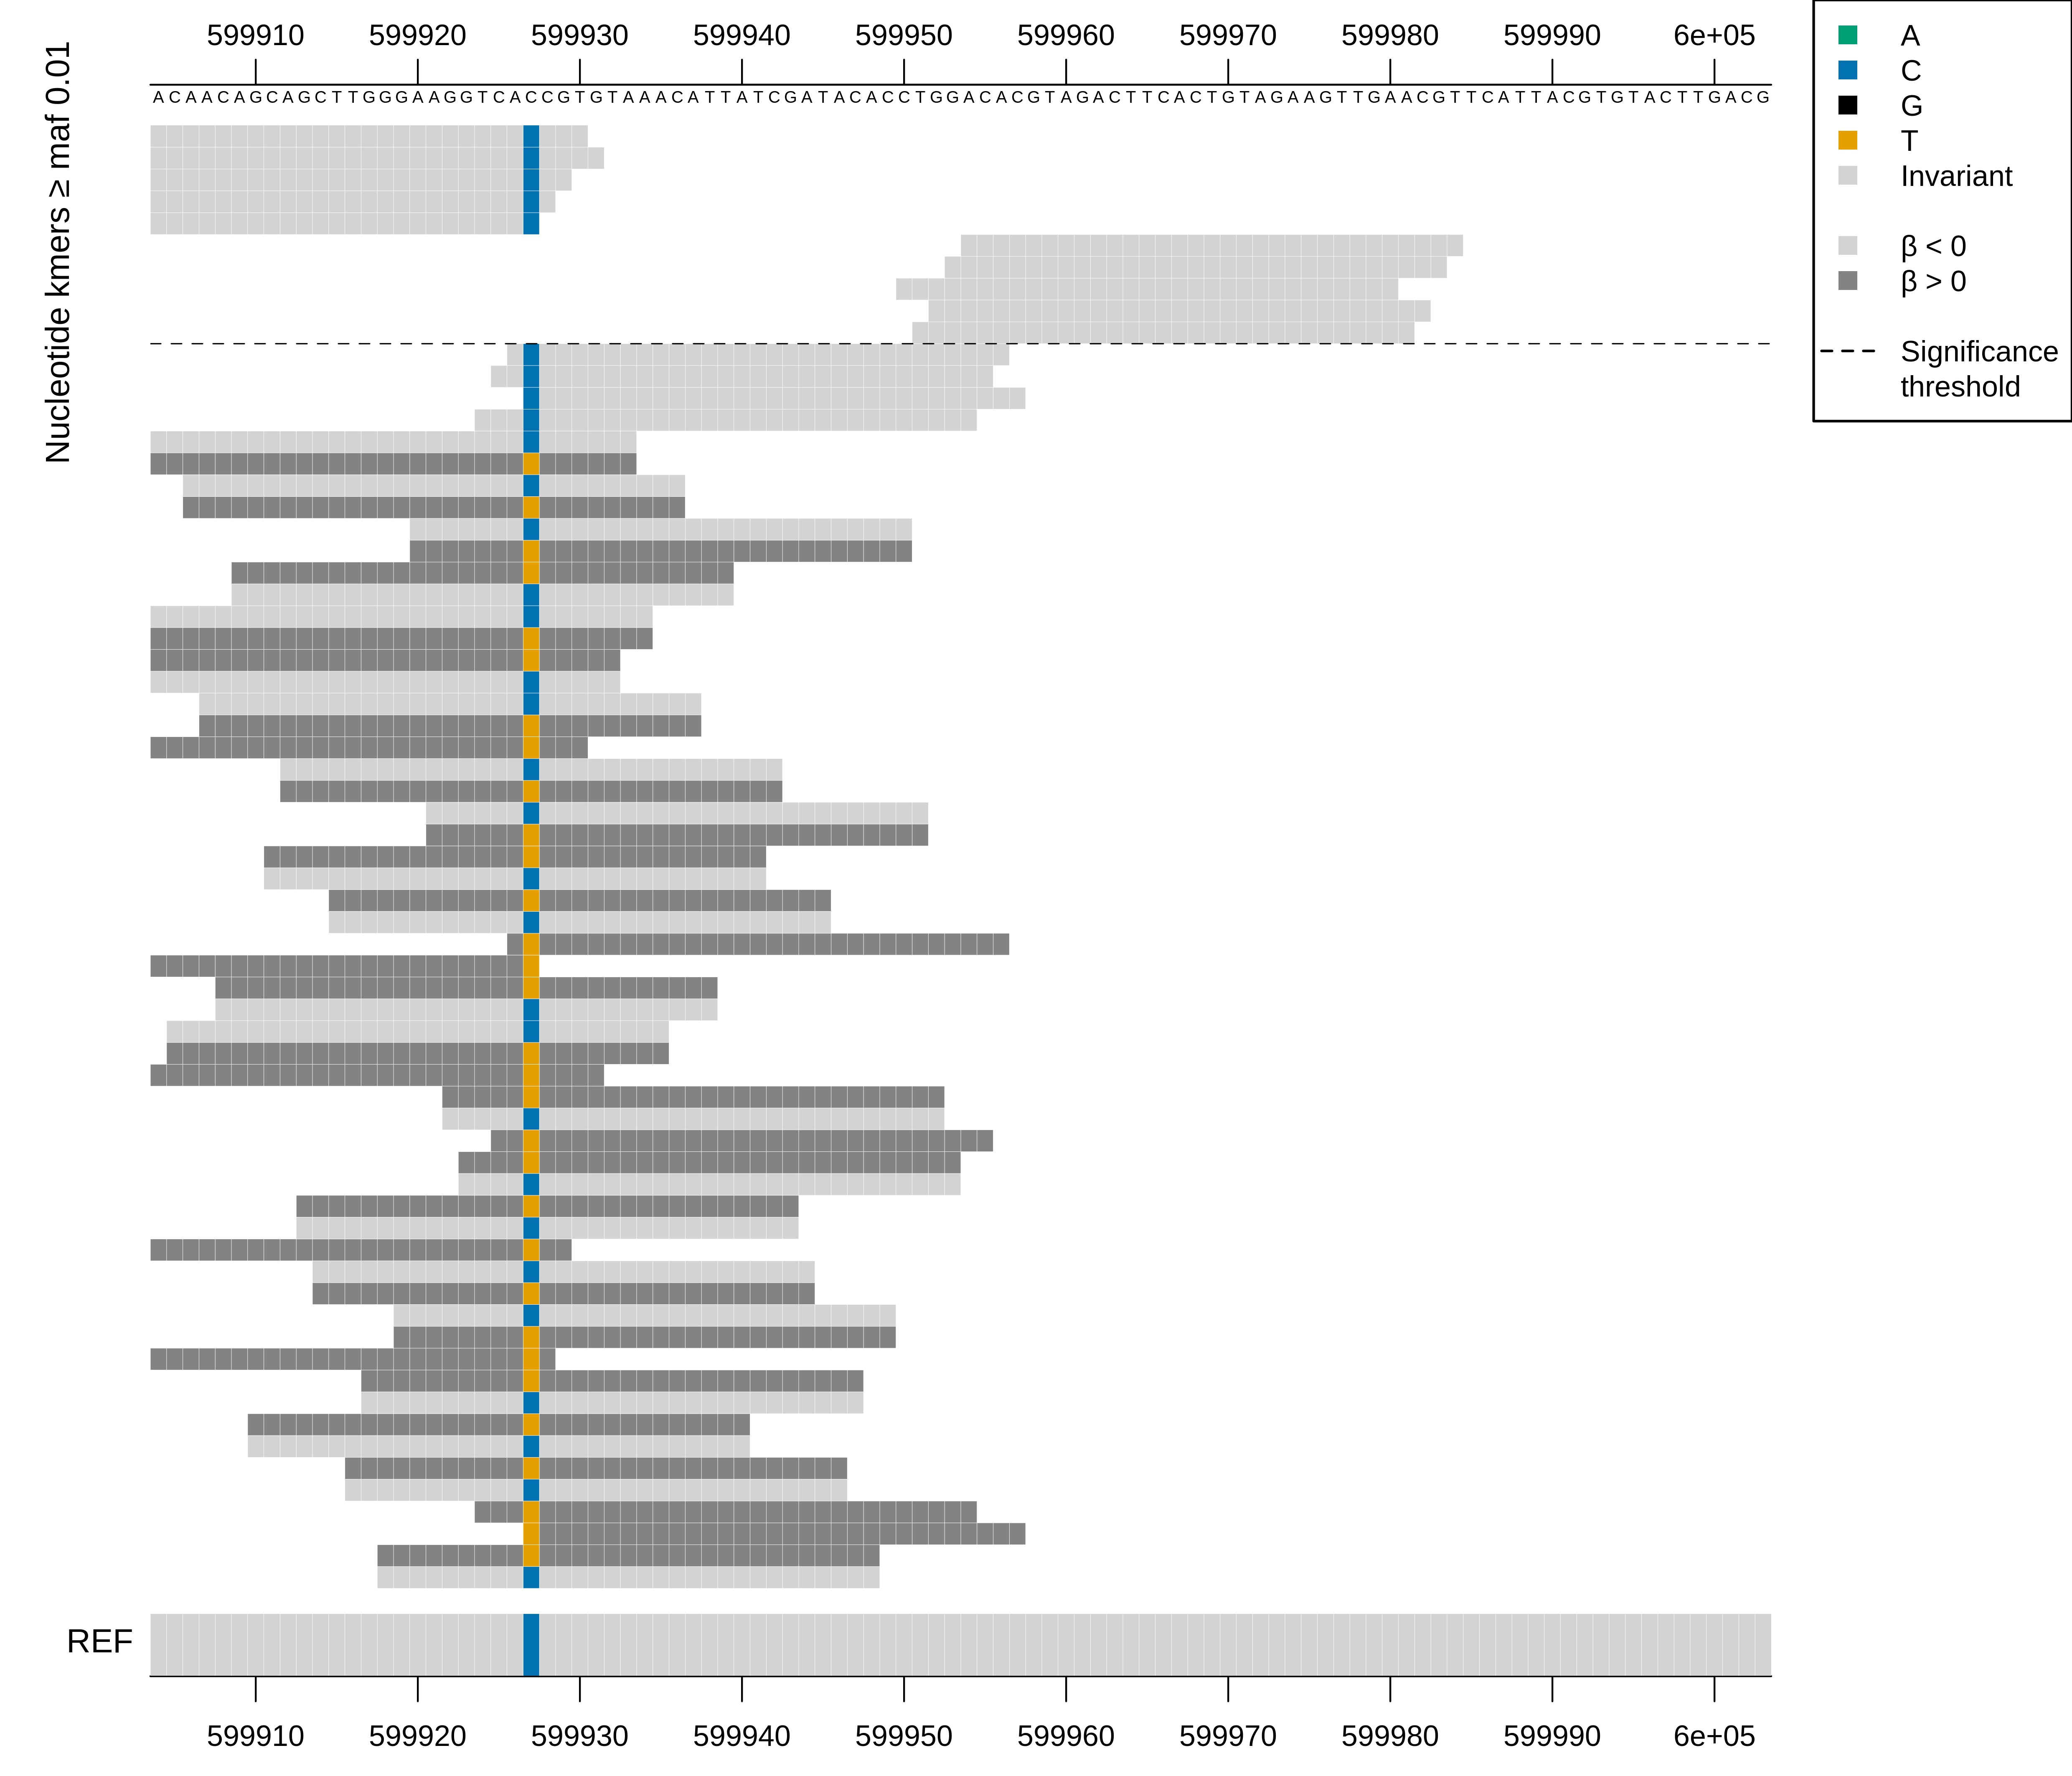

/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_fus_plot_32_pos_599944_to_600043_maf0.01_alignment.png


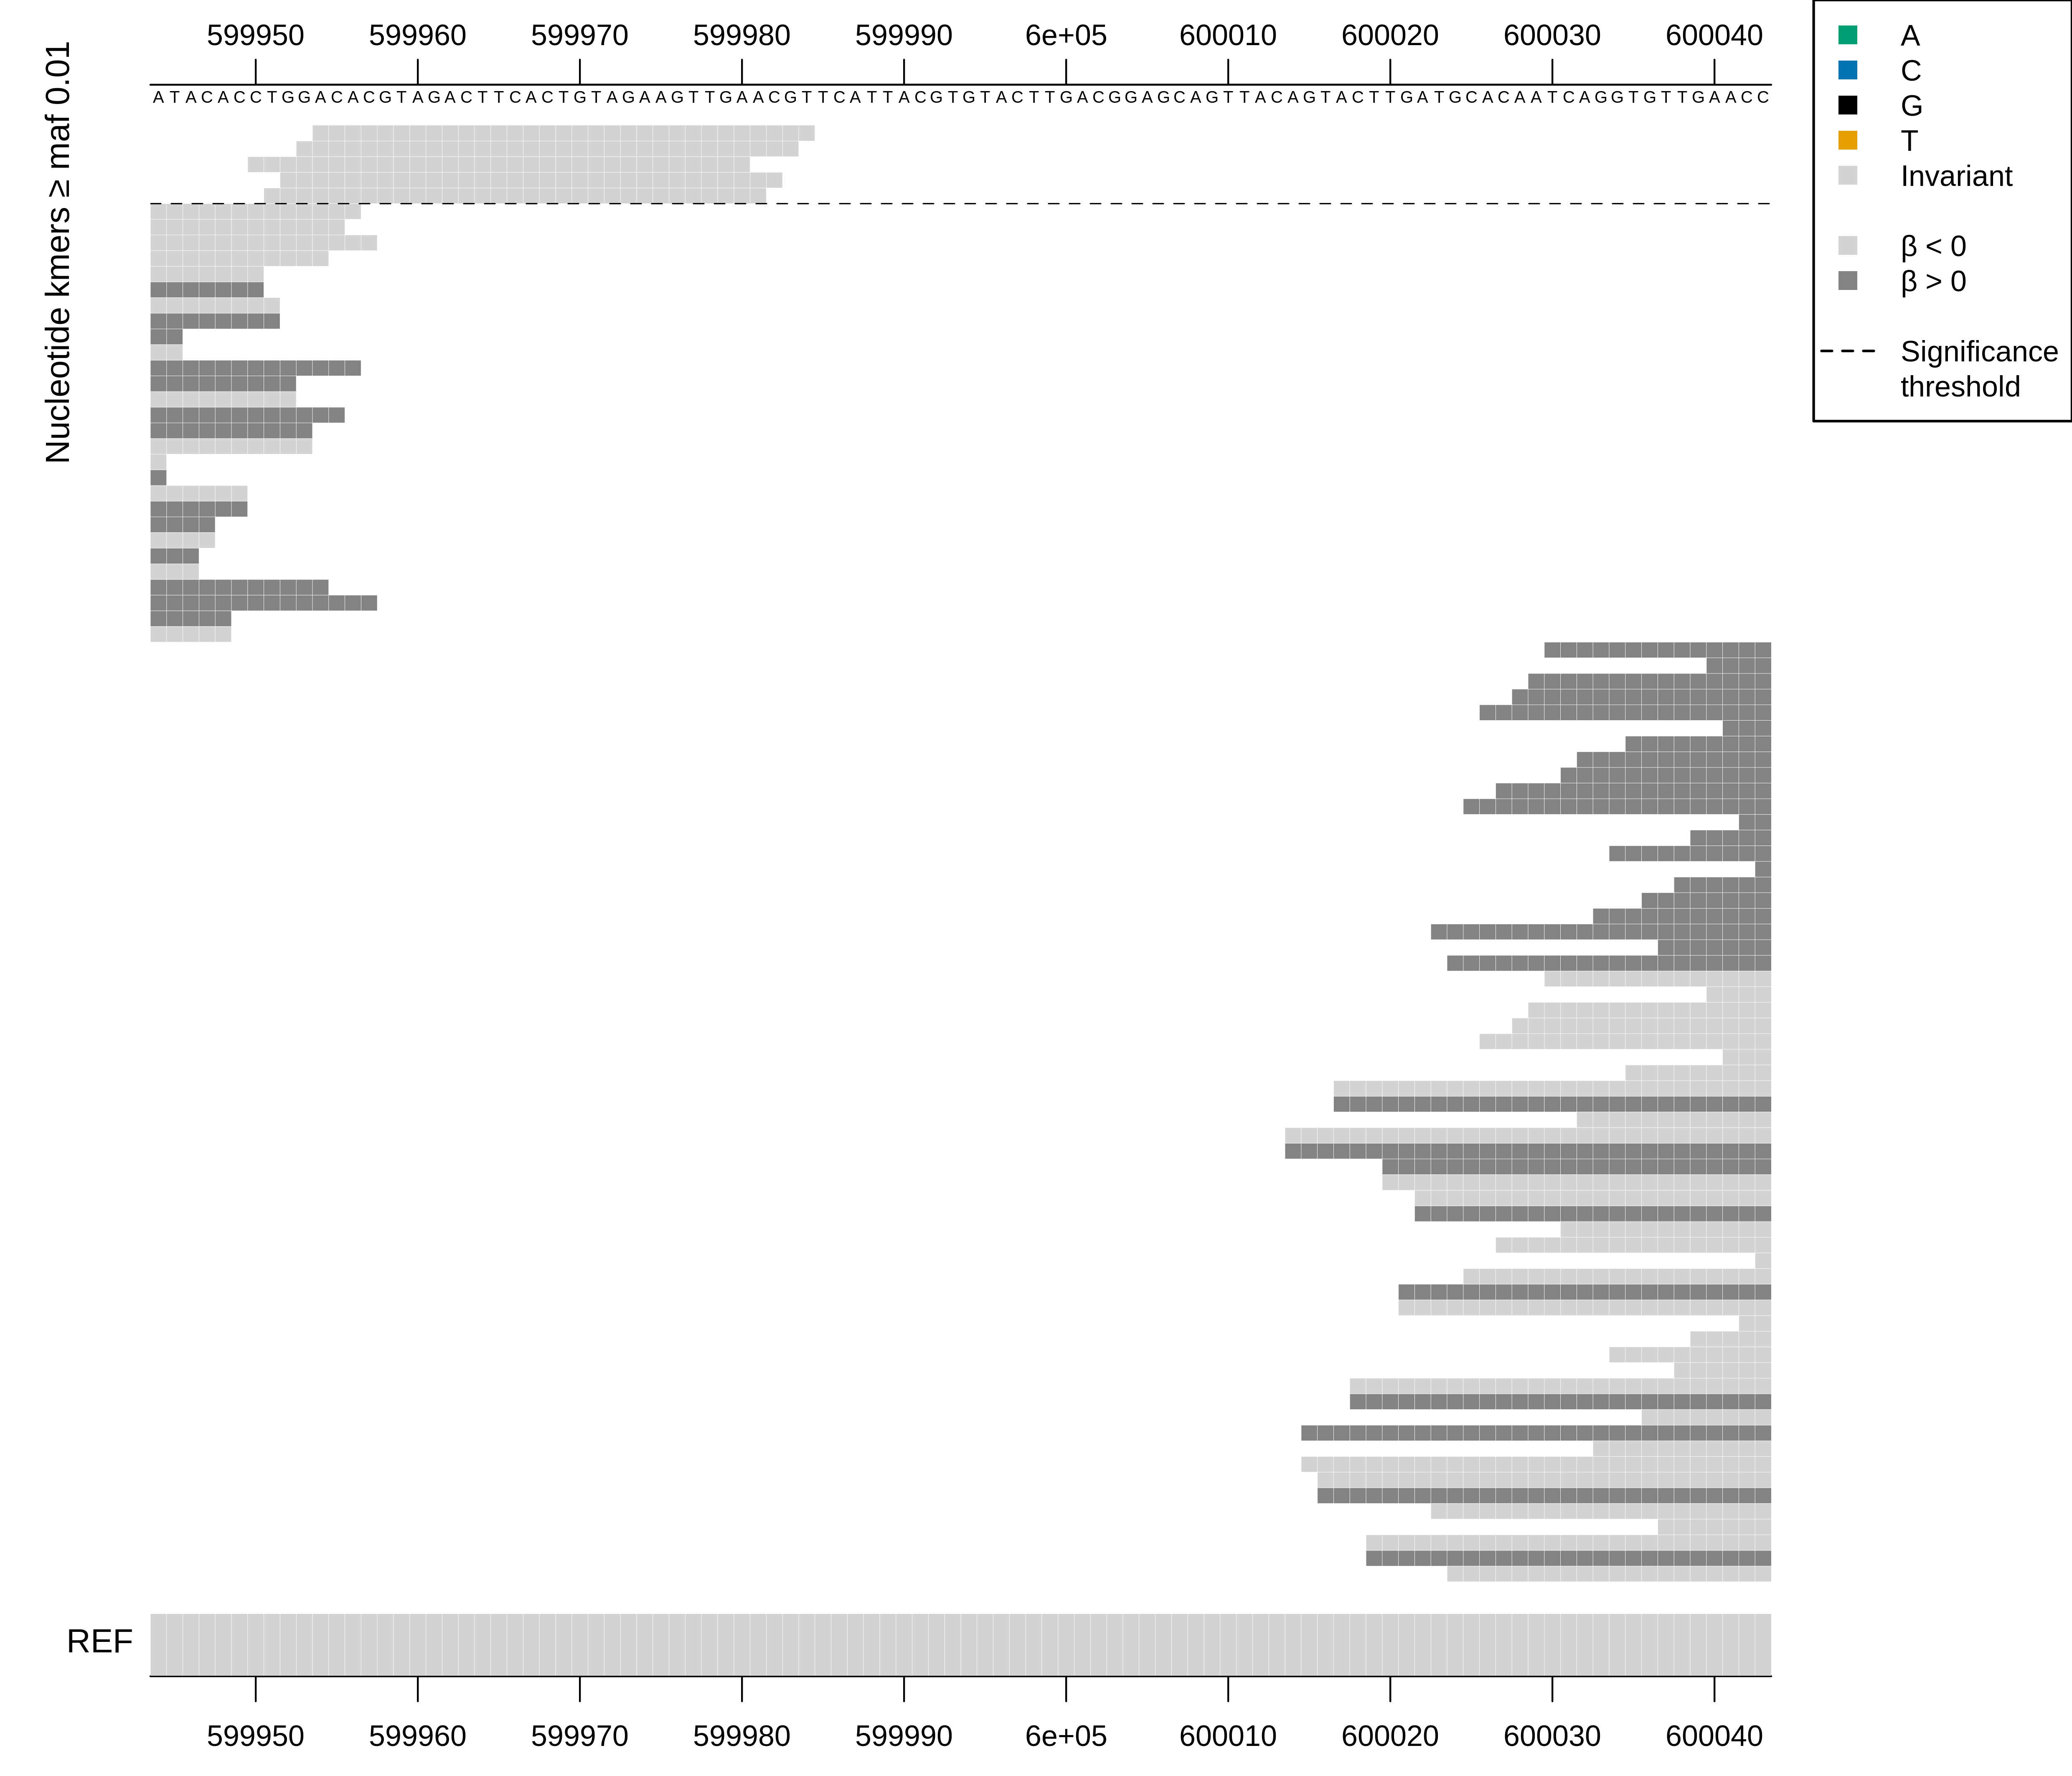

/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_fus_plot_33_pos_599984_to_600083_maf0.01_alignment.png


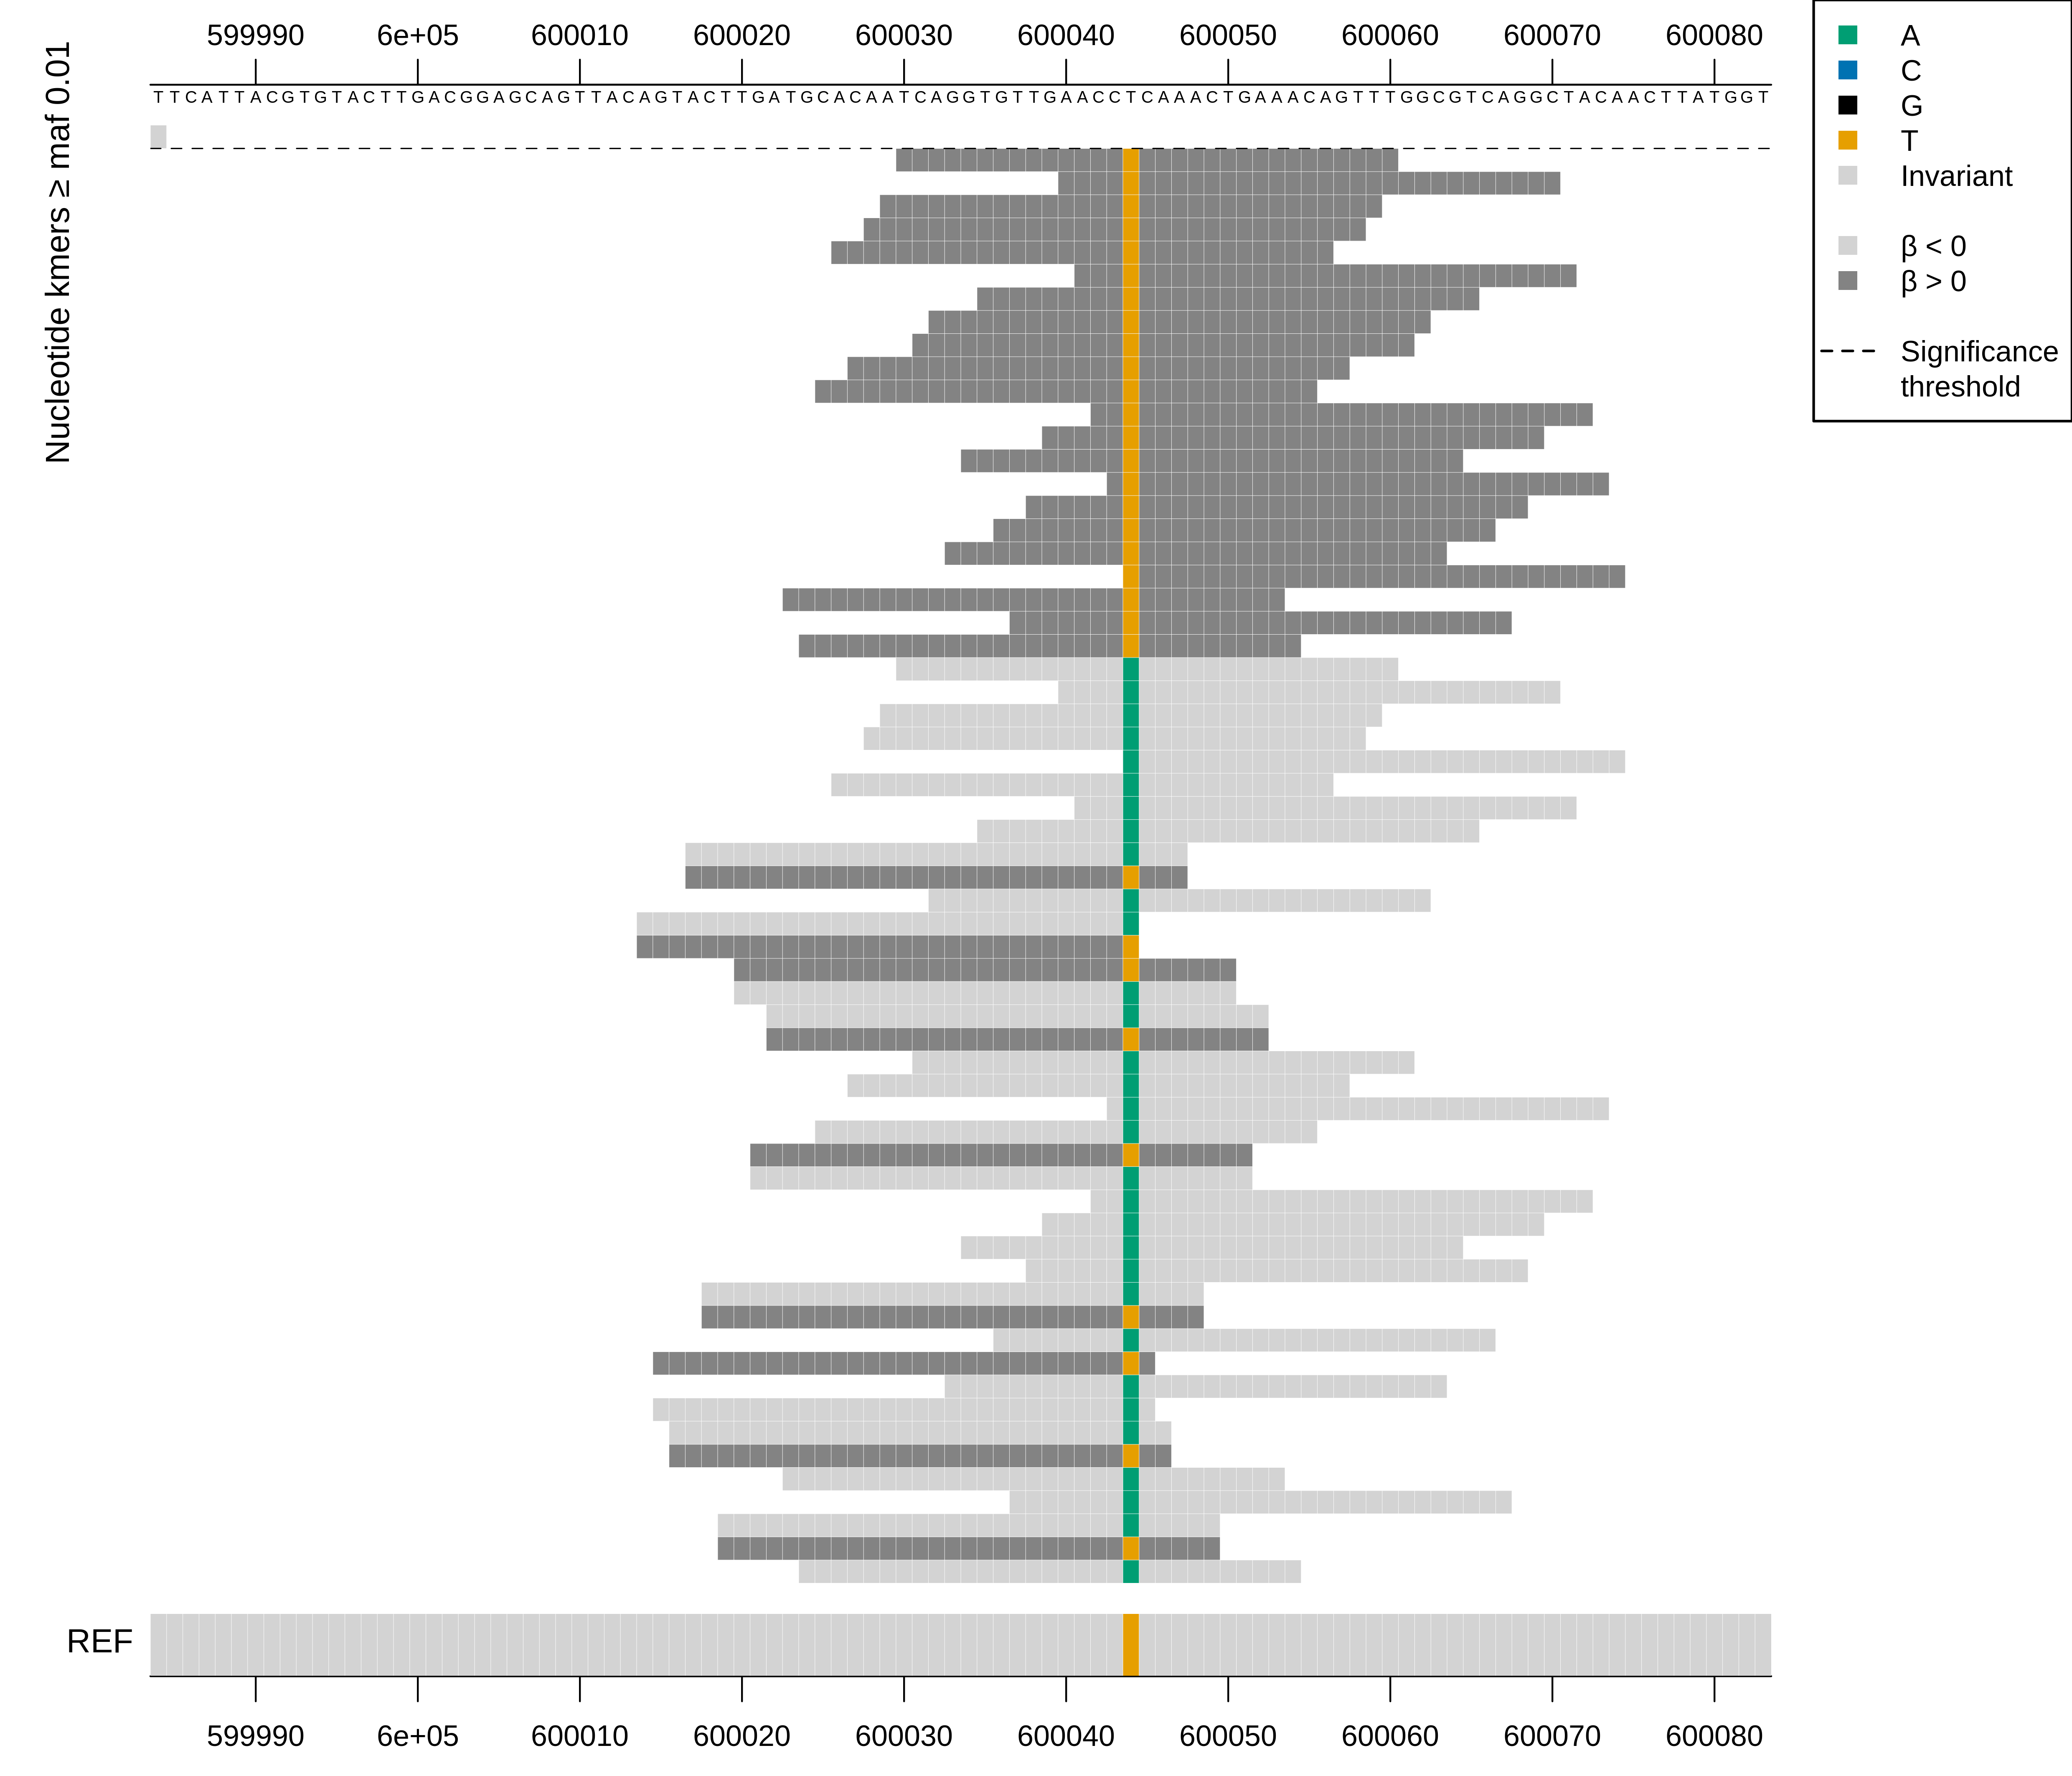

/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_fus_plot_52_pos_600744_to_600843_maf0.01_alignment.png


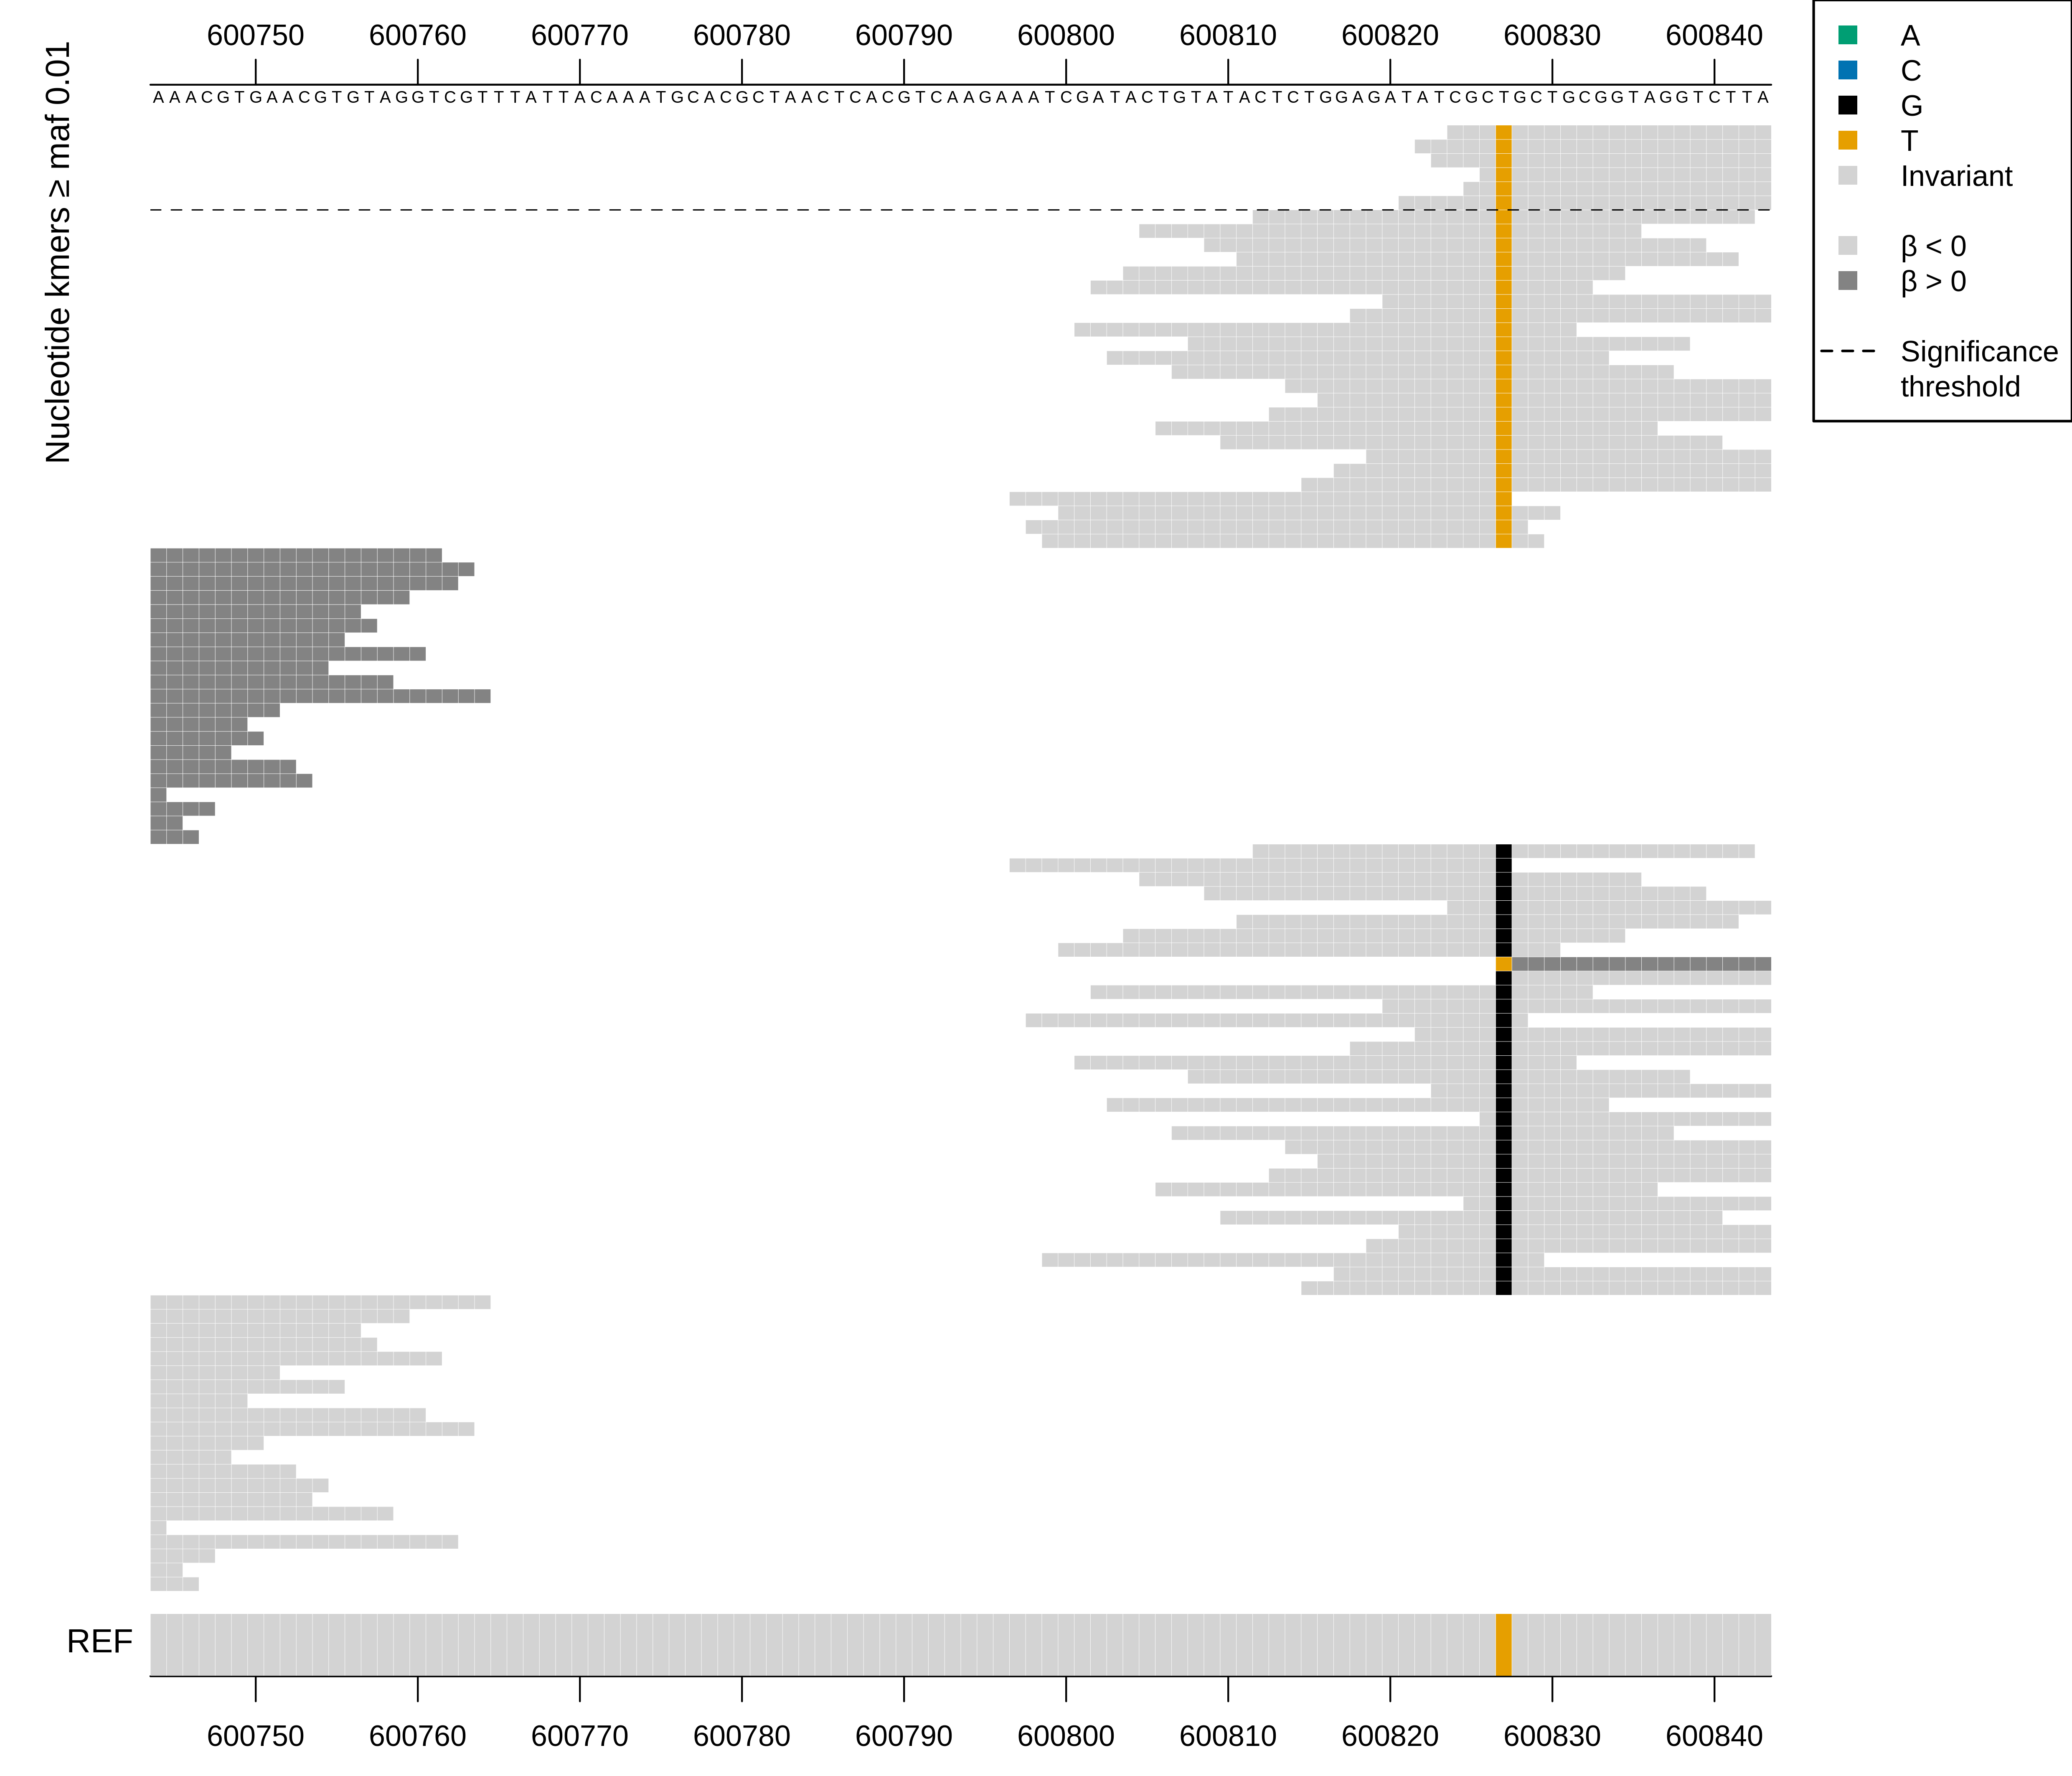

/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_fus_plot_53_pos_600784_to_600883_maf0.01_alignment.png


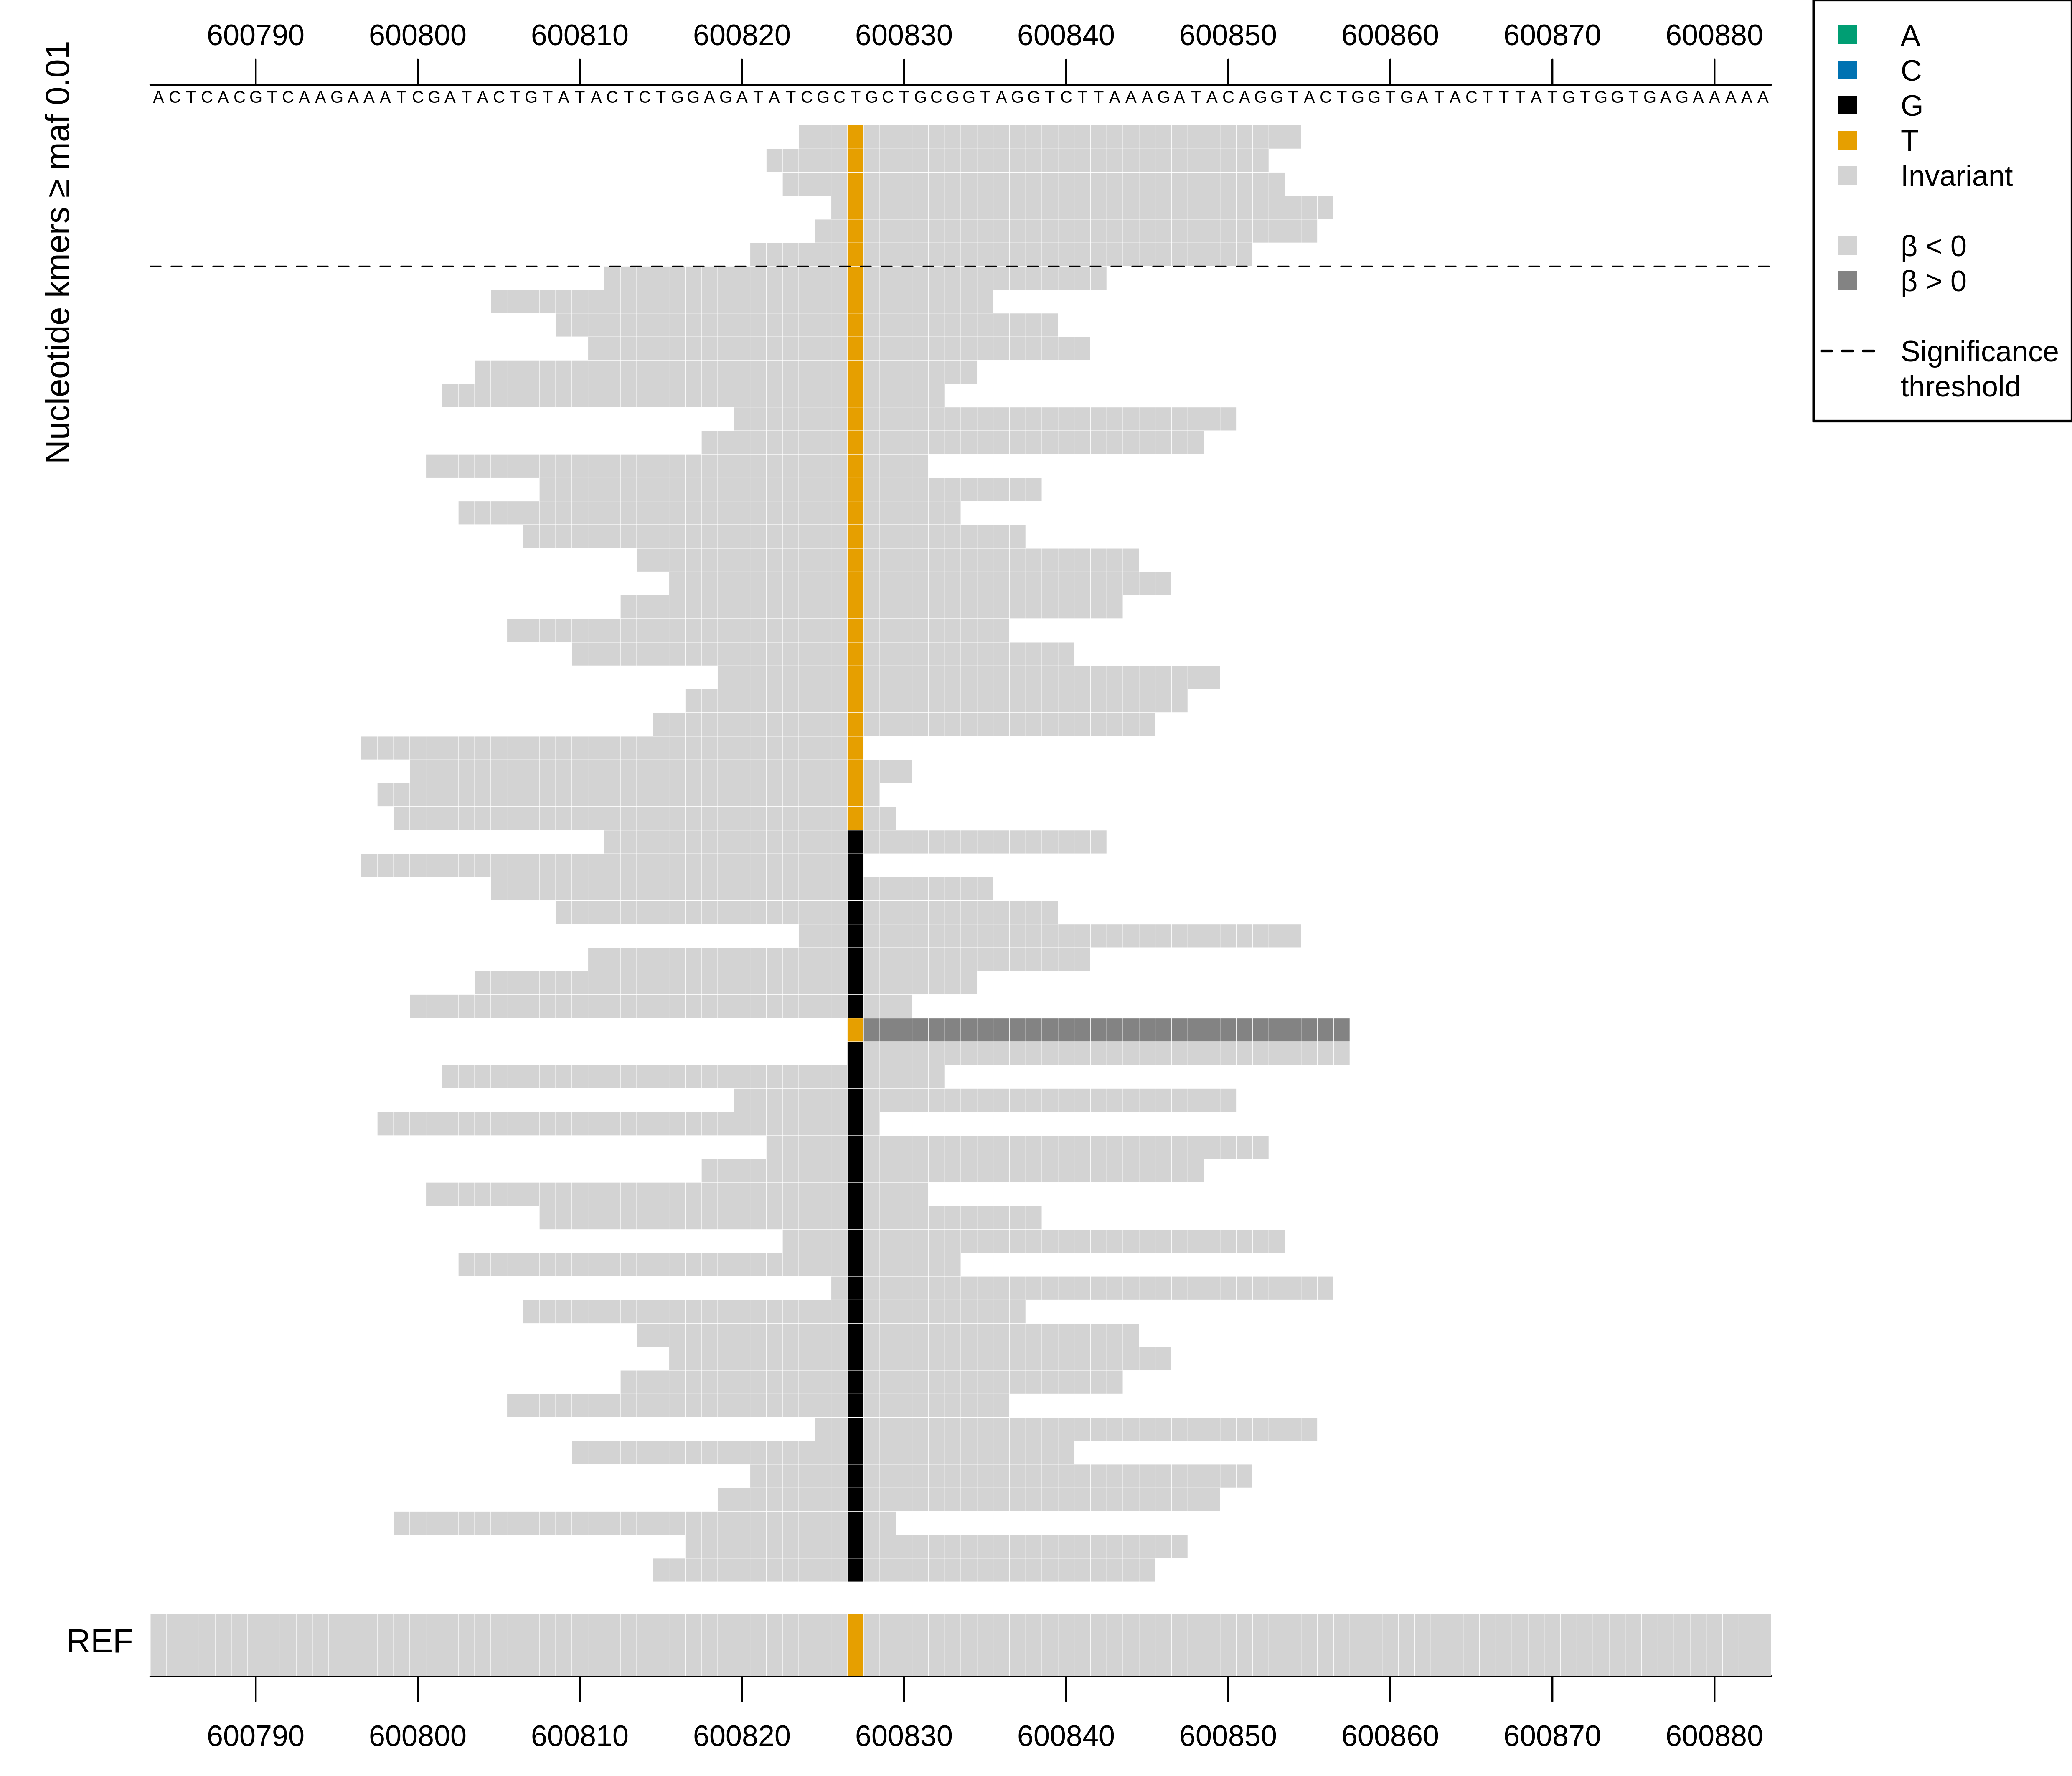

/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_fus_plot_54_pos_600824_to_600923_maf0.01_alignment.png


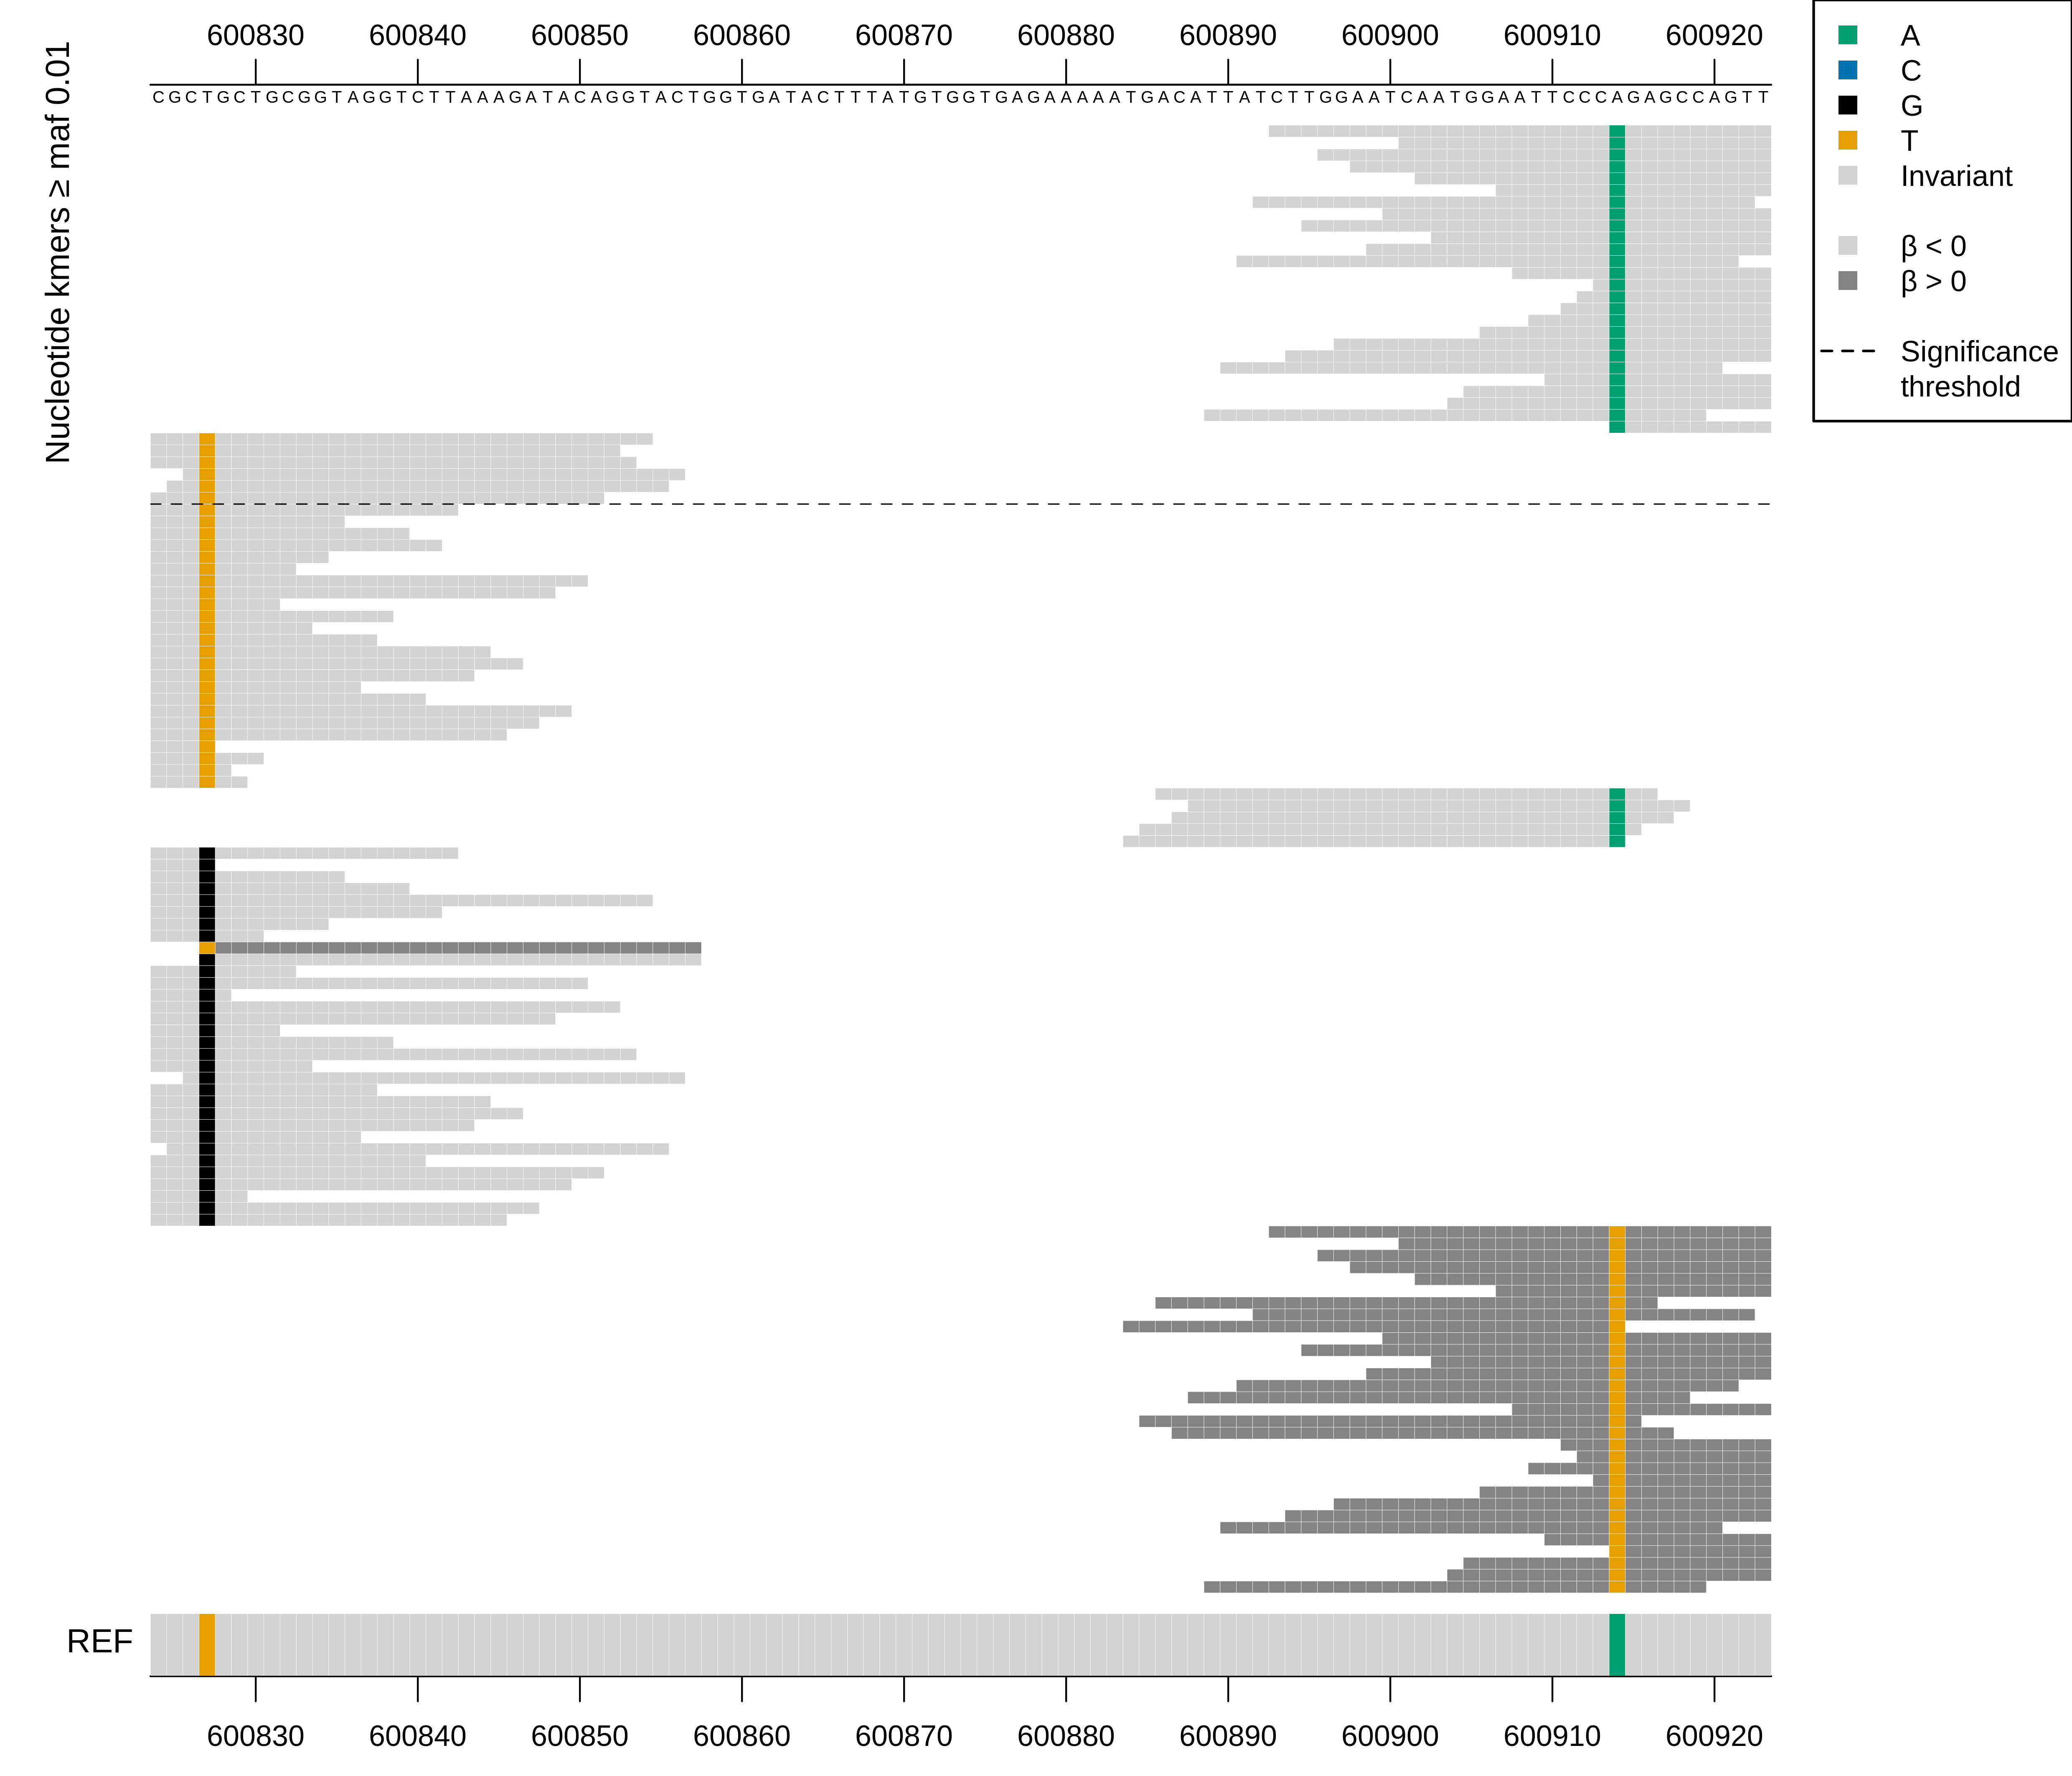

/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_fus_plot_55_pos_600864_to_600963_maf0.01_alignment.png


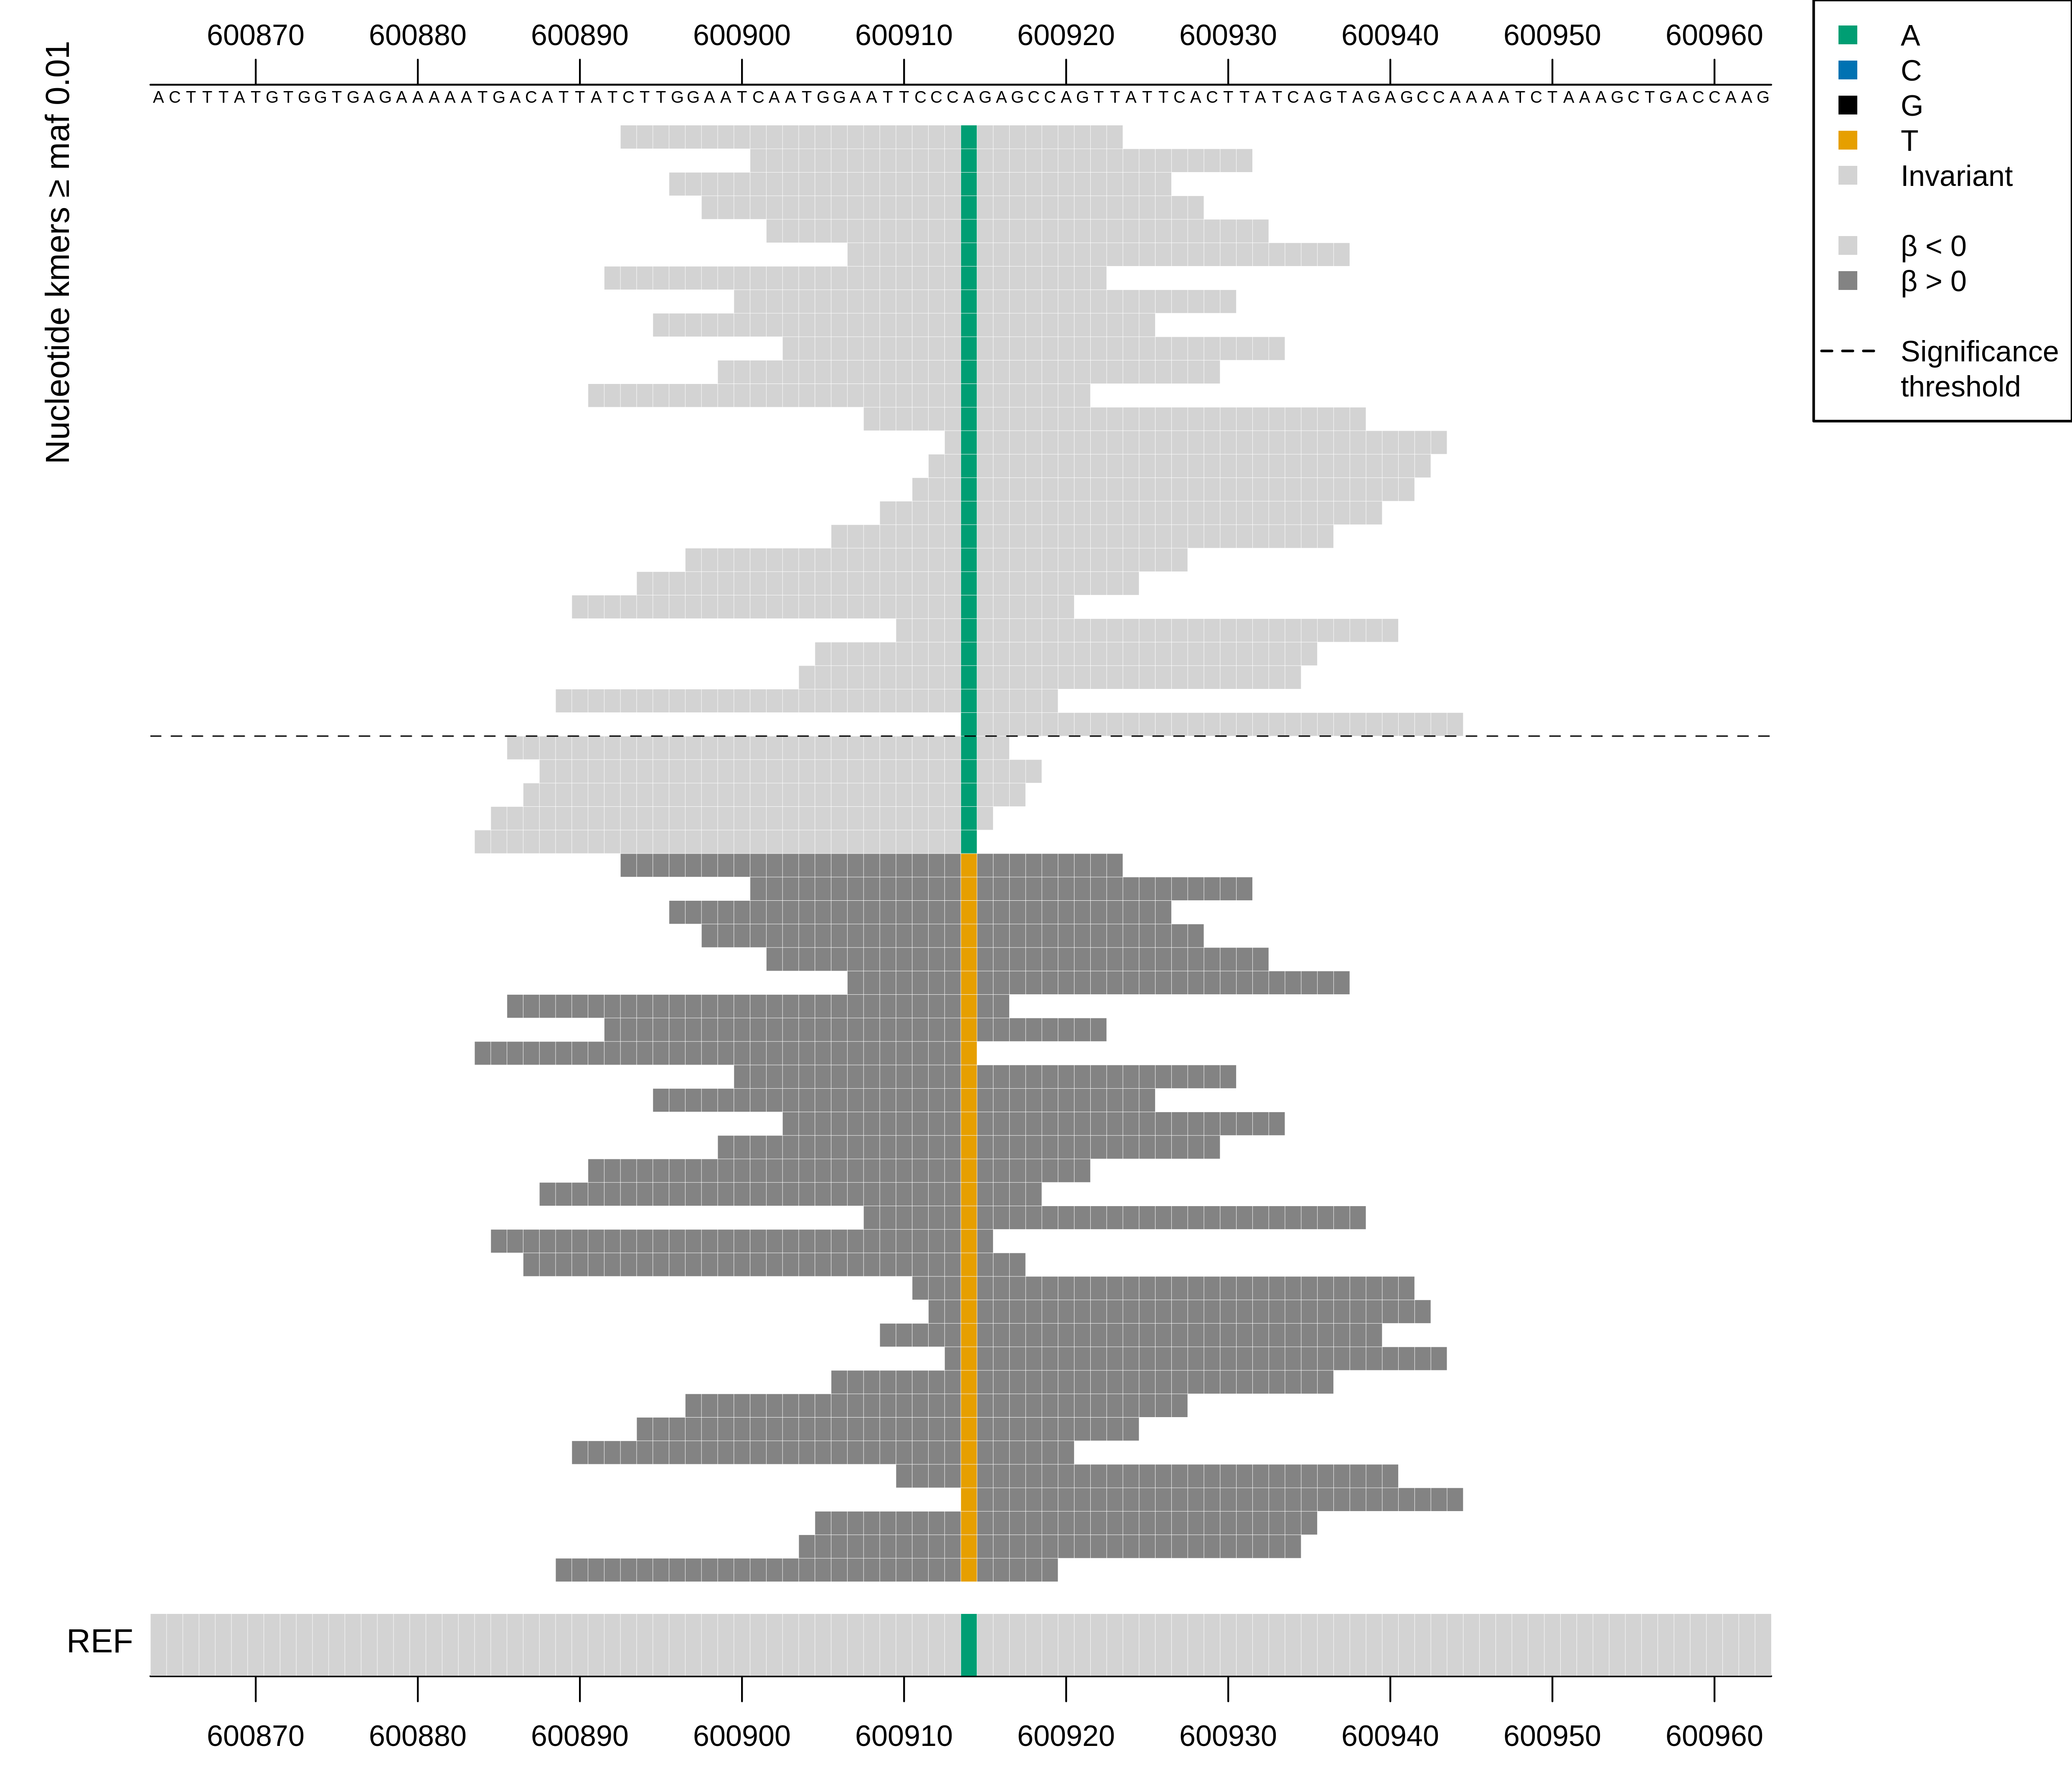

/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_fus_plot_56_pos_600904_to_601003_maf0.01_alignment.png


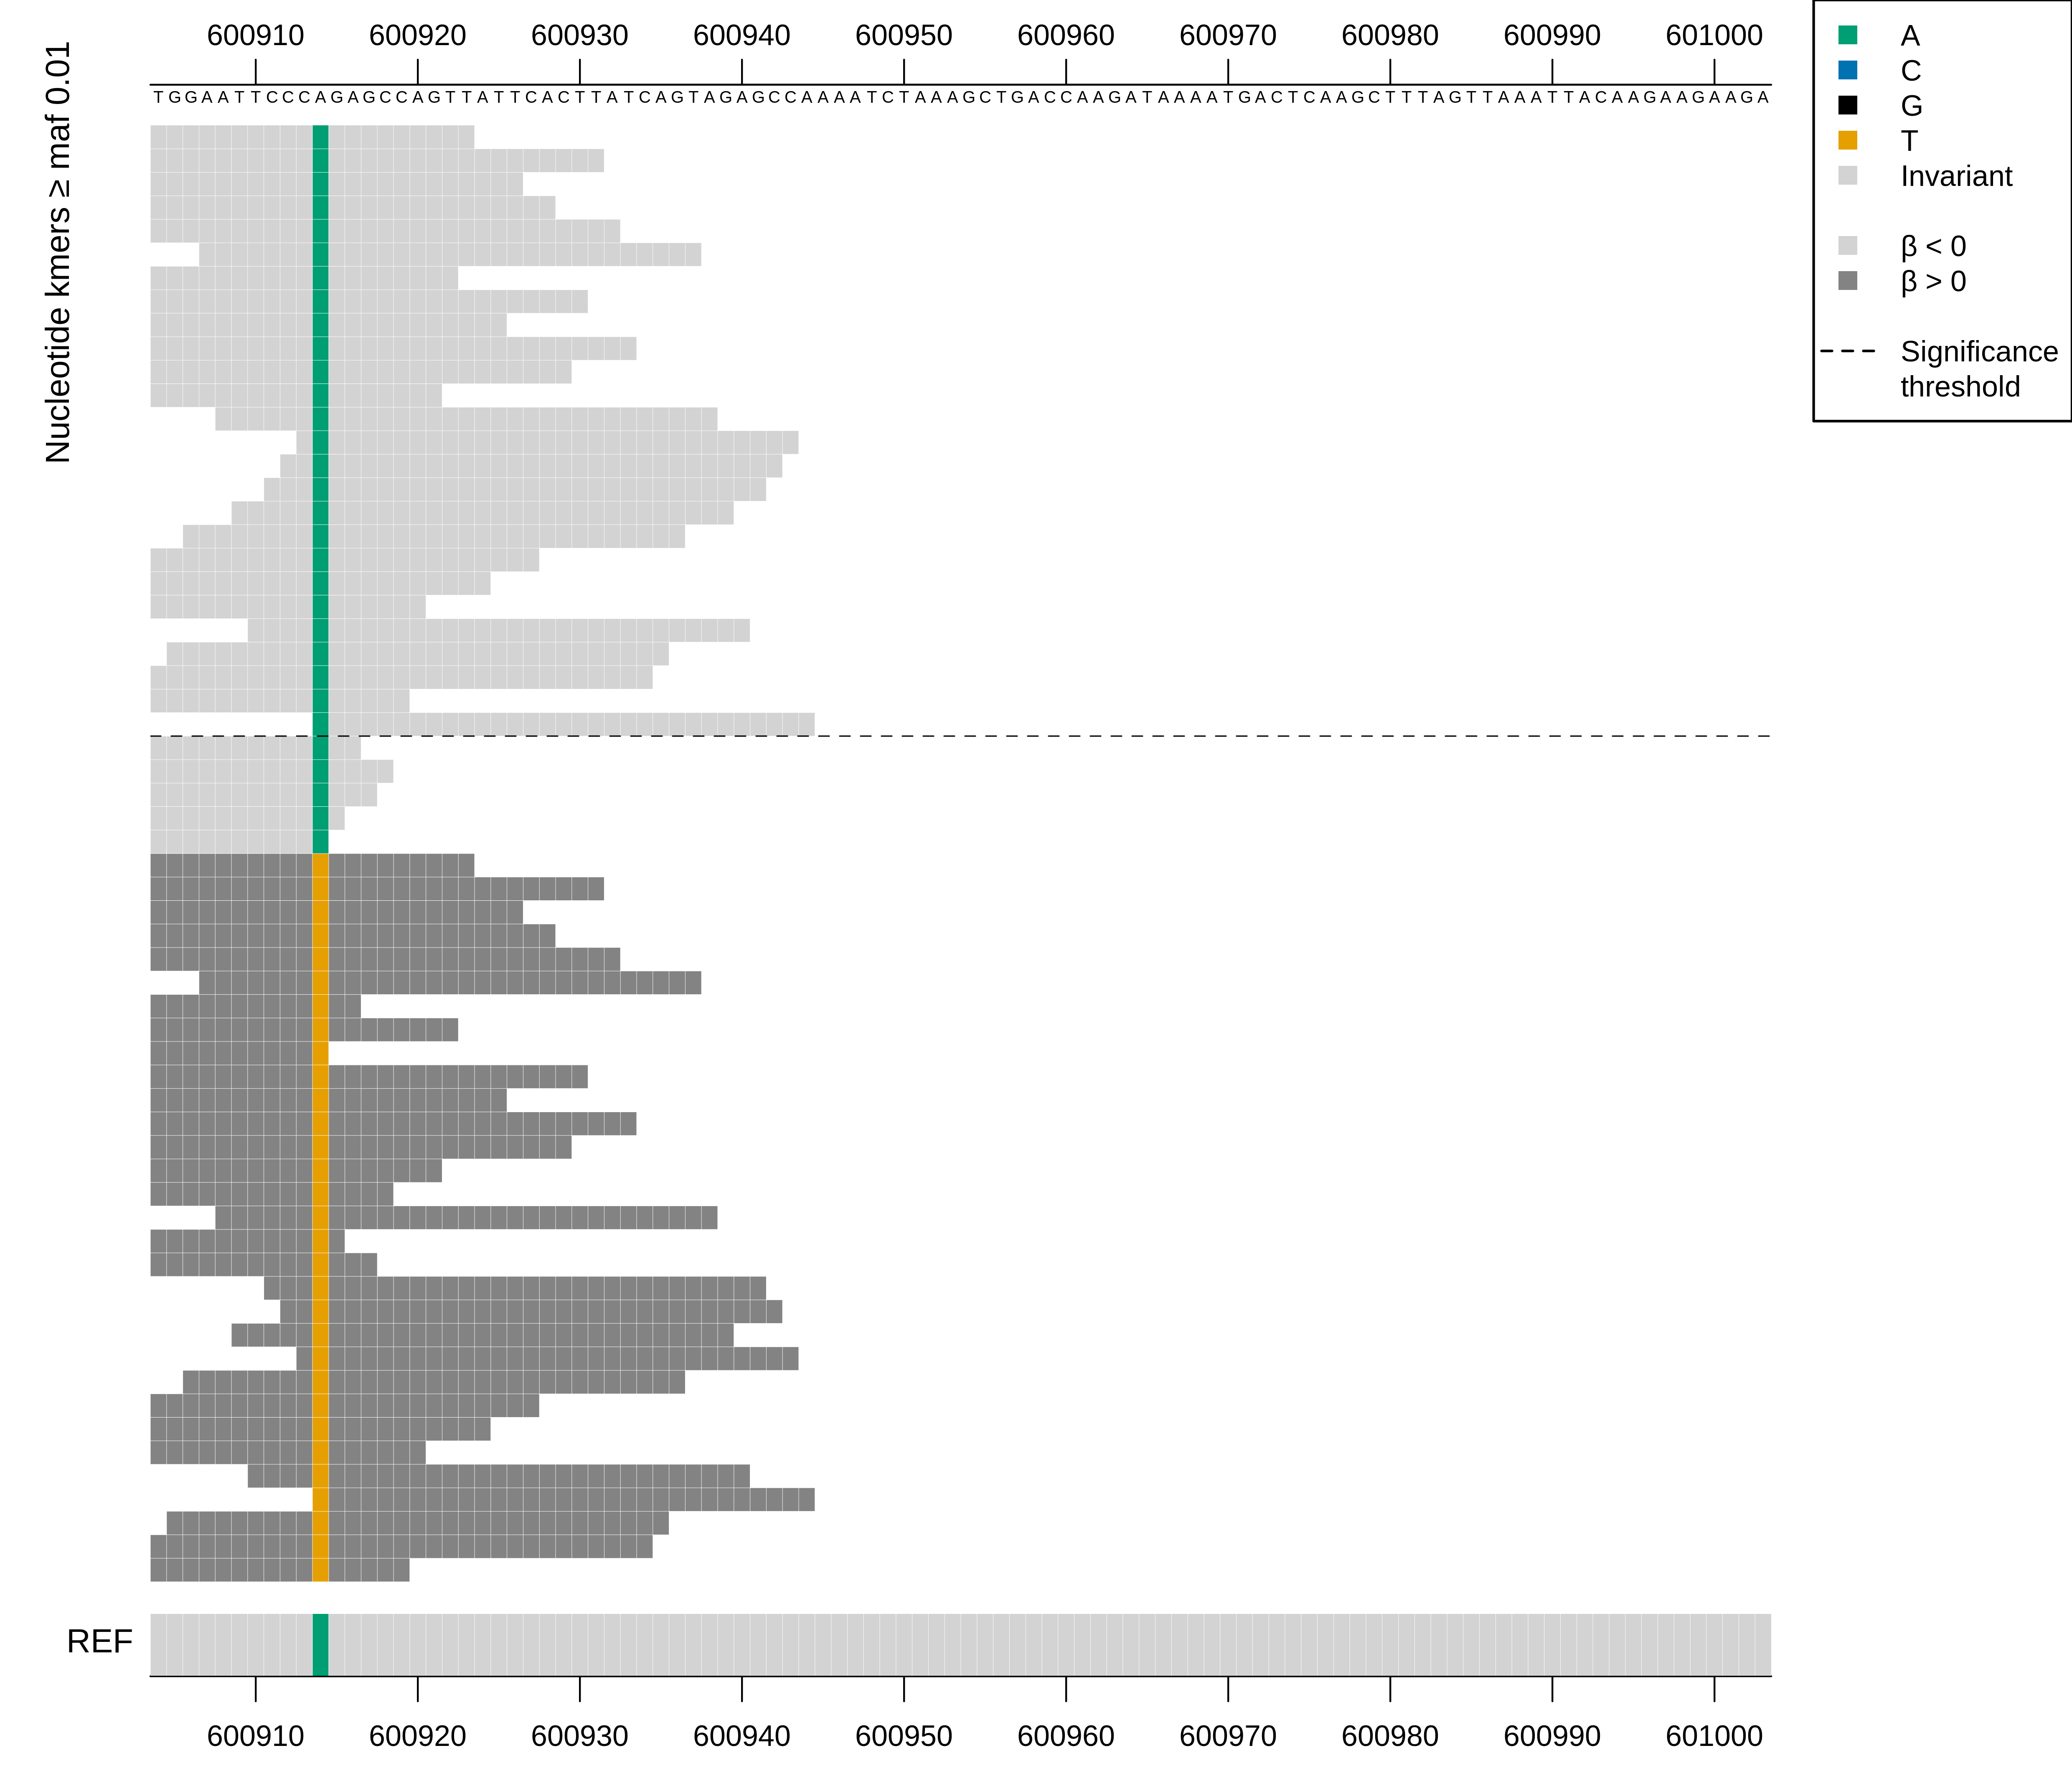

/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_fus_plot_57_pos_600944_to_601043_maf0.01_alignment.png


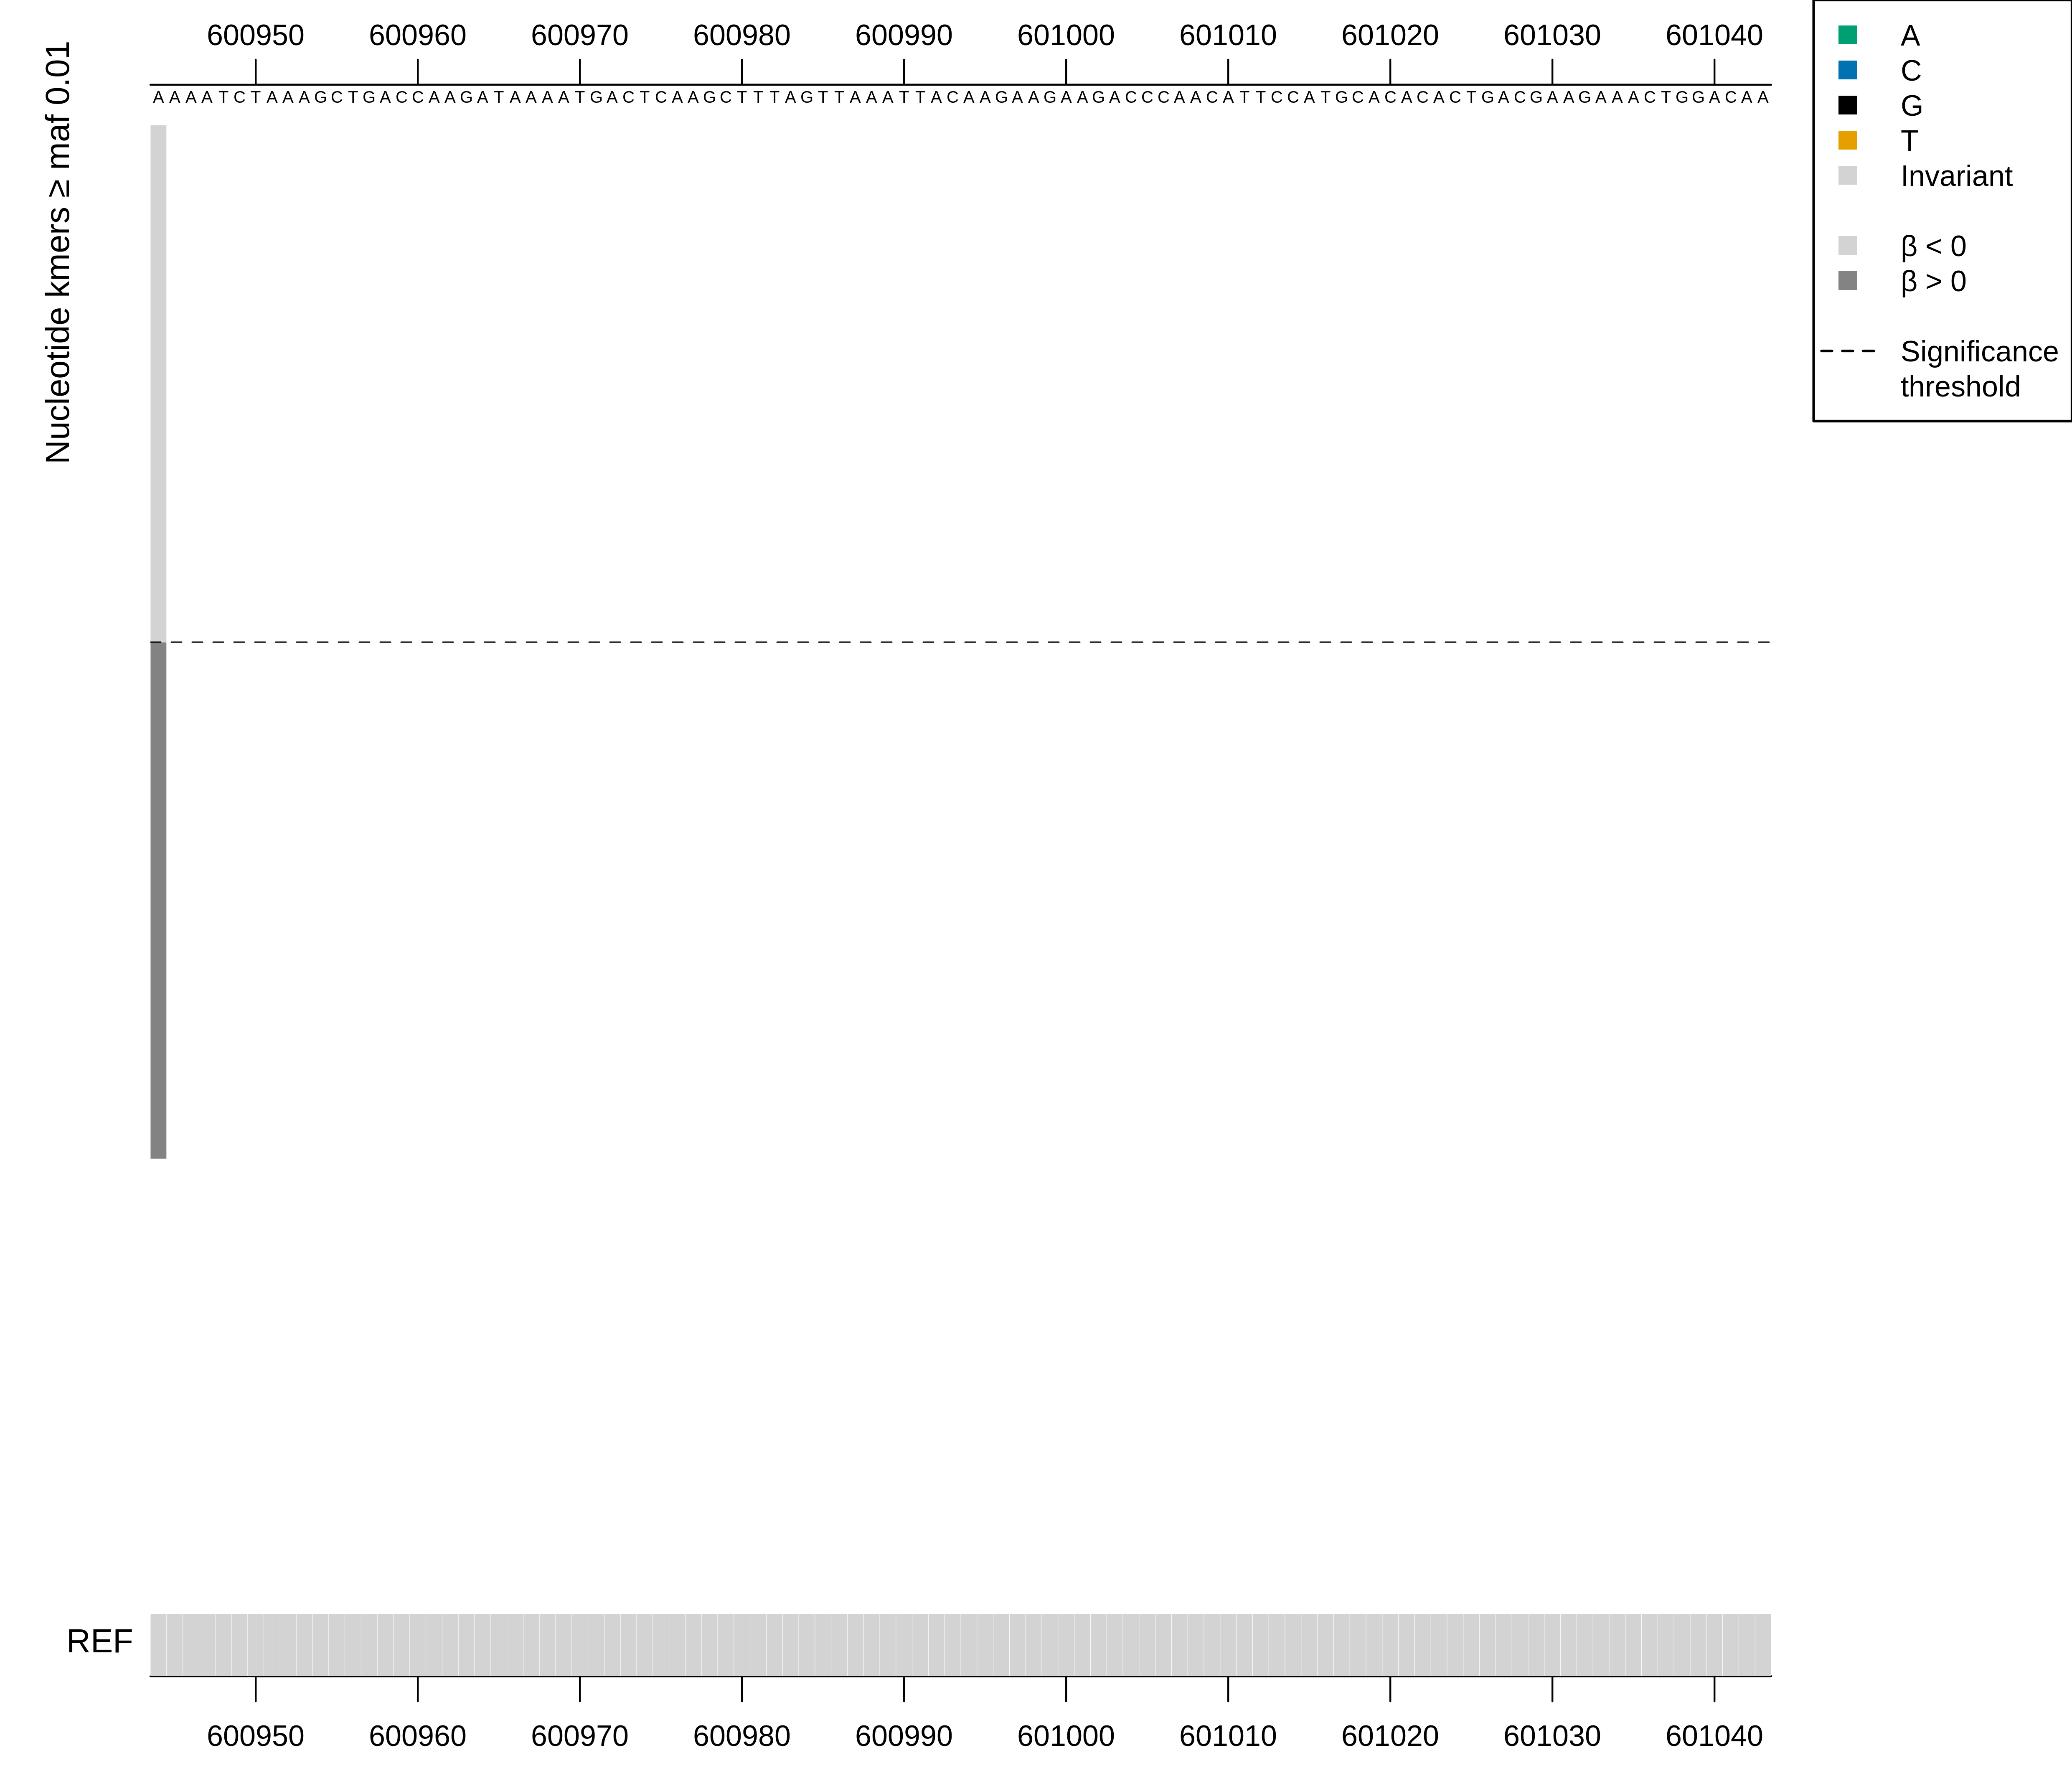

/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_fus_plot_58_pos_600984_to_601083_maf0.01_alignment.png


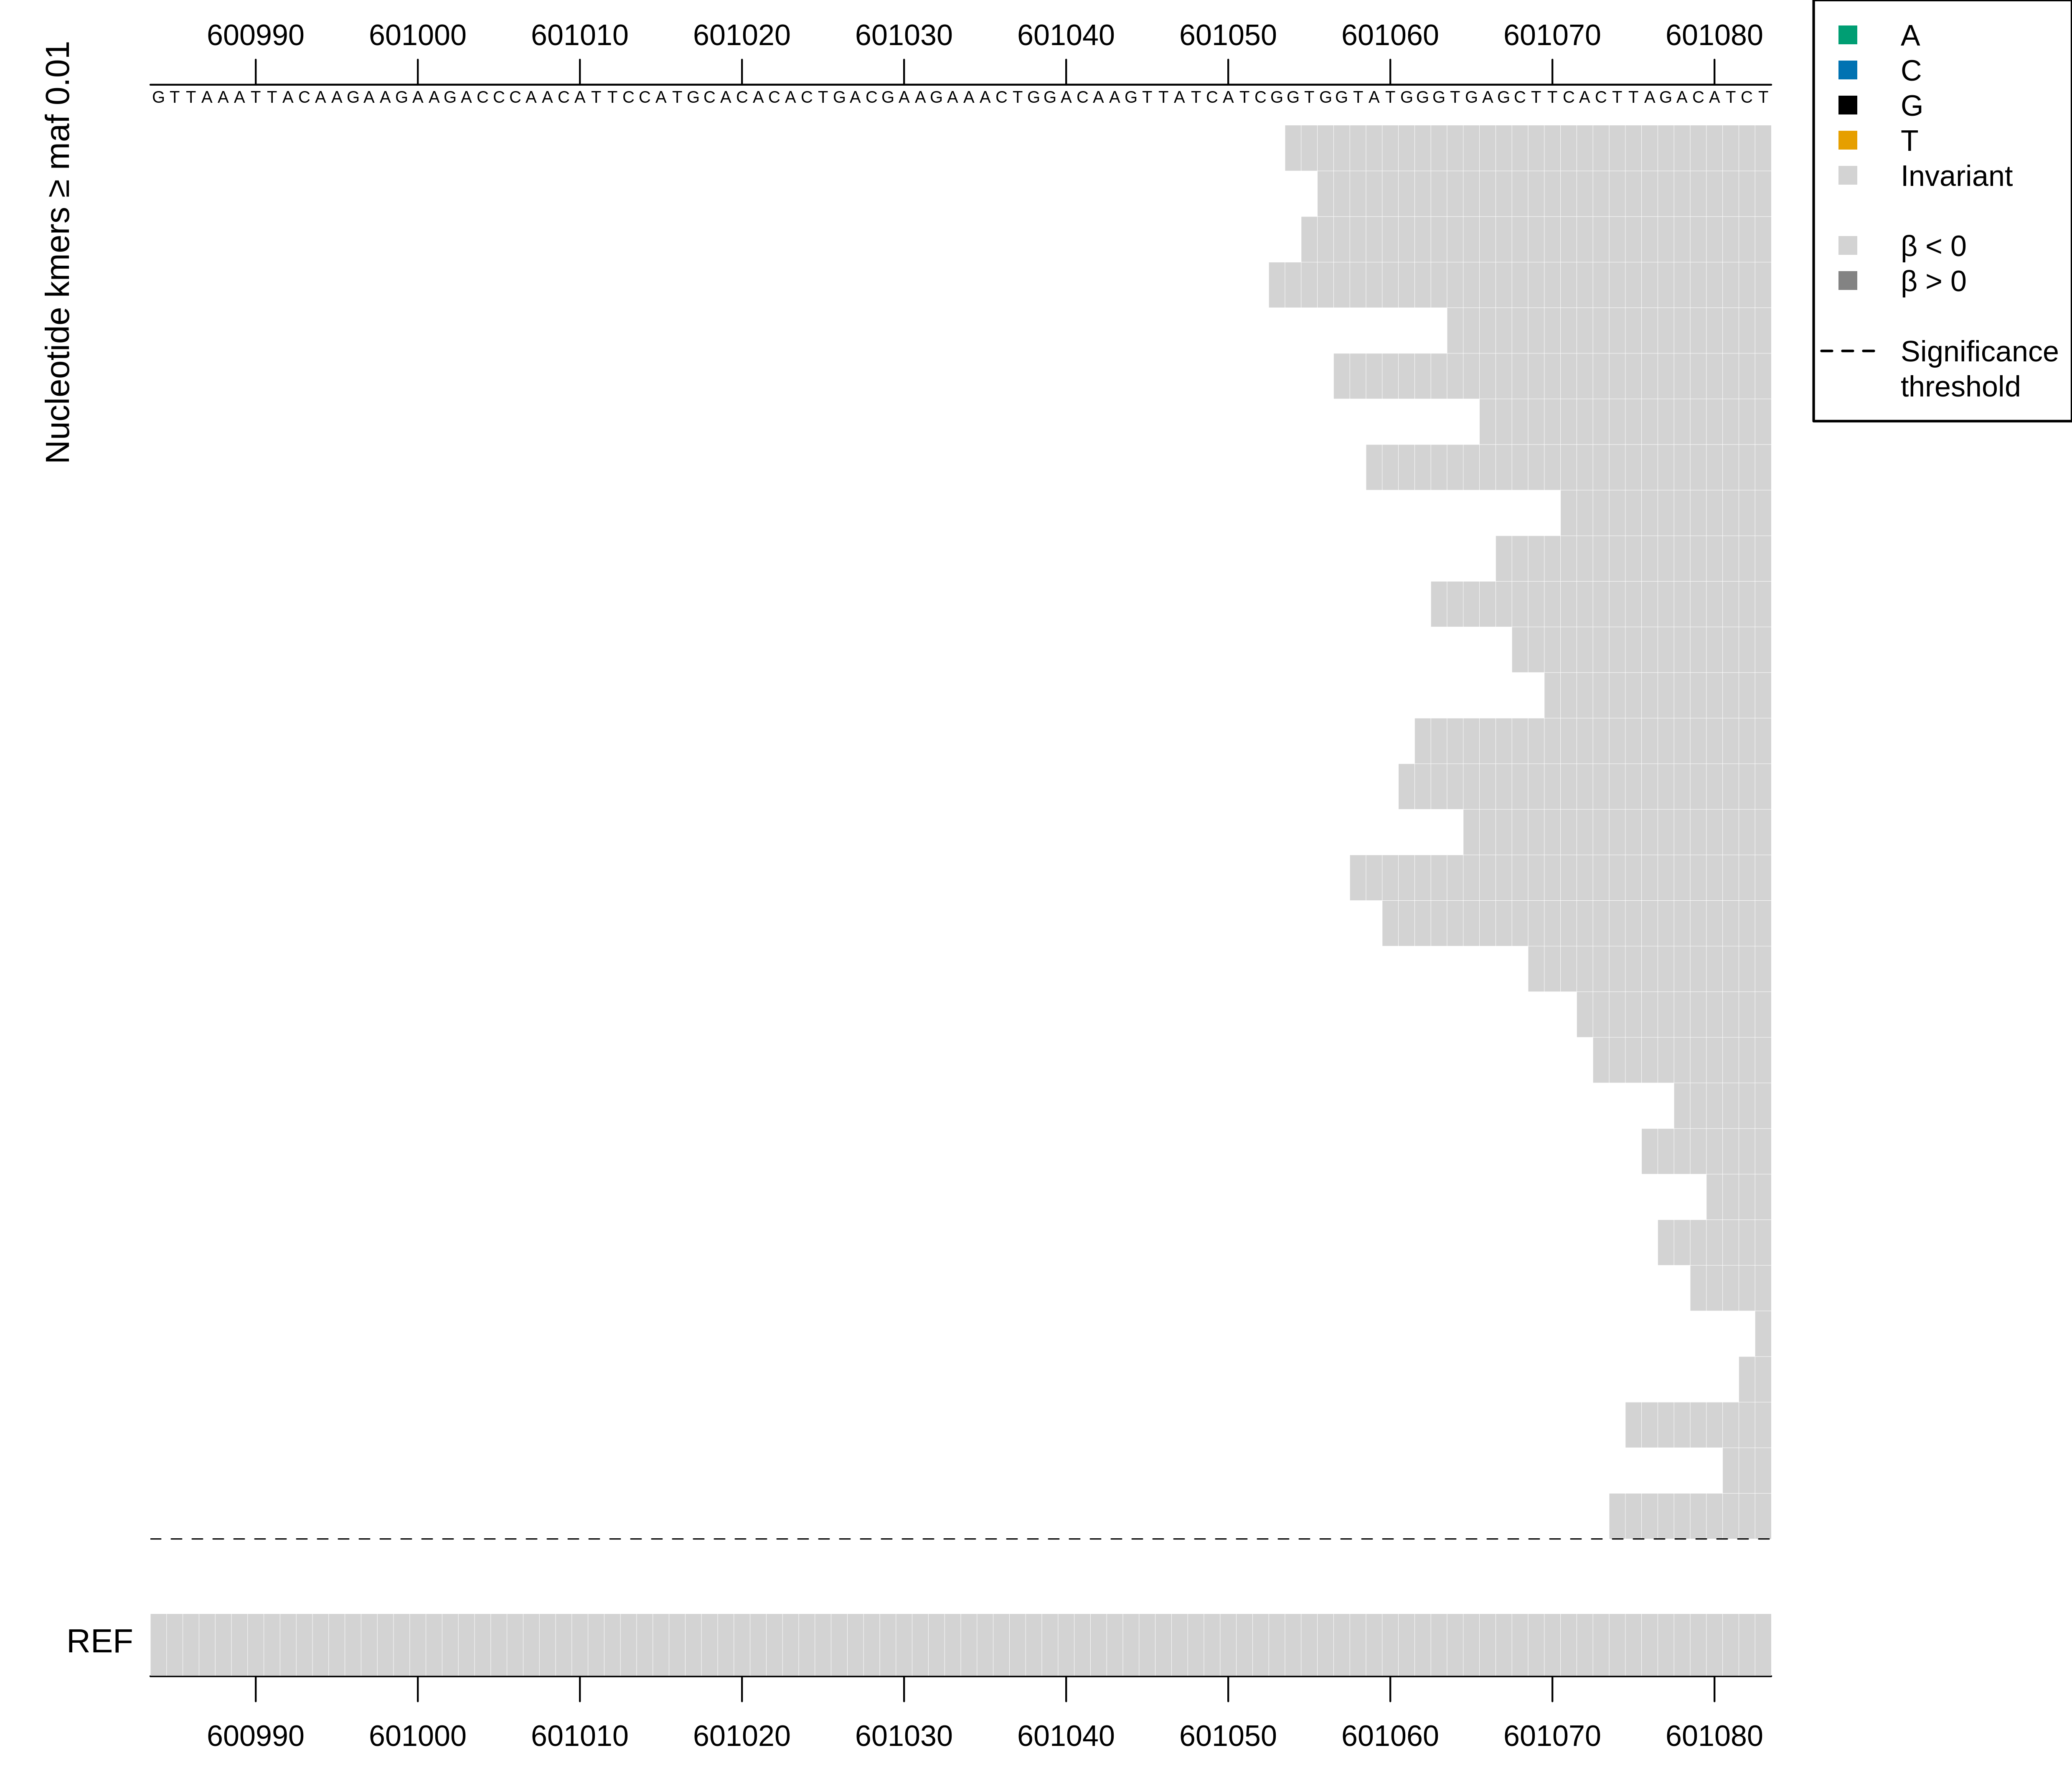

/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_fus_plot_59_pos_601024_to_601123_maf0.01_alignment.png


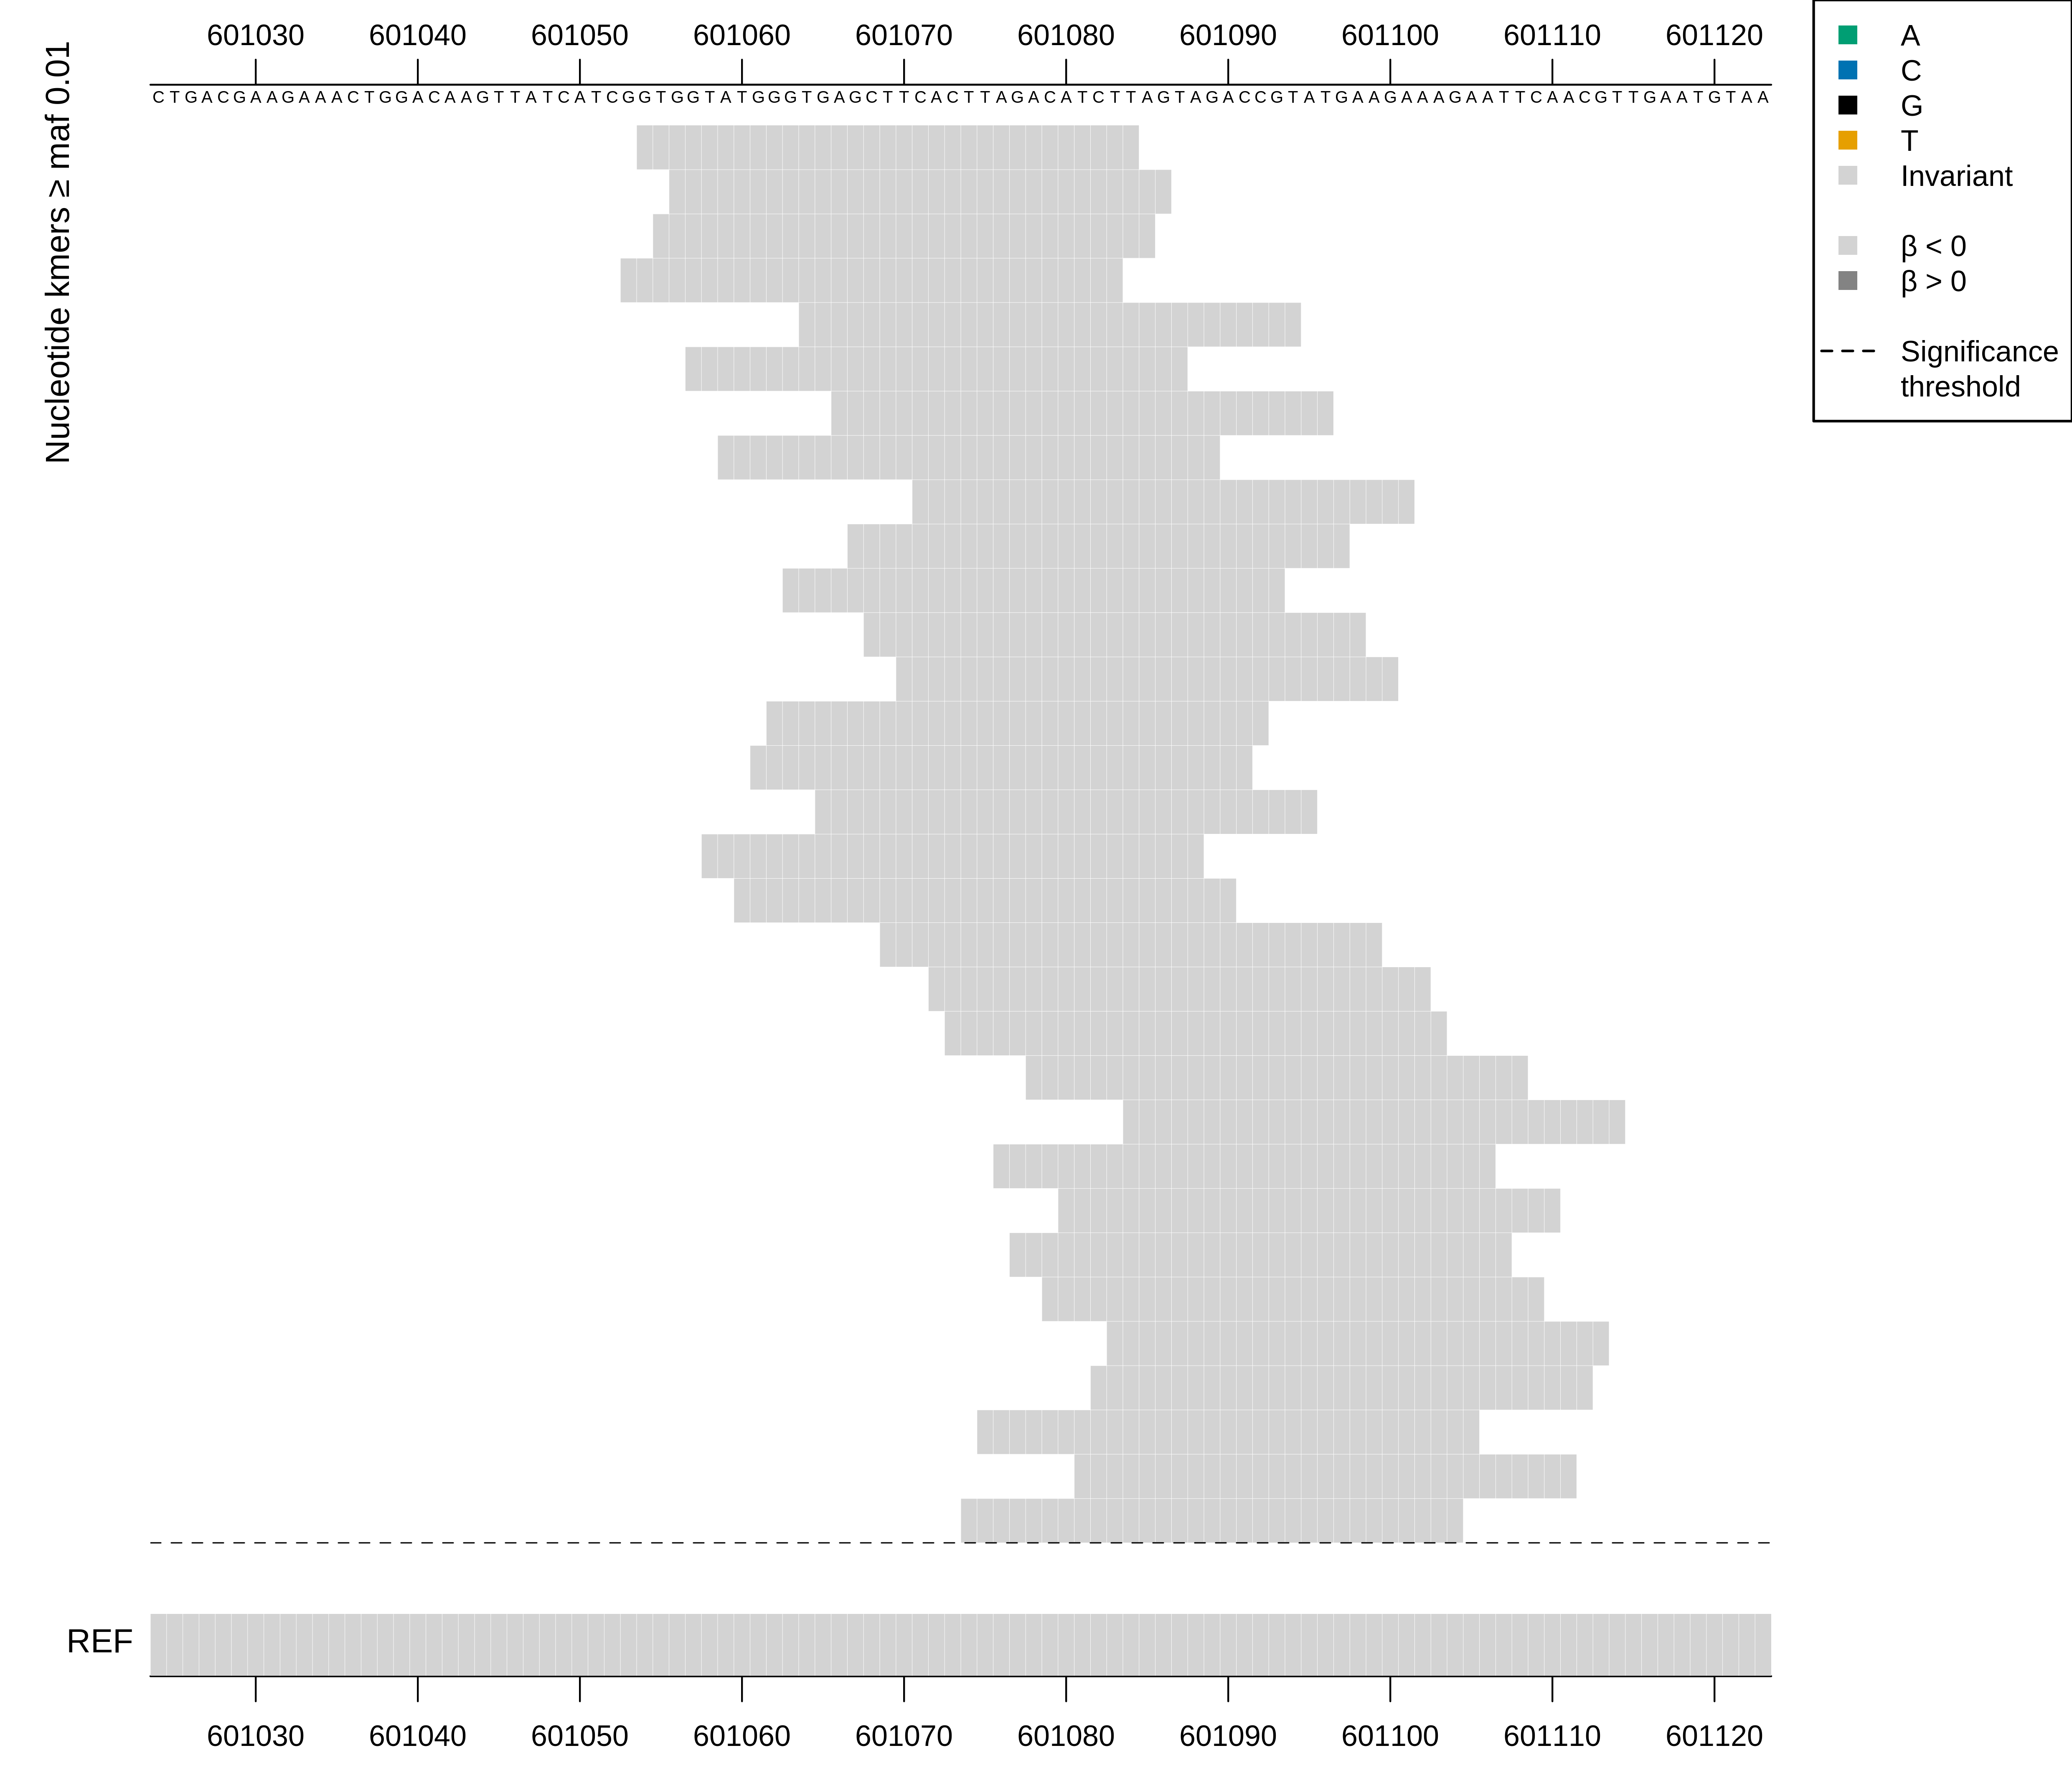

/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_fus_plot_60_pos_601064_to_601163_maf0.01_alignment.png


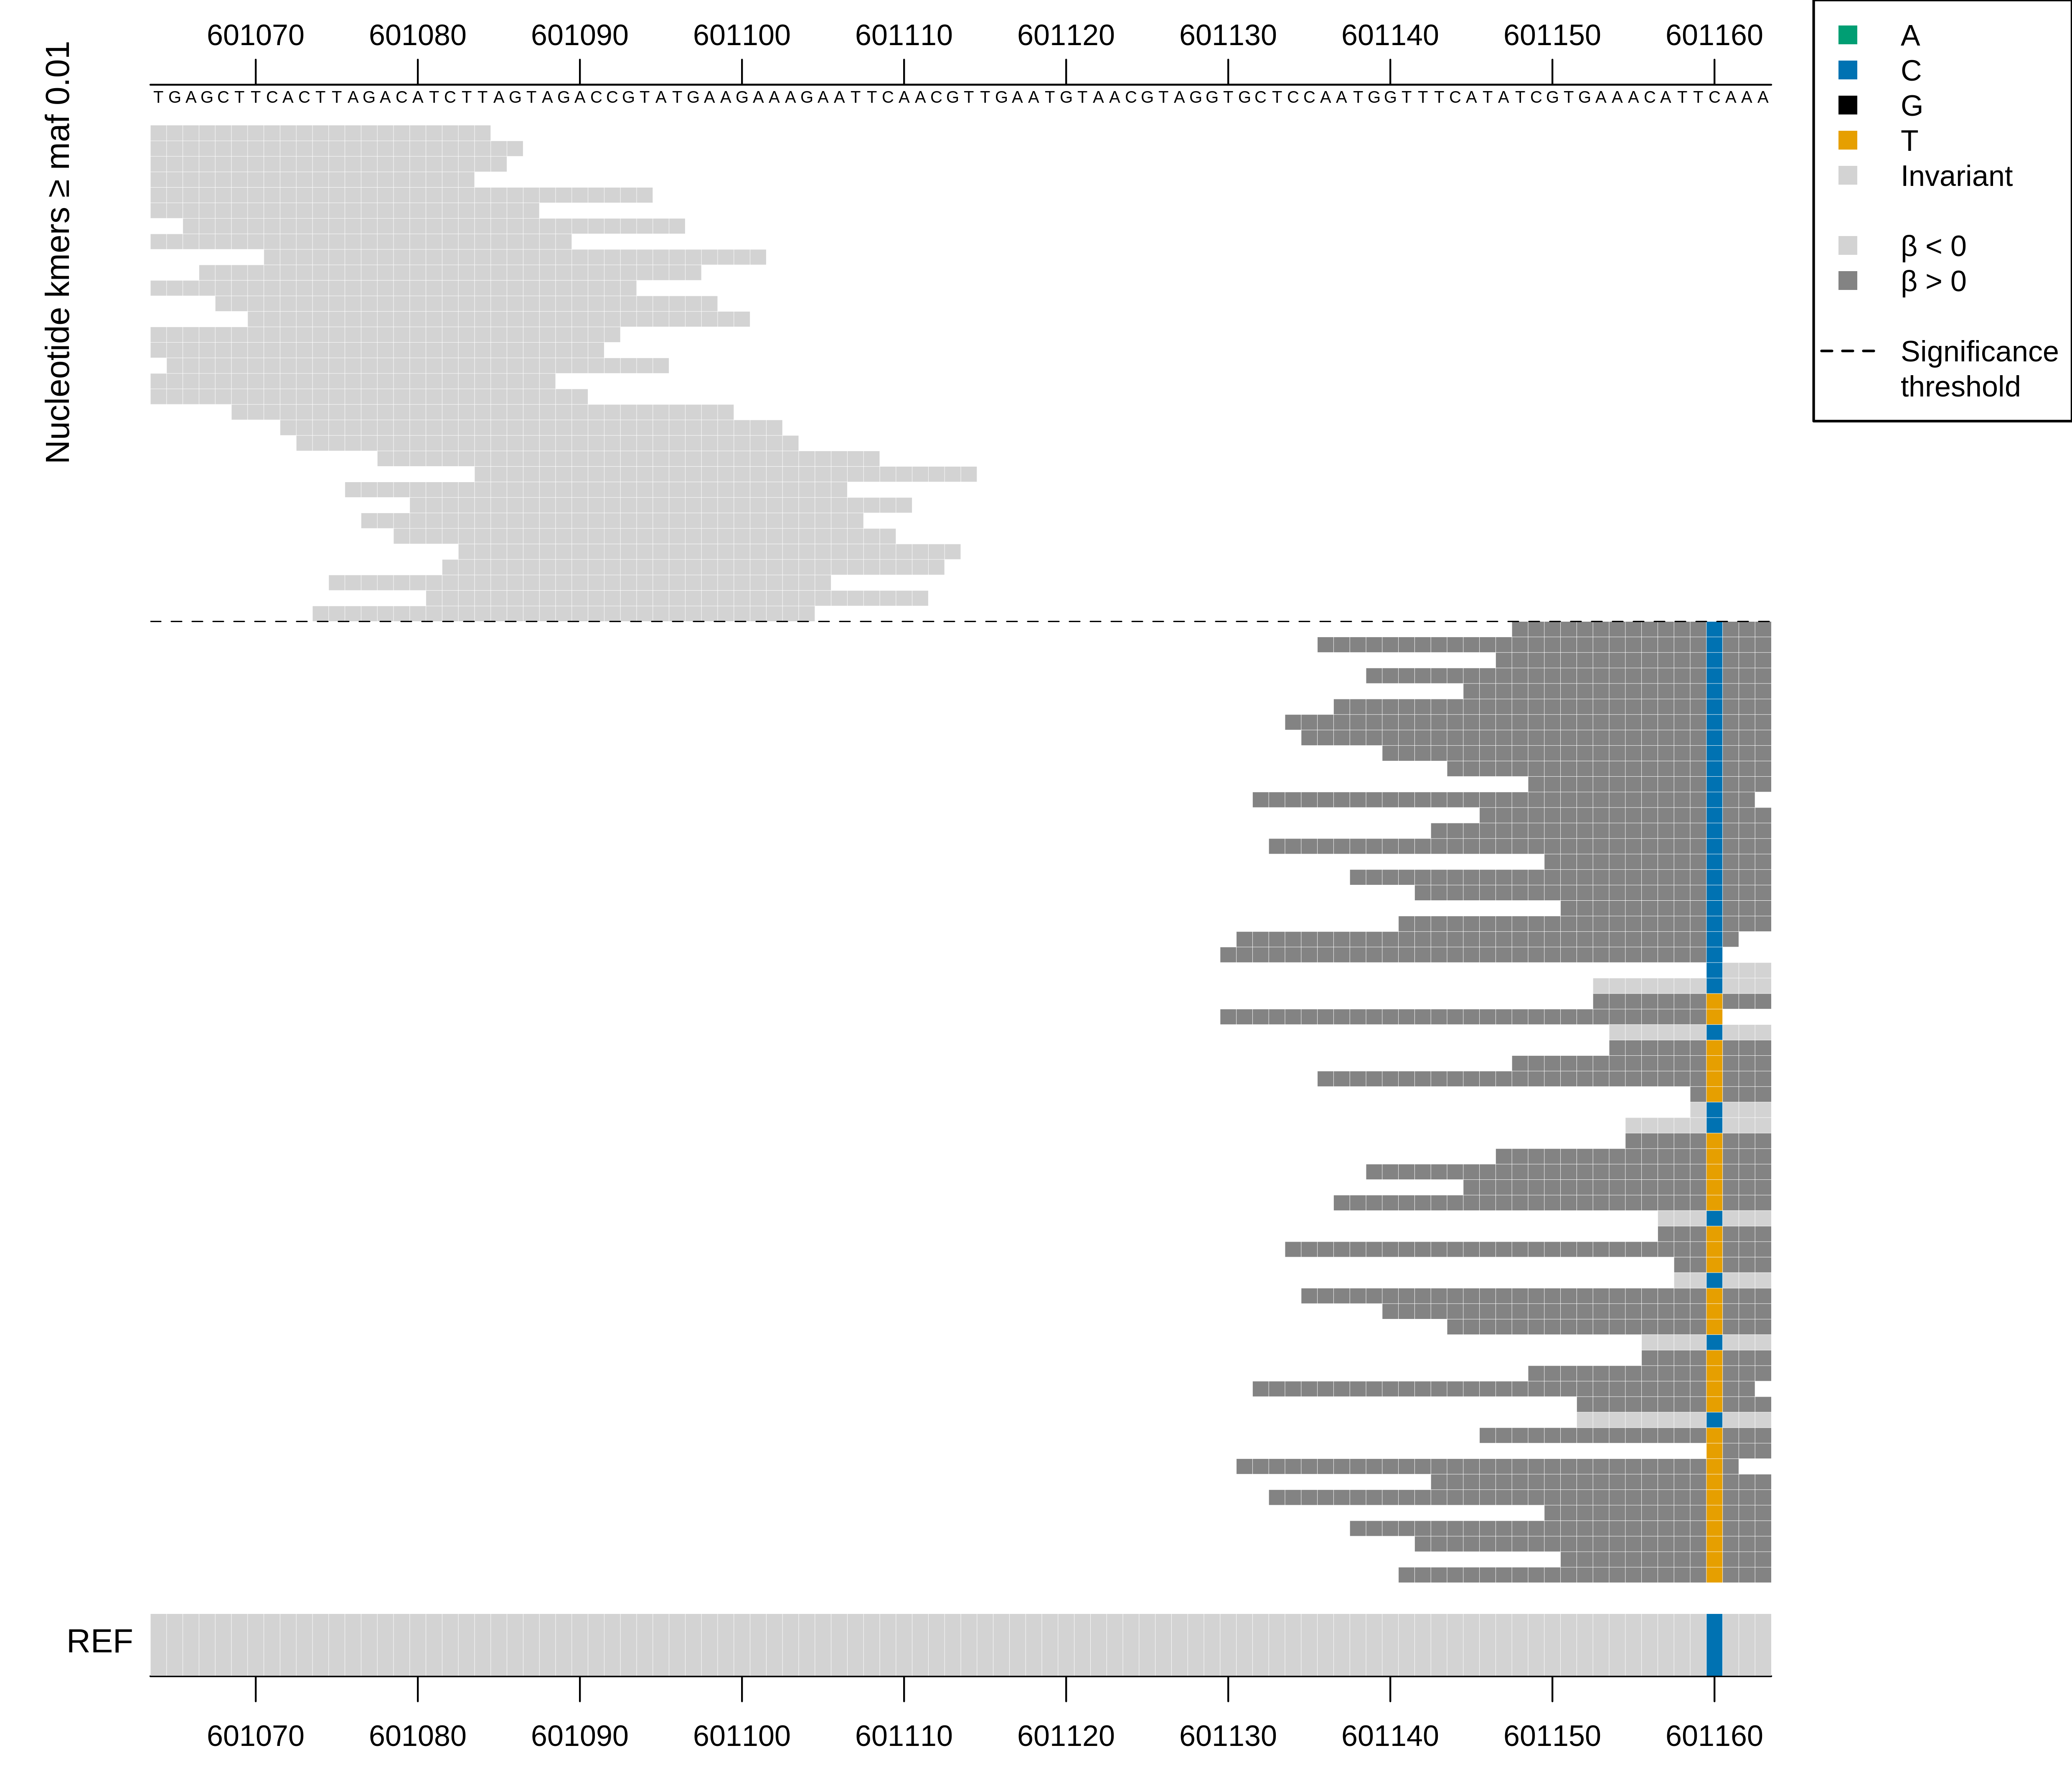

/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_fus_plot_61_pos_601104_to_601203_maf0.01_alignment.png


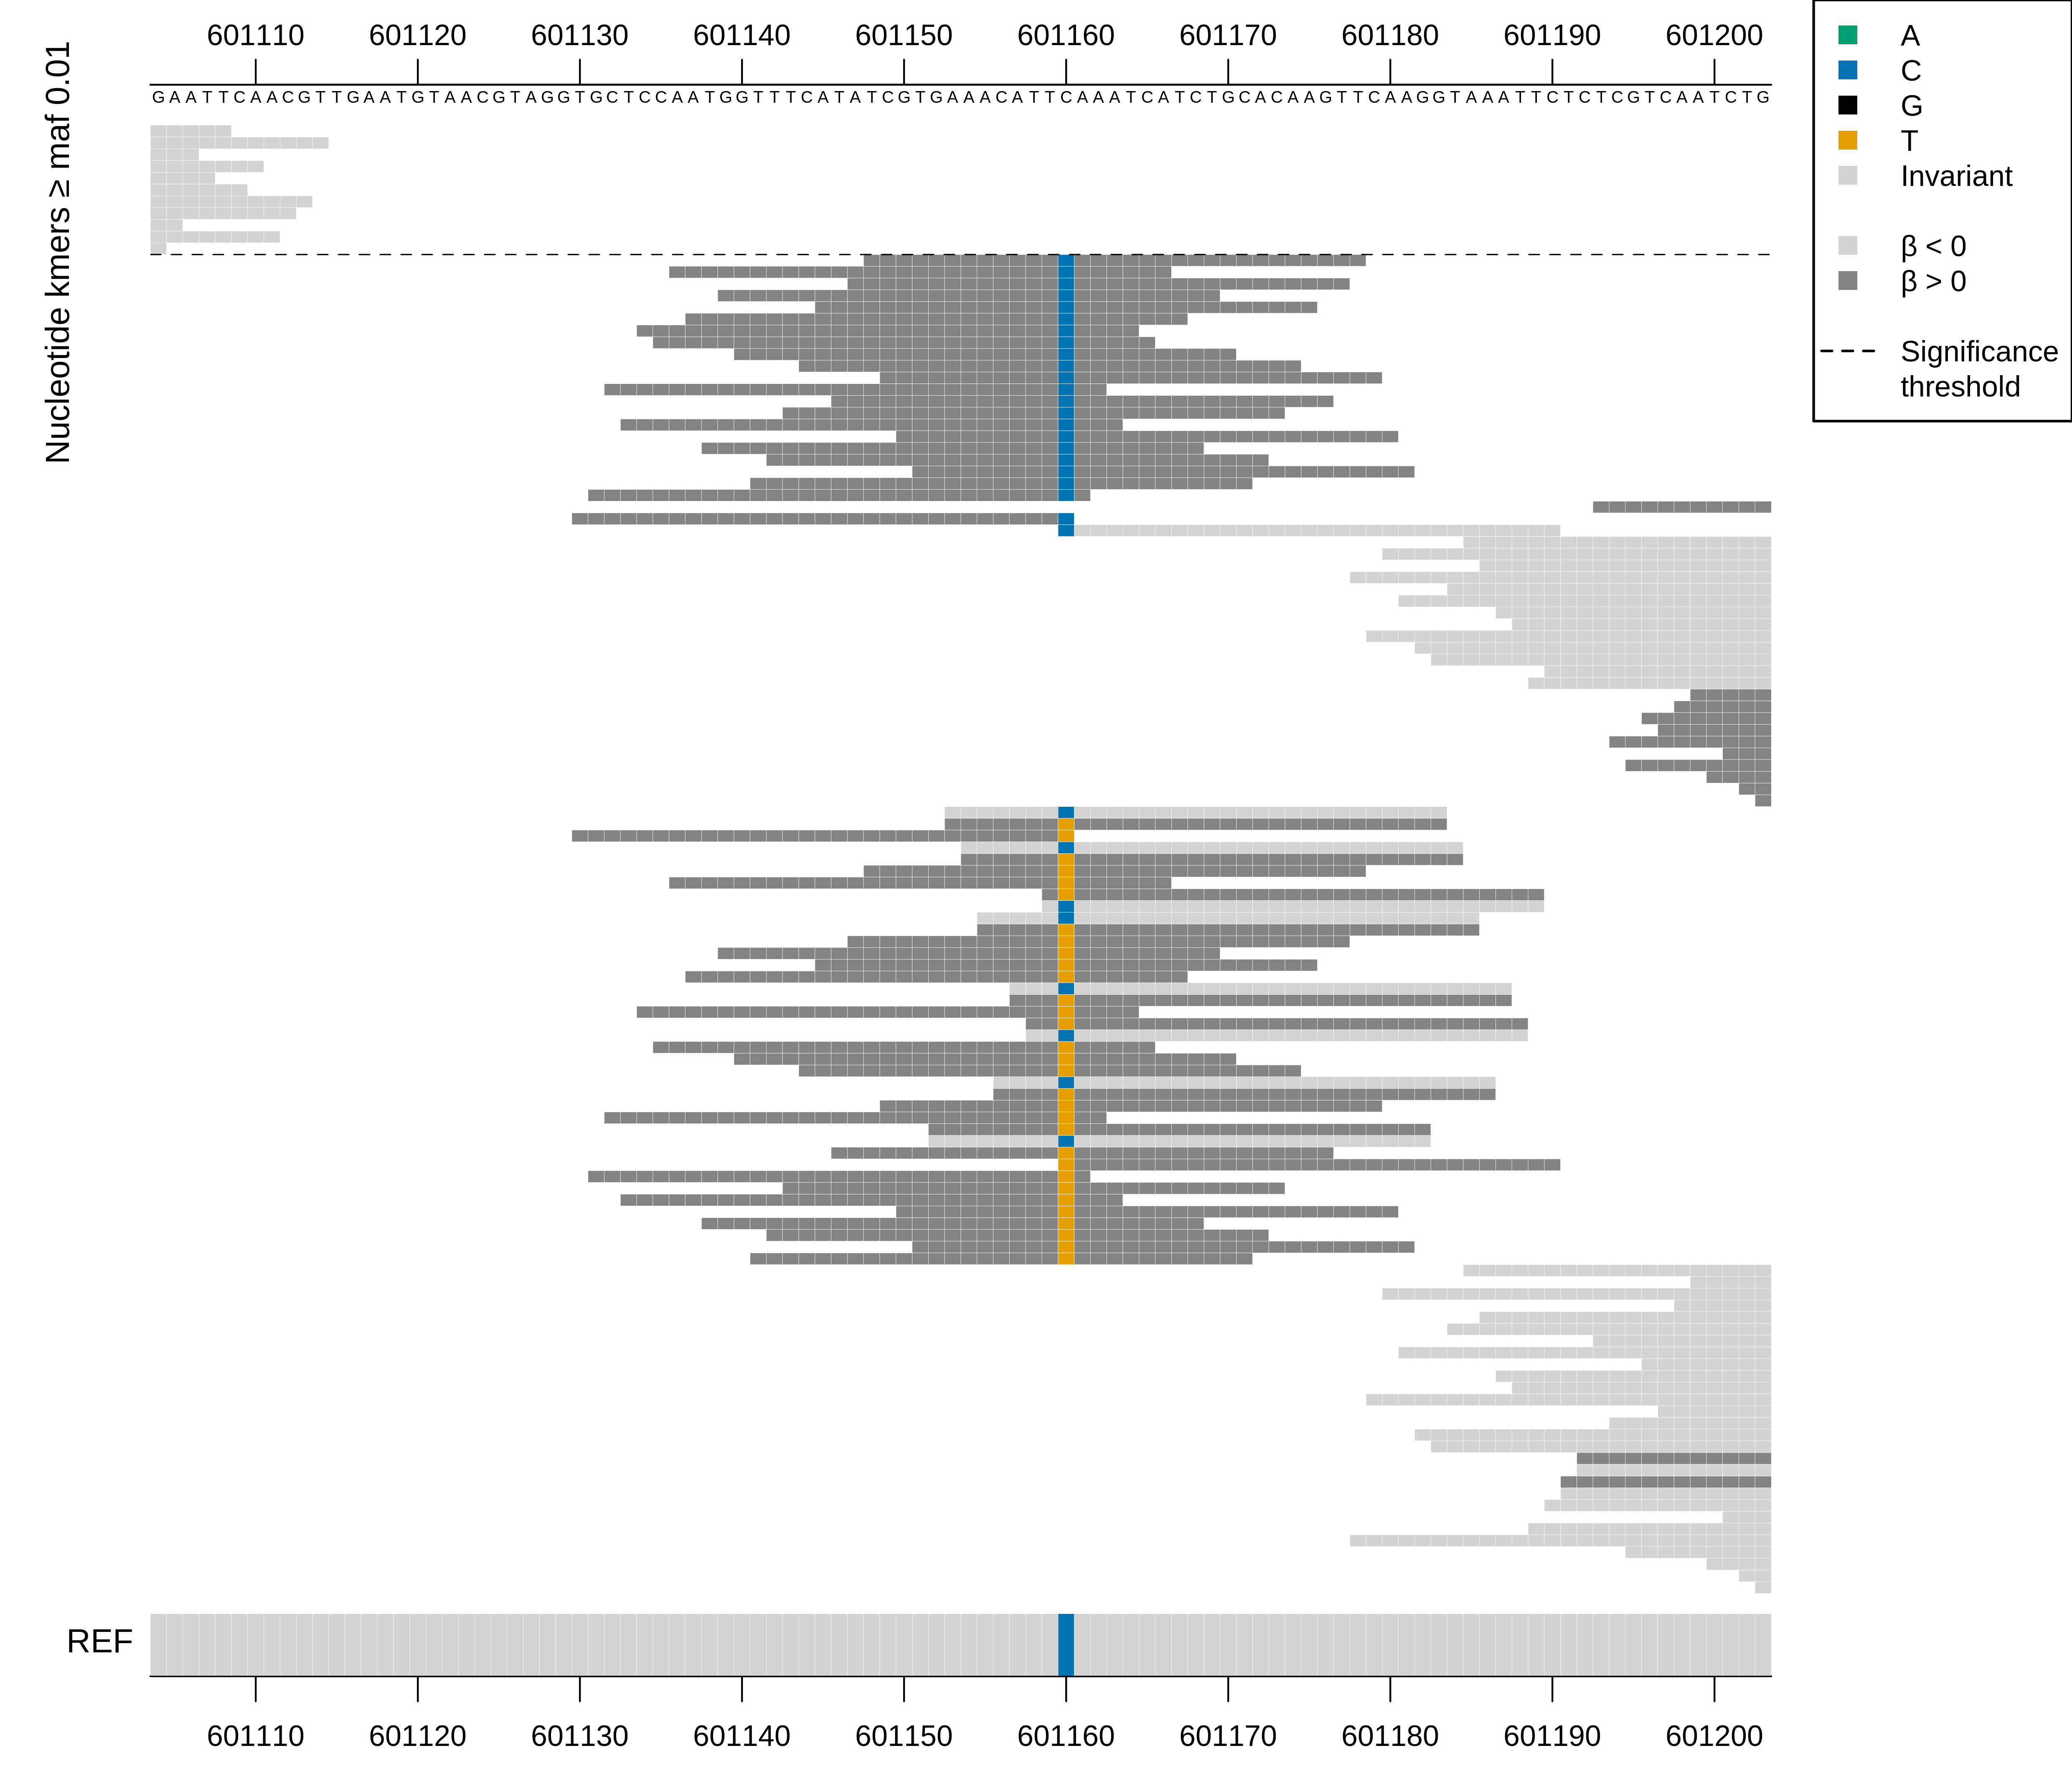

In [11]:
GENE='fus'
FIGLAB='*'+GENE+'_*maf0.01_alignment.png'
print('\n'+FIGDIR+FIGLAB+'\n')
import subprocess
CMD=subprocess.Popen('ls /home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_*fus_*maf0.01_alignment.png',shell=True,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
FILES, ERR = CMD.communicate()
FILES=FILES.decode().splitlines()
for FILE in FILES:
    print(FILE)
    display(Image(FILE,width=300))

These figures offer a high resolution view but require careful interpretation.

Often there are a series of overlapping windows that capture a region of elevated significance. The aim is to understand the nature of the variation that the kmers are capturing and which is driving the signal of association.

Kmers are shaded by direction of effect. Variable nucleotides within the kmers are coloured. Kmers are ordered from more significant (top) to less (bottom). Focus on the significant kmers above the dashed significance threshold.

***The next code block will only work for the worked example.***


/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_fus_plot_55_pos_600864_to_600963_maf0.01_alignment.png



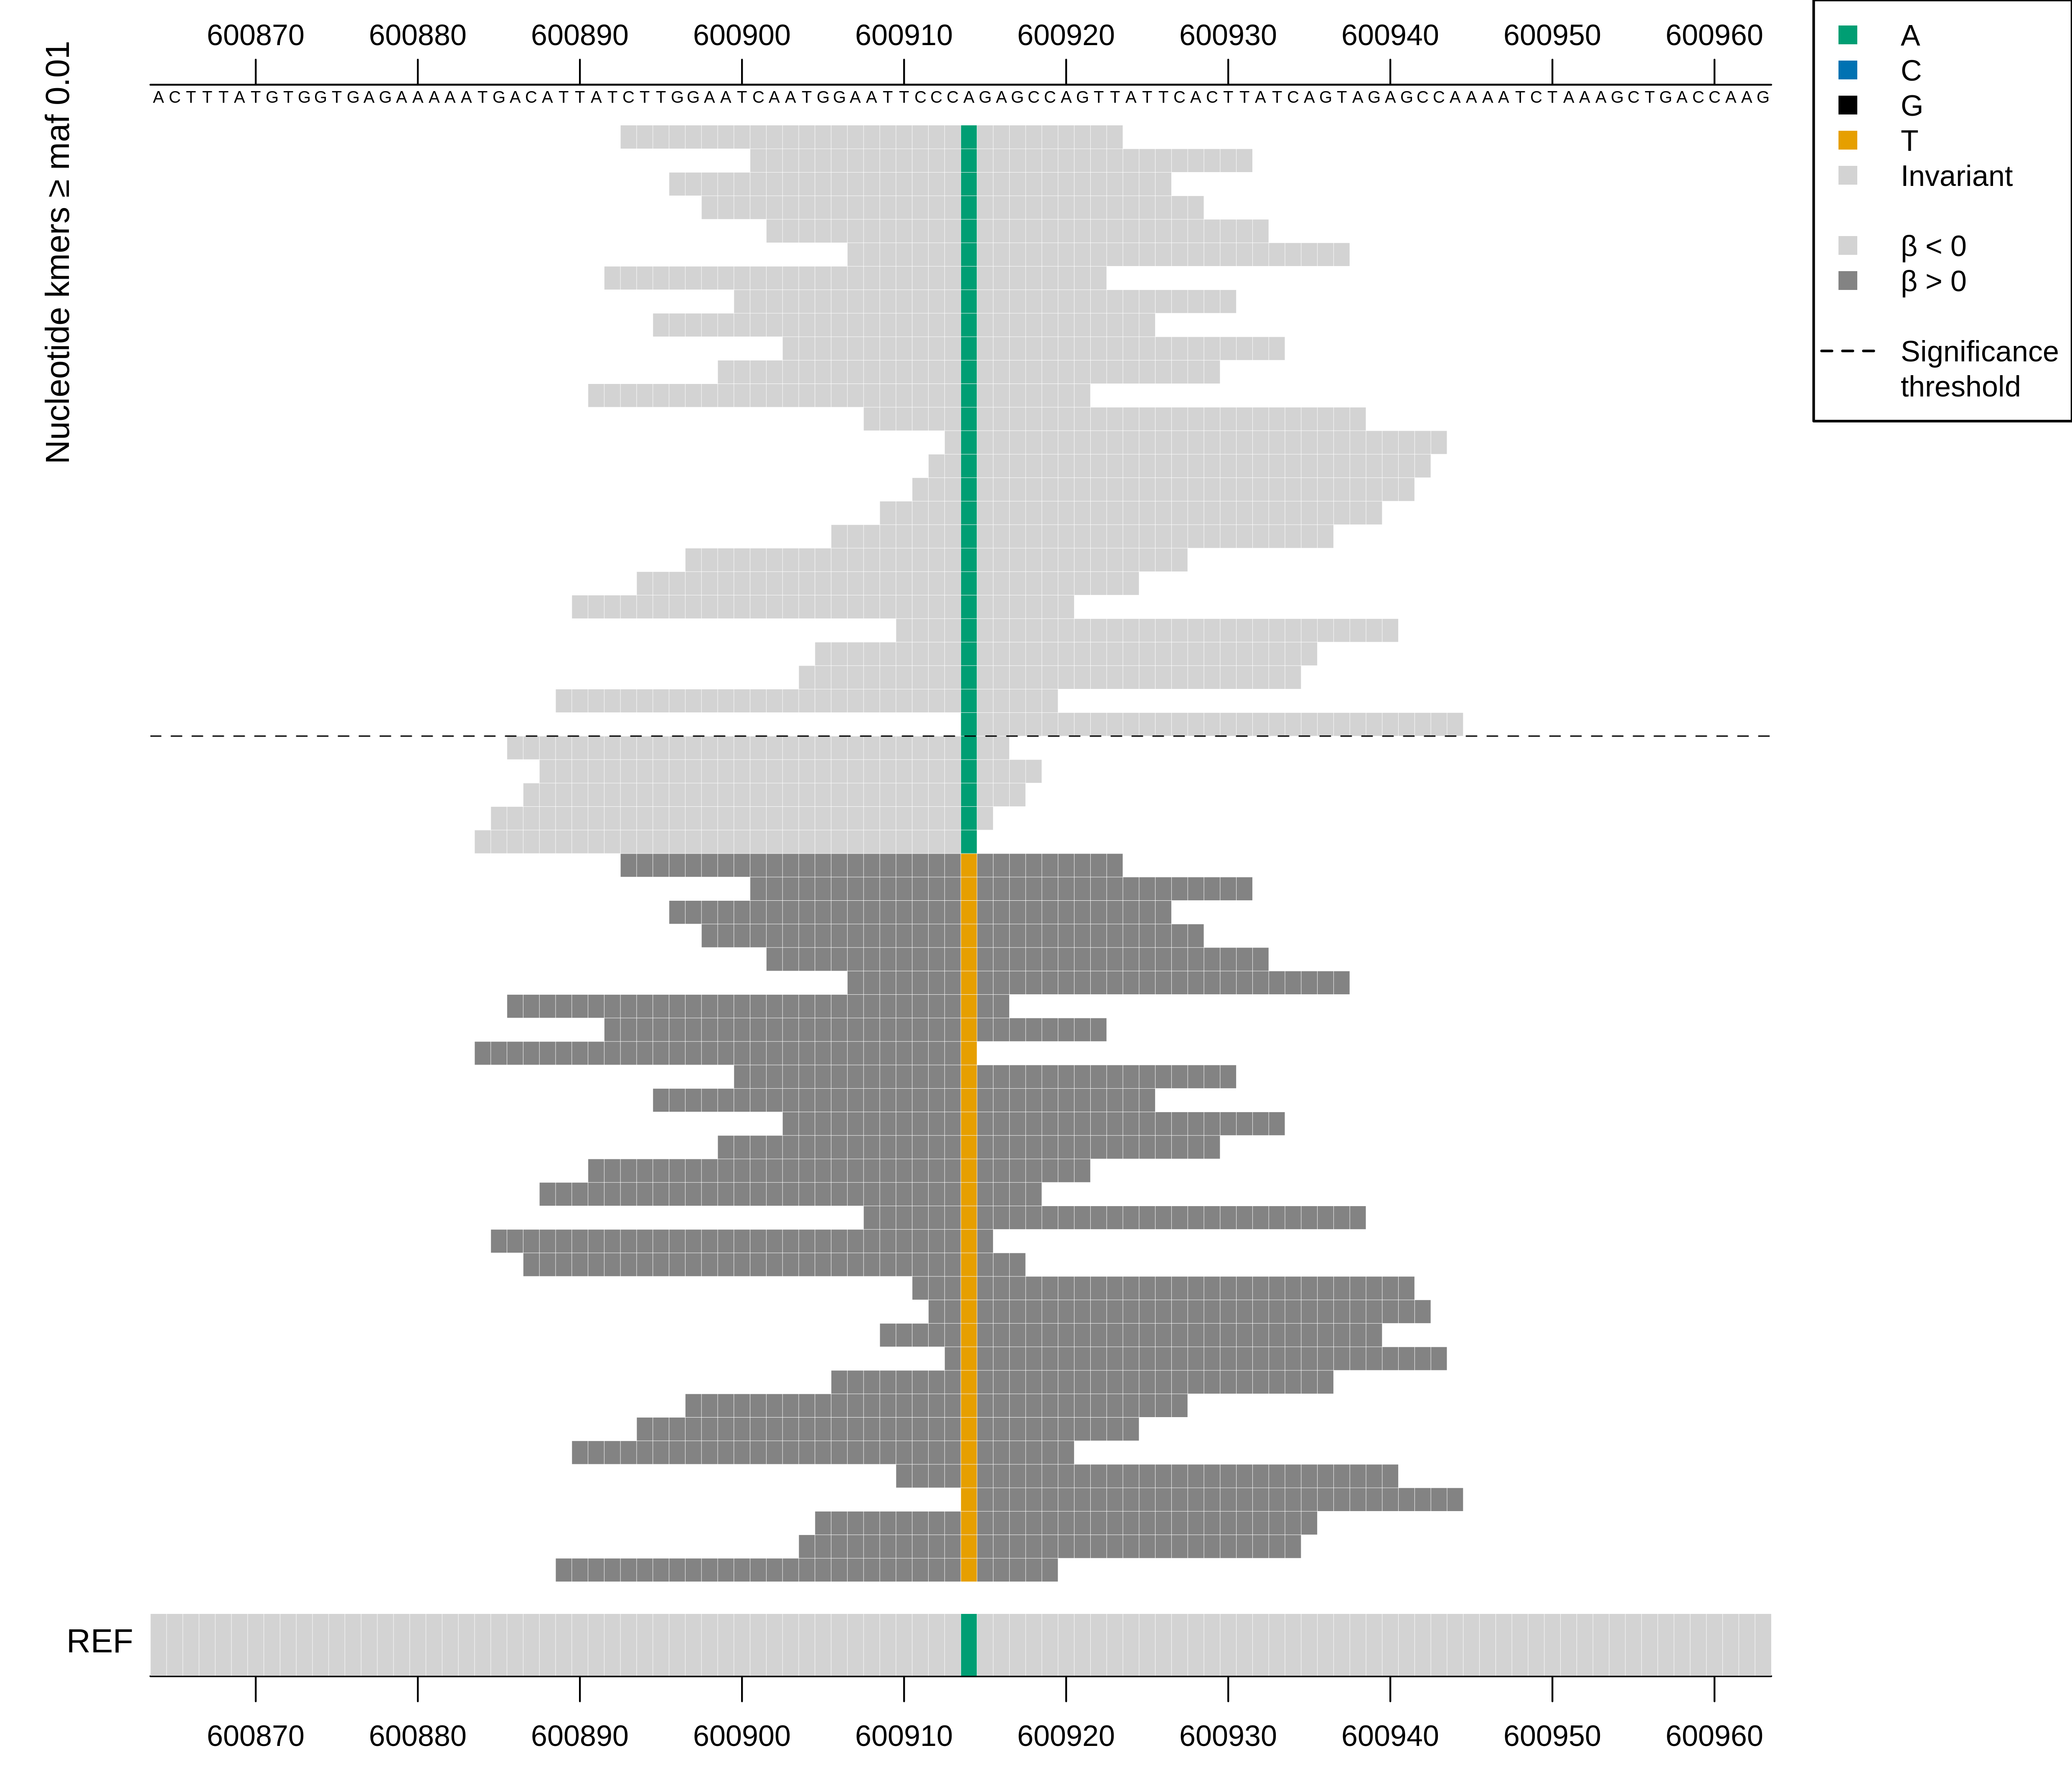

In [12]:
if PHENO=='phe8':
    FIGLAB='fus_plot_55_pos_600864_to_600963_maf0.01_alignment.png'
    print('\n'+FIGDIR+FIGLAB+'\n')
    display(Image(filename=FIGDIR+FIGLAB,alt=FIGLAB))
else:
    print('This code block works only for the example.')

Kmers capture both SNP and indel variants plus gene presence vs absence. Interpretation is required to understand what is driving the signal.

A significant kmer is capturing the presence of that kmer sequence in some genomes vs the absence of it in others. The absence of the kmer could mean either:
* the region is absent in some genomes, or 
* a different sequence is present in some genomes

SNP variation below the significance threshold may or may not be relevant to interpreting the signal of the significant kmers.

This figure shows the kmers above the MAF threshold.

Here an A/T polymorphism is tagged by the kmers, some of which are significantly associated with decreased resistance.

All significant kmers carry the A allele. A/T may drive the signal: but there are no significant kmers of opposite effect tagging the T allele.

Therefore there are likely other rare variants or deletions present in this region below the MAF threshold also driving the signal.

Find the counterpart file with no MAF filter.

***The next code block will only work for the worked example.***


/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_fus_plot_55_pos_600864_to_600963_alignment.png



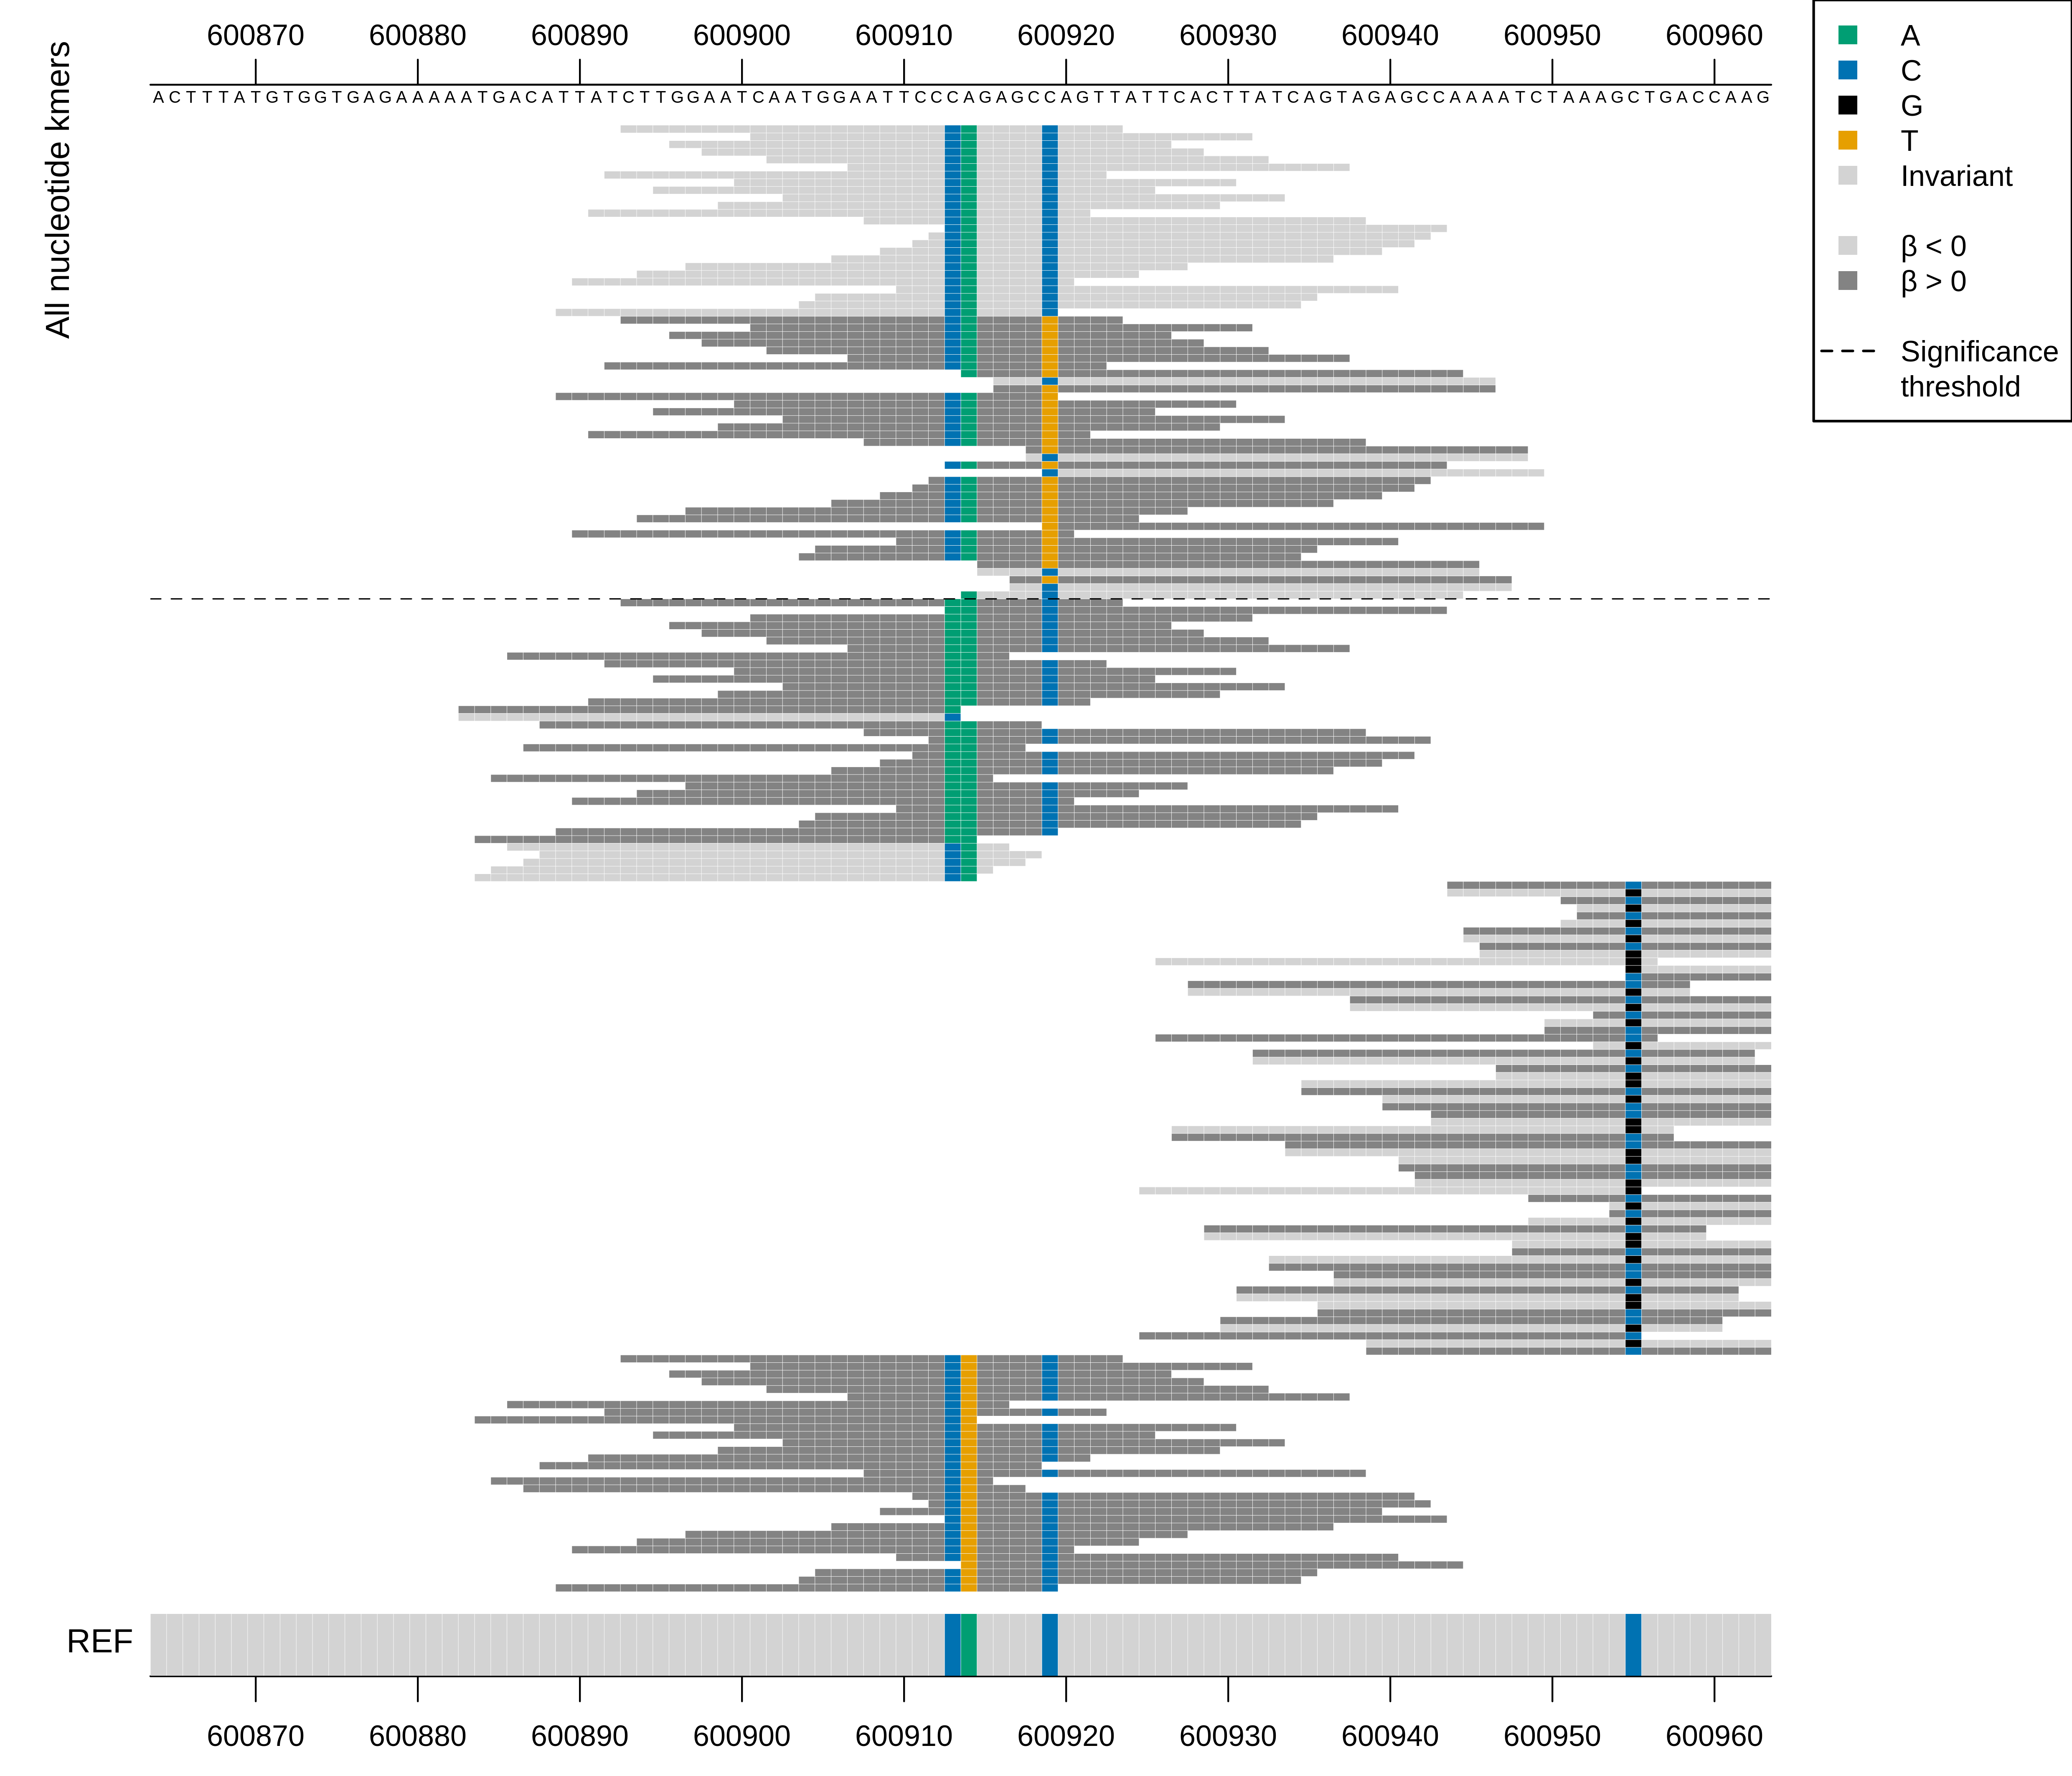

In [12]:
if PHENO=='phe8':
    FIGLAB='fus_plot_55_pos_600864_to_600963_alignment.png'
    print('\n'+FIGDIR+FIGLAB+'\n')
    display(Image(filename=FIGDIR+FIGLAB,alt=FIGLAB))
else:
    print('This code block works only for the example.')

The corresponding file named \*\_*WXYZ*\_plot\_\*\_alignment.png has no MAF filter.

It suggests additional rare C/A and C/T SNPs are also tagged by the significant kmers, and these could be driving the signal.

Notably, these polymorphisms are associated with different directions of effect.

It appears that deviations away from the G,C,C reference haplotype act to increase resistance, and this is what the significant non-rare kmers tag.

Resistance-conferring SNPs are often individually rare.

Investigate positions of interest in the reference genome in more detail here: https://www.ncbi.nlm.nih.gov/nuccore/BX571856.1?report=graph 
* Identify the codon the variant is in using the gene start position
* Determine if the variant causes an amino acid substitution

![image](https://raw.githubusercontent.com/danny-wilson/danny-wilson.github.io/main/files/StatGenSummerSchool22/fus_example.jpg)
Example interpretation for *fus* in the worked example.

### Kmer-specific Tables

To investigate individual kmers in gene *WXYZ*, open the file named \*maf_0.01_bowtie2mapping_topgene_\*\_*WXYZ*\_kmersandpvals.txt where is \* a wildcard.

For example the top hit, *fus*.

***Replace `GENE='fus'` below with a significant gene name in your Manhattan plot.***

In [13]:
GENE='fus'
FIGLAB='maf_0.01_bowtie2mapping_topgene_*_'+GENE+'_kmersandpvals.txt'
CMD=subprocess.Popen('ls '+FIGDIR+FIGLAB,shell=True,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
FILES, ERR = CMD.communicate()
FILES=FILES.decode().splitlines()
for FILE in FILES:
    print(FILE+'\n')
    with open(FILE) as f:
        print(f.read())    

/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_maf_0.01_bowtie2mapping_topgene_3_fus_kmersandpvals.txt

kmer	negLog10	beta	mac
AAGATGTCTAAGTGAAGCTCACCCATACCAC	157.258178708521	-0.9086379	18
CTAAGATGTCTAAGTGAAGCTCACCCATACC	151.901013666969	-0.8862267	21
TAAGATGTCTAAGTGAAGCTCACCCATACCA	151.901013666969	-0.8862267	21
AGATGTCTAAGTGAAGCTCACCCATACCACC	121.872626953094	-0.9668464	13
ACGGTCTACTAAGATGTCTAAGTGAAGCTCA	110.505011262048	-0.8610224	20
ACTAAGATGTCTAAGTGAAGCTCACCCATAC	110.505011262048	-0.8610224	20
ATACGGTCTACTAAGATGTCTAAGTGAAGCT	110.505011262048	-0.8610224	20
ATGGGTGAGCTTCACTTAGACATCTTAGTAG	110.505011262048	-0.8610224	20
CACTTAGACATCTTAGTAGACCGTATGAAGA	110.505011262048	-0.8610224	20
CATACGGTCTACTAAGATGTCTAAGTGAAGC	110.505011262048	-0.8610224	20
CGGTCTACTAAGATGTCTAAGTGAAGCTCAC	110.505011262048	-0.8610224	20
CTTCACTTAGACATCTTAGTAGACCGTATGA	110.505011262048	-0.8610224	20
CTTCATACGGTCTACTAAGATGTCTAAGTGA	110.505011262048	-0.8610224	2

This table lists all of the kmers that mapped to the gene, their –log<sub>10</sub> p-value, effect size (beta) and minor allele count (MAC).

Kmers have the advantage of tagging variants not in the reference genome. Open the file ending maf_0.01_bowtie2mapping_unaligned_kmersandpvals.txt to access these unmapped kmers.

In [14]:
FIGLAB='maf_0.01_bowtie2mapping_unaligned_kmersandpvals.txt'
print('\n'+FIGDIR+FIGLAB+'\n')
CMD=subprocess.Popen('head -n 200 '+FIGDIR+FIGLAB,shell=True,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
STDOUT, ERR = CMD.communicate()
print(STDOUT.decode())


/home/jovyan/Wednesday/amr/out/nucleotidekmer31_bowtie2mapping_figures/amr.phe8_nucleotide31_R00000022_maf_0.01_bowtie2mapping_unaligned_kmersandpvals.txt

kmer	negLog10	beta	mac
AAAGTAGACCGTATGAAGAAAGAATTCAACG	39.0397058701273	0.93333	7
AATTCTTTCTTCATACGGTCTACTTTGATGT	39.0397058701273	0.93333	7
ACGGTCTACTTTGATGTCTAAGTGAAGCTCA	39.0397058701273	0.93333	7
ACTTAGACATCAAAGTAGACCGTATGAAGAA	39.0397058701273	0.93333	7
ACTTTGATGTCTAAGTGAAGCTCACCCATAC	39.0397058701273	0.93333	7
AGACATCAAAGTAGACCGTATGAAGAAAGAA	39.0397058701273	0.93333	7
ATACGGTCTACTTTGATGTCTAAGTGAAGCT	39.0397058701273	0.93333	7
ATCAAAGTAGACCGTATGAAGAAAGAATTCA	39.0397058701273	0.93333	7
ATGGGTGAGCTTCACTTAGACATCAAAGTAG	39.0397058701273	0.93333	7
ATTCTTTCTTCATACGGTCTACTTTGATGTC	39.0397058701273	0.93333	7
CAAAGTAGACCGTATGAAGAAAGAATTCAAC	39.0397058701273	0.93333	7
CACTTAGACATCAAAGTAGACCGTATGAAGA	39.0397058701273	0.93333	7
CATACGGTCTACTTTGATGTCTAAGTGAAGC	39.0397058701273	0.93333	7
CATCAAAGTAGACCGTATGAAGAAAGAATTC	39.0397058701273	0.93

When unmapped kmers pass the genome-wide significance threshold, we can BLAST them to discover what non-reference genes or regions they are tagging. Take the top hit, for example:

|kmer|negLog10|beta|mac|
|:-|:-|:-|:-|
|AAAGTAGACCGTATGAAGAAAGAATTCAACG|39.0397058701273|0.93333|7|

Google **NCBI blastn**, copy the kmer (e.g. `AAAGTAGACCGTATGAAGAAAGAATTCAACG`), paste it into the **Query Sequence** box, and enter **Staphylococcus aureus (taxid:1280)** into the **Organism** box, then click **BLAST**.

You can enter multiple kmer sequences using FASTA format, for example:
```
    >kmer1
    AAAGTAGACCGTATGAAGAAAGAATTCAACG
    >kmer2
    AATTCTTTCTTCATACGGTCTACTTTGATGT
```

Select **Alignments** and choose the **Graphics** representation.

You can navigate using the Genome Browser.

### Identifying the mystery phenotypes

Use Google to try to identify the phenotype based on the genes or BLAST hits that show the strongest associations.